# 生产企业原材料的订购与运输分析

## 问题背景
一年48周，需提前24周制定订购转运计划，每周产能为2.82万 m³ 

### 原材料类型：
- **A类:** 消耗量 0.6 m³/m³，单价 120%
- **B类:** 消耗量 0.66 m³/m³，单价 110%  
- **C类:** 消耗量 0.72 m³/m³，单价 100%

### 数据说明
- 附件1：近5年402家原材料供应商的订货量和供货量数据
- 附件2：8家转运商的运输损耗率数据

## 问题一：供应商综合评估与重要性排序

### 目标
1. 分析供应商供货特征和市场占有率
2. 计算年度权重排序和趋势分析
3. 筛选出50个最重要供应商

### 1. 环境初始化与数据导入

In [60]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.style.use('default')
plt.rcParams['font.sans-serif'] = ['黑体', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 创建必要的文件夹
for folder in ['DataFrames', 'Pictures']:
    if not os.path.exists(folder):
        os.makedirs(folder)

print("环境初始化完成")

环境初始化完成


#### 环境初始化代码

导入必要的Python库，包括数据处理、数值计算、可视化等相关模块，为后续数据分析做准备。

#### 1.1 数据读取与基本分析

In [61]:
# 读取数据文件
print("正在读取数据文件...")

try:
    # 读取附件1：供应商数据
    supplier_order = pd.read_excel('C/附件1 近5年402家供应商的相关数据.xlsx', 
                                   sheet_name='企业的订货量（m³）')
    supplier_supply = pd.read_excel('C/附件1 近5年402家供应商的相关数据.xlsx', 
                                    sheet_name='供应商的供货量（m³）')
    
    # 读取附件2：转运商数据
    transporter_loss = pd.read_excel('C/附件2 近5年8家转运商的相关数据.xlsx', 
                                     sheet_name='运输损耗率（%）')
    
    print(f"数据读取成功:")
    print(f"  供应商订货量数据: {supplier_order.shape}")
    print(f"  供应商供货量数据: {supplier_supply.shape}")
    print(f"  转运商损耗率数据: {transporter_loss.shape}")
    
except Exception as e:
    print(f"数据读取失败: {e}")
    print("请确保数据文件路径正确")

正在读取数据文件...
数据读取成功:
  供应商订货量数据: (402, 242)
  供应商供货量数据: (402, 242)
  转运商损耗率数据: (8, 241)


#### 数据文件读取代码

读取供应商和转运商的原始数据文件，包括：
- 供应商订货量数据（附件1）
- 供应商供货量数据（附件1）  
- 转运商损耗率数据（附件2）

### 读取系数和离散数据

读取系数和离散.xlsx文件，获取供应商稳定性指标（标准差、方差、偏度、峰度等统计数据）

In [ ]:
# 读取系数和离散数据文件
coeff_discrete_file = "系数和离散.xlsx"

try:
    # 读取系数和离散数据，跳过前两行标题
    coeff_data = pd.read_excel(coeff_discrete_file, skiprows=2)
    
    # 重命名列
    coeff_data.columns = ['变量名', 'N', '最小值', '最大值', '均值', '标准差', 
                          '方差', '偏度', '偏度标准误差', '峰度', '峰度标准误差', '其他']
    
    # 筛选有效数据
    coeff_data = coeff_data[coeff_data['变量名'].notna() & 
                           coeff_data['变量名'].str.startswith('VAR')].copy()
    
    # 转换数值列
    numeric_columns = ['N', '最小值', '最大值', '均值', '标准差', '方差', '偏度', '偏度误差', '峰度', '峰度误差']
    for col in numeric_columns:
        if col in coeff_data.columns:
            coeff_data[col] = pd.to_numeric(coeff_data[col], errors='coerce')
    
    print(f"成功读取系数和离散数据，包含 {len(coeff_data)} 个变量的统计信息")
    print("数据预览:")
    print(coeff_data[['变量名', '均值', '标准差', '方差', '偏度', '峰度']].head())
    
except Exception as e:
    print(f"读取系数和离散数据时出错: {e}")
    coeff_data = pd.DataFrame()  # 创建空DataFrame作为默认值

成功读取系数和离散数据，包含 402 个变量的统计信息
数据预览:
        变量名     均值    标准差      方差        偏度     峰度
0  VAR00001   0.20  0.047   0.729     0.531  0.157
1  VAR00002   1.14  0.322   4.986    24.864  0.157
2  VAR00003  54.74  4.926  76.309  5823.004  0.157
3  VAR00004   0.27  0.056   0.860     0.740  0.157
4  VAR00005  28.80  2.340  36.257  1314.587  0.157


#### 系数和离散数据读取代码

读取系数和离散.xlsx文件，获取供应商稳定性评估所需的统计指标，包括标准差、方差、偏度、峰度等数据。

In [ ]:
# 数据结构分析
print("数据结构分析:")
print("\n供应商订货量数据前5行:")
print(supplier_order.head())

print("\n供应商供货量数据前5行:")
print(supplier_supply.head())

# 提取关键信息
supplier_names = supplier_order.iloc[:, 0].values  # 供应商名称
material_types = supplier_order.iloc[:, 1].values  # 材料类型
order_data = supplier_order.iloc[:, 2:].values     # 订货量数据
supply_data = supplier_supply.iloc[:, 2:].values   # 供货量数据

print(f"\n基本统计信息:")
print(f"  供应商总数: {len(supplier_names)}")
print(f"  数据周期: {order_data.shape[1]} 周")

# 分析材料类型分布
material_counts = pd.Series(material_types).value_counts()
print(f"  原材料类型分布:")
for material, count in material_counts.items():
    percentage = count / len(material_types) * 100
    print(f"    {material}类: {count}家 ({percentage:.1f}%)")

# 数据质量检查
print(f"\n数据质量检查:")
print(f"  订货量零值比例: {(order_data == 0).sum().sum() / order_data.size * 100:.1f}%")
print(f"  供货量零值比例: {(supply_data == 0).sum().sum() / supply_data.size * 100:.1f}%")

数据结构分析:

供应商订货量数据前5行:
  供应商ID 材料分类  W001  W002  W003  W004  W005  W006  W007  W008  ...  W231  W232  \
0  S001    B     0     0     0    43     0     0     0     0  ...     1     0   
1  S002    A     1     1     0     1     0     0     0     0  ...     0     0   
2  S003    C     7     1     0     0     0     1     4    50  ...    10     3   
3  S004    B     0     1     1   100     0    85     0     0  ...     1     0   
4  S005    A    30    60    60    60    70    70    60    70  ...    80    70   

   W233  W234  W235  W236  W237  W238  W239  W240  
0     0     1     0     1     0     0     0     0  
1     1     0     0     0     1     1     0     1  
2    50    20    20     7    10     9    20    10  
3     1     0     0     0     0     1     0     0  
4    70    70    70    70    70    70    70    80  

[5 rows x 242 columns]

供应商供货量数据前5行:
  供应商ID 材料分类  W001  W002  W003  W004  W005  W006  W007  W008  ...  W231  W232  \
0  S001    B     0     0     0     0     0     0     0     0

#### 数据结构分析代码

分析已读取数据的基本结构和格式，展示数据的前几行内容，帮助理解数据组织形式。

#### 1.2 转运商损耗率分析

正在分析转运商损耗率...


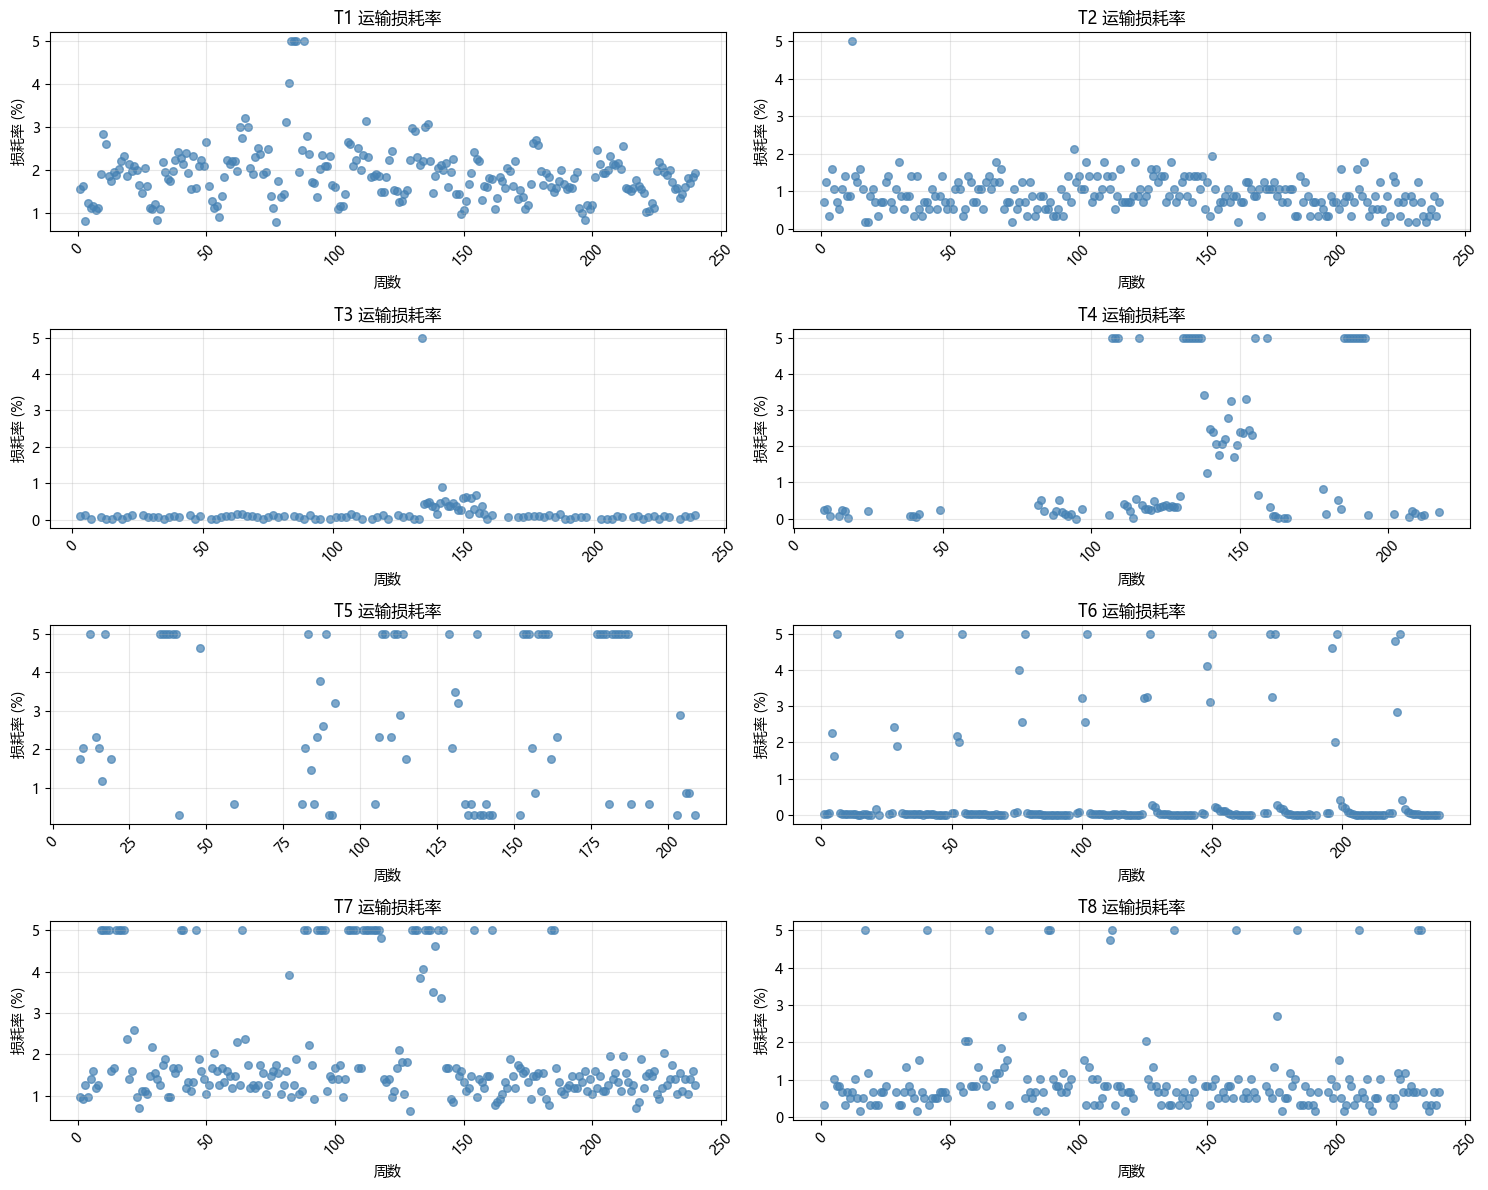

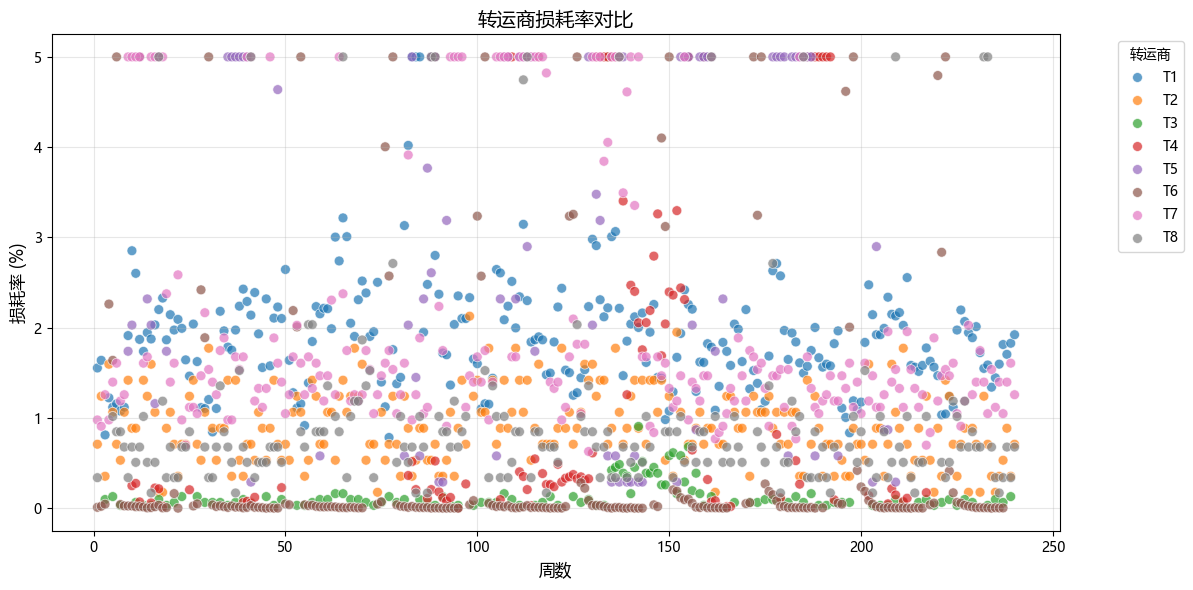

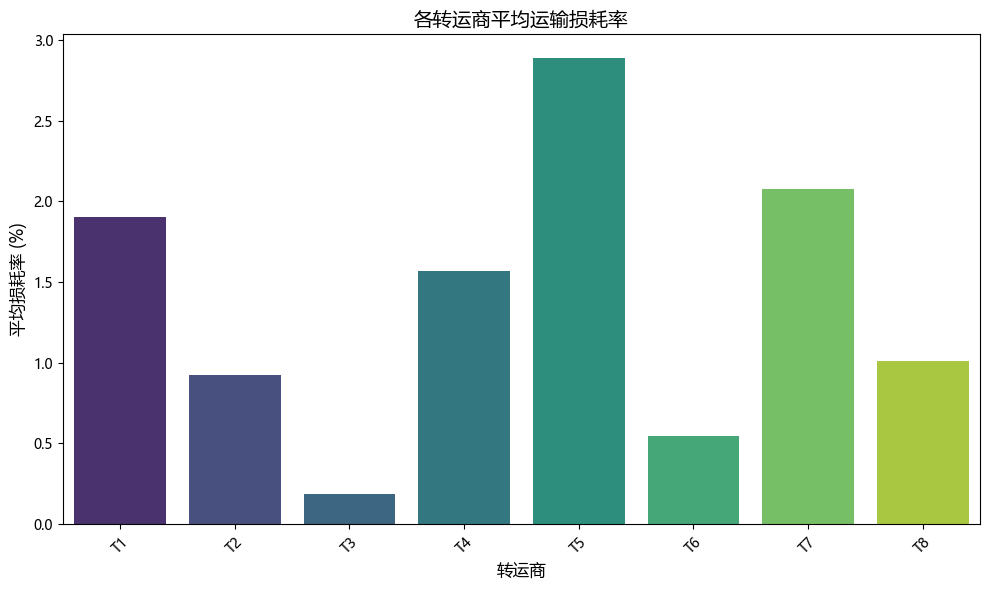

转运商损耗率分析完成


In [ ]:
# 转运商损耗率分析与可视化
print("正在分析转运商损耗率...")

# 绘制转运商损耗率分布图
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
weeks = range(1, transporter_loss.shape[1])
transporter_loss_mean = []

for i, transporter_name in enumerate(transporter_loss.iloc[:, 0]):
    row, col = divmod(i, 2)
    
    # 获取损耗率数据，过滤零值
    loss_rates = transporter_loss.iloc[i, 1:].values
    non_zero_mask = loss_rates > 0
    filtered_weeks = [w for w, mask in zip(weeks, non_zero_mask) if mask]
    filtered_loss_rates = loss_rates[non_zero_mask]
    
    transporter_loss_mean.append(filtered_loss_rates.mean() if len(filtered_loss_rates) > 0 else 0)
    
    # 绘制散点图
    axes[row, col].scatter(filtered_weeks, filtered_loss_rates, alpha=0.7, s=30, color='steelblue')
    axes[row, col].set_title(f"{transporter_name} 运输损耗率", fontsize=12)
    axes[row, col].set_xlabel("周数", fontsize=10)
    axes[row, col].set_ylabel("损耗率 (%)", fontsize=10)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Pictures/transporter_loss_scatter.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# 绘制所有转运商对比图
plt.figure(figsize=(12, 6))
transporter_long = []

for i, transporter_name in enumerate(transporter_loss.iloc[:, 0]):
    for week, loss_rate in enumerate(transporter_loss.iloc[i, 1:].values, 1):
        if loss_rate > 0:
            transporter_long.append({
                'transporter': transporter_name,
                'week': week,
                'loss_rate': loss_rate
            })

df_long = pd.DataFrame(transporter_long)
sns.scatterplot(data=df_long, x='week', y='loss_rate', hue='transporter', alpha=0.7, s=50)
plt.title('转运商损耗率对比', fontsize=14)
plt.xlabel('周数', fontsize=12)
plt.ylabel('损耗率 (%)', fontsize=12)
plt.legend(title='转运商', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Pictures/transporter_comparison_scatter.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# 绘制平均损耗率条形图
plt.figure(figsize=(10, 6))
sns.barplot(x=transporter_loss.iloc[:, 0], y=transporter_loss_mean, palette='viridis')
plt.title('各转运商平均运输损耗率', fontsize=14)
plt.xlabel('转运商', fontsize=12)
plt.ylabel('平均损耗率 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Pictures/transporter_average_loss.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

print("转运商损耗率分析完成")

#### 供应商基本信息分析代码

计算每个供应商的基本统计指标，包括总订货量、总供货量、供货率、市场占有率、供货频率、稳定性等关键指标，并生成供应商分析汇总表。

### 2. 供应商特征分析

#### 2.1 市场占有率与供货率计算

计算每个供应商的关键指标：
- 市场占有率：该供应商在相应材料类型中的市场份额
- 有效供货率：订单满足率（实际供货量/订货量）

**核心计算公式：**

**市场占有率计算：**
- 周市场占有率 = 该供应商某周订货量(或供货量) / 该材料类型所有供应商该周总量
- 总市场占有率 = 该供应商总量 / 该材料类型所有供应商总量

**有效供货率计算：**
- 周有效供货率 = 该供应商某周实际供货量 / 该供应商某周订货量
- 总有效供货率 = 该供应商总实际供货量 / 该供应商总订货量

**计算步骤：**
1. 按材料类型（A/B/C）分组所有供应商
2. 计算每种材料每周的总订货量和总供货量
3. 逐供应商计算各项指标
4. 将结果保存到字典中供后续分析

In [ ]:
# 供应商供货特征分析
print("开始分析供应商供货特征...")

def analyze_supplier_characteristics():
    """分析每个供应商的供货特征"""
    supplier_metrics = []
    
    for i in range(len(supplier_names)):
        # 步骤1：获取基本数据
        orders = order_data[i]      # 该供应商的订货量时间序列
        supplies = supply_data[i]   # 该供应商的供货量时间序列
        
        # 步骤2：数据预处理 - 过滤非零数据用于计算平均值和稳定性
        non_zero_orders = orders[orders > 0]    # 过滤掉零订货量的周数
        non_zero_supplies = supplies[supplies > 0]  # 过滤掉零供货量的周数
        
        # 步骤3：计算总量指标
        total_order = np.sum(orders)    # 总订货量：累计所有周的订货量
        total_supply = np.sum(supplies) # 总供货量：累计所有周的供货量
        
        # 步骤4：计算供货可靠性
        # 公式：reliability = 总实际供货量 / 总订货量
        # 含义：反映供应商整体的订单完成能力，值越接近1越好
        reliability = total_supply / total_order if total_order > 0 else 0
        
        # 步骤5：计算供货稳定性
        # 使用变异系数的倒数来衡量稳定性
        # 变异系数 = 标准差 / 平均值，值越小越稳定
        # 稳定性 = 1 / (变异系数 + 0.001)，值越大越稳定
        if len(non_zero_supplies) > 0:
            supply_cv = np.std(non_zero_supplies) / np.mean(non_zero_supplies)  # 计算变异系数
        else:
            supply_cv = float('inf')  # 无供货记录时设为无穷大
        stability = 1 / (supply_cv + 0.001)  # 转换为稳定性指标，加0.001避免除零
        
        # 步骤6：计算供货频率
        # 公式：supply_frequency = 有供货的周数 / 总周数
        # 含义：反映供应商的活跃程度，值越大说明供货越频繁
        supply_frequency = len(non_zero_supplies) / len(supplies)
        
        # 步骤7：计算平均周供货量
        # 只计算有供货周数的平均值，避免零值影响
        avg_weekly_supply = np.mean(non_zero_supplies) if len(non_zero_supplies) > 0 else 0
        
        # 步骤8：计算最大周供货量
        # 反映供应商的最大供货能力
        max_weekly_supply = np.max(supplies)
        
        # 步骤9：汇总所有指标
        supplier_metrics.append({
            'supplier_name': supplier_names[i],        # 供应商名称
            'material_type': material_types[i],        # 材料类型(A/B/C)
            'total_order': total_order,                # 总订货量
            'total_supply': total_supply,              # 总供货量
            'reliability': reliability,                # 供货可靠性(0-1)
            'stability': stability,                    # 供货稳定性(值越大越稳定)
            'supply_frequency': supply_frequency,      # 供货频率(0-1)
            'avg_weekly_supply': avg_weekly_supply,    # 平均周供货量
            'max_weekly_supply': max_weekly_supply,    # 最大周供货量
            'active_weeks': len(non_zero_supplies)     # 有效供货周数
        })
    
    return pd.DataFrame(supplier_metrics)

# 执行分析
supplier_analysis = analyze_supplier_characteristics()
print(f"完成 {len(supplier_analysis)} 家供应商的特征分析")

def calculate_market_share_and_fulfillment():
    """计算每个供应商的市场占有率和有效供货率"""
    supplier_metrics = {}
    
    # 按材料类型分组数据
    material_data = {'A': [], 'B': [], 'C': []}
    for i, material_type in enumerate(material_types):
        material_data[material_type].append({
            'supplier_name': supplier_names[i],
            'order_data': order_data[i],      # 该供应商的周订货量数组
            'supply_data': supply_data[i],    # 该供应商的周供货量数组
            'index': i
        })
    
    # 计算市场总量
    weekly_totals = {}
    for material in ['A', 'B', 'C']:
        suppliers = material_data[material]
        weekly_order_total = np.zeros(order_data.shape[1])
        weekly_supply_total = np.zeros(supply_data.shape[1])
        
        for supplier in suppliers:
            weekly_order_total += supplier['order_data']   # 周订货量累加
            weekly_supply_total += supplier['supply_data'] # 周供货量累加
        
        weekly_totals[material] = {
            'order_total': weekly_order_total,   # 每周总订货量数组
            'supply_total': weekly_supply_total  # 每周总供货量数组
        }
    
    # 计算每个供应商的指标
    for material in ['A', 'B', 'C']:
        suppliers = material_data[material]
        
        for supplier in suppliers:
            supplier_name = supplier['supplier_name']
            orders = supplier['order_data']    # 该供应商的周订货量数组
            supplies = supplier['supply_data'] # 该供应商的周供货量数组
            
            # 计算步骤1：每周市场占有率（基于订货量）
            # 公式：weekly_market_share_order[i] = orders[i] / weekly_totals[material]['order_total'][i]
            # 使用np.divide避免除零错误，当分母为0时结果为0
            weekly_market_share_order = np.divide(
                orders,                                      # 分子：该供应商各周订货量
                weekly_totals[material]['order_total'],      # 分母：该材料类型各周总订货量
                out=np.zeros_like(orders, dtype=float),      # 除零时的输出值
                where=weekly_totals[material]['order_total']!=0  # 只在分母非零时计算
            )
            
            # 计算步骤2：每周市场占有率（基于供货量）
            # 公式：weekly_market_share_supply[i] = supplies[i] / weekly_totals[material]['supply_total'][i]
            weekly_market_share_supply = np.divide(
                supplies,                                    # 分子：该供应商各周供货量
                weekly_totals[material]['supply_total'],     # 分母：该材料类型各周总供货量
                out=np.zeros_like(supplies, dtype=float),    # 除零时的输出值
                where=weekly_totals[material]['supply_total']!=0  # 只在分母非零时计算
            )
            
            # 计算步骤3：总市场占有率
            # 先计算总量，再计算占比
            total_order = np.sum(orders)                     # 该供应商总订货量
            total_supply = np.sum(supplies)                  # 该供应商总供货量
            total_market_order = np.sum(weekly_totals[material]['order_total'])   # 该材料类型总订货量
            total_market_supply = np.sum(weekly_totals[material]['supply_total']) # 该材料类型总供货量
            
            total_market_share_order = total_order / total_market_order if total_market_order > 0 else 0
            total_market_share_supply = total_supply / total_market_supply if total_market_supply > 0 else 0
            
            # 计算步骤4：每周有效供货率（订单满足率）
            # 公式：weekly_fulfillment_rate[i] = supplies[i] / orders[i]
            # 表示该供应商每周实际供货量占其订货量的比例
            weekly_fulfillment_rate = np.divide(
                supplies,                                    # 分子：该供应商各周实际供货量
                orders,                                      # 分母：该供应商各周订货量
                out=np.zeros_like(supplies, dtype=float),    # 除零时的输出值
                where=orders!=0                              # 只在订货量非零时计算
            )
            
            # 计算步骤5：总有效供货率
            # 公式：total_fulfillment_rate = total_supply / total_order
            # 表示该供应商总体实际供货量占其总订货量的比例
            total_fulfillment_rate = total_supply / total_order if total_order > 0 else 0
            
            # 计算步骤6：计算平均市场占有率和有效供货率
            # 只考虑有订货的周数，避免空周对平均值的影响
            active_weeks = orders > 0                        # 找出有订货的周数（布尔数组）
            
            # 平均市场占有率（基于订货量）：只计算有订货周数的平均值
            # 公式：avg_market_share_order = mean(weekly_market_share_order[active_weeks])
            avg_market_share_order = np.mean(weekly_market_share_order[active_weeks]) if np.any(active_weeks) else 0
            
            # 平均市场占有率（基于供货量）：只计算有供货周数的平均值
            # 公式：avg_market_share_supply = mean(weekly_market_share_supply[supplies > 0])
            avg_market_share_supply = np.mean(weekly_market_share_supply[supplies > 0]) if np.any(supplies > 0) else 0
            
            # 平均有效供货率：只计算有订货周数的平均值
            # 公式：avg_fulfillment_rate = mean(weekly_fulfillment_rate[active_weeks])
            avg_fulfillment_rate = np.mean(weekly_fulfillment_rate[active_weeks]) if np.any(active_weeks) else 0
            
            # 步骤7：存储计算结果
            # 将所有计算得到的指标存储到字典中，便于后续分析使用
            supplier_metrics[supplier_name] = {
                'material_type': material,                    # 材料类型（A/B/C）
                'weekly_market_share_order': weekly_market_share_order,     # 周市场占有率（基于订货量）数组
                'weekly_market_share_supply': weekly_market_share_supply,   # 周市场占有率（基于供货量）数组
                'weekly_fulfillment_rate': weekly_fulfillment_rate,         # 周有效供货率数组
                'total_market_share_order': total_market_share_order,       # 总市场占有率（基于订货量）
                'total_market_share_supply': total_market_share_supply,     # 总市场占有率（基于供货量）
                'total_fulfillment_rate': total_fulfillment_rate,           # 总有效供货率
                'avg_market_share_order': avg_market_share_order,           # 平均市场占有率（基于订货量）
                'avg_market_share_supply': avg_market_share_supply,         # 平均市场占有率（基于供货量）
                'avg_fulfillment_rate': avg_fulfillment_rate,               # 平均有效供货率
                'total_order': total_order,                                 # 总订货量
                'total_supply': total_supply,                               # 总供货量
                'active_weeks_count': np.sum(active_weeks)                  # 有效供货周数
            }
    
    # 步骤8：返回计算结果
    # 返回所有供应商的指标字典和各材料类型的市场总量数据
    return supplier_metrics, weekly_totals

# 执行计算
supplier_metrics, weekly_totals = calculate_market_share_and_fulfillment()
print("市场占有率和供货率计算完成")

# 显示整体统计
all_suppliers = list(supplier_metrics.values())
avg_fulfillment_all = np.mean([s['total_fulfillment_rate'] for s in all_suppliers])
avg_market_share_all = np.mean([s['total_market_share_order'] for s in all_suppliers])

print(f"\n整体统计:")
print(f"  所有供应商平均市场占有率: {avg_market_share_all*100:.2f}%")
print(f"  所有供应商平均供货满足率: {avg_fulfillment_all:.3f}")
print(f"  供应商总数: {len(supplier_metrics)}")

开始分析供应商供货特征...
完成 402 家供应商的特征分析
市场占有率和供货率计算完成

整体统计:
  所有供应商平均市场占有率: 0.75%
  所有供应商平均供货满足率: 0.540
  供应商总数: 402


#### 供应商基本特征分析代码

进一步分析供应商的详细特征，计算各种评估指标的具体数值，为后续的可靠性评估提供基础数据。

#### 2.2 结果保存到Excel

In [ ]:
# ==================== 保存结果到多个Excel文件 ====================
print("\n" + "="*60)
print("保存分析结果到Excel文件")
print("="*60)

def save_analysis_results_to_excel():
    """
    将分析结果保存到多个Excel文件中，每种数据类型单独存储
    """
    from datetime import datetime
    
    # 获取当前时间戳用于文件命名
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    try:
        # ============ 1. 保存供应商基本特征分析结果 ============
        print("正在保存供应商基本特征分析结果...")
        supplier_features_file = f"DataFrames/供应商基本特征分析.xlsx"
        
        with pd.ExcelWriter(supplier_features_file, engine='openpyxl') as writer:
            # 供应商基本特征表
            supplier_analysis.to_excel(writer, sheet_name='供应商基本特征', index=False)
            
            # 按材料类型分组的汇总统计
            for material in ['A', 'B', 'C']:
                material_data = supplier_analysis[supplier_analysis['material_type'] == material]
                if not material_data.empty:
                    sheet_name = f'{material}类材料供应商特征'
                    material_data.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print(f"  ✓ 已保存到: {supplier_features_file}")
        
        # ============ 2. 保存市场占有率分析结果 ============
        print("正在保存市场占有率分析结果...")
        market_share_file = f"DataFrames/供应商市场占有率分析.xlsx"
        
        # 准备市场占有率数据
        market_share_data = []
        for supplier_name, metrics in supplier_metrics.items():
            market_share_data.append({
                '供应商名称': supplier_name,
                '材料类型': metrics['material_type'],
                '总订货量': metrics['total_order'],
                '总供货量': metrics['total_supply'],
                '总市场占有率_订货': round(metrics['total_market_share_order'] * 100, 3),
                '总市场占有率_供货': round(metrics['total_market_share_supply'] * 100, 3),
                '平均市场占有率_订货': round(metrics['avg_market_share_order'] * 100, 3),
                '平均市场占有率_供货': round(metrics['avg_market_share_supply'] * 100, 3),
                '有效供货周数': metrics['active_weeks_count']
            })
        
        market_share_df = pd.DataFrame(market_share_data)
        
        with pd.ExcelWriter(market_share_file, engine='openpyxl') as writer:
            # 总体市场占有率表
            market_share_df.to_excel(writer, sheet_name='市场占有率汇总', index=False)
            
            # 按材料类型分组的市场占有率排名
            for material in ['A', 'B', 'C']:
                material_data = market_share_df[market_share_df['材料类型'] == material].copy()
                if not material_data.empty:
                    # 按总市场占有率排序
                    material_data = material_data.sort_values('总市场占有率_订货', ascending=False)
                    material_data.reset_index(drop=True, inplace=True)
                    material_data.index = range(1, len(material_data) + 1)  # 添加排名
                    material_data.index.name = '排名'
                    
                    sheet_name = f'{material}类材料市场占有率'
                    material_data.to_excel(writer, sheet_name=sheet_name)
        
        print(f"  ✓ 已保存到: {market_share_file}")
        
        # ============ 3. 保存供货率分析结果 ============
        print("正在保存供货率分析结果...")
        fulfillment_rate_file = f"DataFrames/供应商供货率分析.xlsx"
        
        # 准备供货率数据
        fulfillment_data = []
        for supplier_name, metrics in supplier_metrics.items():
            fulfillment_data.append({
                '供应商名称': supplier_name,
                '材料类型': metrics['material_type'],
                '总订货量': metrics['total_order'],
                '总供货量': metrics['total_supply'],
                '总供货率': round(metrics['total_fulfillment_rate'], 4),
                '平均供货率': round(metrics['avg_fulfillment_rate'], 4),
                '有效供货周数': metrics['active_weeks_count']
            })
        
        fulfillment_df = pd.DataFrame(fulfillment_data)
        
        with pd.ExcelWriter(fulfillment_rate_file, engine='openpyxl') as writer:
            # 总体供货率表
            fulfillment_df.to_excel(writer, sheet_name='供货率汇总', index=False)
            
            # 按材料类型分组的供货率排名
            for material in ['A', 'B', 'C']:
                material_data = fulfillment_df[fulfillment_df['材料类型'] == material].copy()
                if not material_data.empty:
                    # 按总供货率排序
                    material_data = material_data.sort_values('总供货率', ascending=False)
                    material_data.reset_index(drop=True, inplace=True)
                    material_data.index = range(1, len(material_data) + 1)  # 添加排名
                    material_data.index.name = '排名'
                    
                    sheet_name = f'{material}类材料供货率'
                    material_data.to_excel(writer, sheet_name=sheet_name)
        
        print(f"  ✓ 已保存到: {fulfillment_rate_file}")
        
        # ============ 4. 保存周数据时间序列 ============
        print("正在保存周数据时间序列...")
        weekly_data_file = f"DataFrames/供应商周数据时间序列.xlsx"
        
        with pd.ExcelWriter(weekly_data_file, engine='openpyxl') as writer:
            # 为每种材料类型创建周数据表
            for material in ['A', 'B', 'C']:
                # 筛选该材料类型的供应商
                material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                                     if metrics['material_type'] == material]
                
                if not material_suppliers:
                    continue
                
                # 创建周市场占有率数据表
                weeks_count = len(material_suppliers[0][1]['weekly_market_share_order'])
                week_columns = [f'第{i+1}周' for i in range(weeks_count)]
                
                # 周市场订购占有率数据
                market_share_weekly = pd.DataFrame()
                market_share_weekly['供应商名称'] = [name for name, _ in material_suppliers]
                for i, week_col in enumerate(week_columns):
                    market_share_weekly[week_col] = [metrics['weekly_market_share_order'][i] * 100 
                                                   for _, metrics in material_suppliers]
                
                market_share_weekly.to_excel(writer, sheet_name=f'{material}类材料周市场订购占有率', index=False)
                
                # 周市场供货占有率数据
                market_share_supply_weekly = pd.DataFrame()
                market_share_supply_weekly['供应商名称'] = [name for name, _ in material_suppliers]
                for i, week_col in enumerate(week_columns):
                    market_share_supply_weekly[week_col] = [metrics['weekly_market_share_supply'][i] * 100 
                                                           for _, metrics in material_suppliers]
                    
                market_share_supply_weekly.to_excel(writer, sheet_name=f'{material}类材料周市场供货占有率', index=False)
                
                # 周供货率数据
                fulfillment_weekly = pd.DataFrame()
                fulfillment_weekly['供应商名称'] = [name for name, _ in material_suppliers]
                for i, week_col in enumerate(week_columns):
                    fulfillment_weekly[week_col] = [metrics['weekly_fulfillment_rate'][i] 
                                                  for _, metrics in material_suppliers]
                
                fulfillment_weekly.to_excel(writer, sheet_name=f'{material}类材料周供货率', index=False)
        
        print(f"  ✓ 已保存到: {weekly_data_file}")
        
        # ============ 5. 保存市场总体统计数据 ============
        print("正在保存市场总体统计数据...")
        market_summary_file = f"DataFrames/市场总体统计分析.xlsx"
        
        # 准备市场总体数据
        market_summary_data = []
        for material in ['A', 'B', 'C']:
            total_order = np.sum(weekly_totals[material]['order_total'])
            total_supply = np.sum(weekly_totals[material]['supply_total'])
            overall_fulfillment = total_supply / total_order if total_order > 0 else 0
            
            # 该材料类型的供应商数量
            supplier_count = len([s for s in supplier_metrics.values() if s['material_type'] == material])
            
            # 计算平均周订货量和供货量
            weeks_count = len(weekly_totals[material]['order_total'])
            avg_weekly_order = total_order / weeks_count
            avg_weekly_supply = total_supply / weeks_count
            
            market_summary_data.append({
                '材料类型': material,
                '供应商数量': supplier_count,
                '总周数': weeks_count,
                '总订货量': total_order,
                '总供货量': total_supply,
                '平均周订货量': round(avg_weekly_order, 2),
                '平均周供货量': round(avg_weekly_supply, 2),
                '整体供货率': round(overall_fulfillment, 4),
                '供货率百分比': f"{overall_fulfillment*100:.2f}%"
            })
        
        market_summary_df = pd.DataFrame(market_summary_data)
        
        with pd.ExcelWriter(market_summary_file, engine='openpyxl') as writer:
            # 市场总体统计
            market_summary_df.to_excel(writer, sheet_name='市场总体统计', index=False)
            
            # 每周市场总量数据
            weekly_totals_data = pd.DataFrame()
            weeks_count = len(weekly_totals['A']['order_total'])
            weekly_totals_data['周次'] = [f'第{i+1}周' for i in range(weeks_count)]
            
            for material in ['A', 'B', 'C']:
                weekly_totals_data[f'{material}类订货总量'] = weekly_totals[material]['order_total']
                weekly_totals_data[f'{material}类供货总量'] = weekly_totals[material]['supply_total']
                weekly_totals_data[f'{material}类周供货率'] = np.divide(
                    weekly_totals[material]['supply_total'],
                    weekly_totals[material]['order_total'],
                    out=np.zeros_like(weekly_totals[material]['supply_total']),
                    where=weekly_totals[material]['order_total']!=0
                )
            
            weekly_totals_data.to_excel(writer, sheet_name='每周市场总量', index=False)
        
        print(f"  ✓ 已保存到: {market_summary_file}")
        
        # ============ 输出保存成功信息 ============
        print("\n" + "="*60)
        print("数据保存完成！已创建以下Excel文件：")
        print("="*60)
        print(f"1. 供应商基本特征分析: {supplier_features_file}")
        print(f"2. 供应商市场占有率分析: {market_share_file}")
        print(f"3. 供应商供货率分析: {fulfillment_rate_file}")
        print(f"4. 供应商周数据时间序列: {weekly_data_file}")
        print(f"5. 市场总体统计分析: {market_summary_file}")
        print("\n每个文件都包含多个工作表，按不同维度组织数据")
        print("文件已保存在DataFrames文件夹中")
        
        return {
            'supplier_features': supplier_features_file,
            'market_share': market_share_file,
            'fulfillment_rate': fulfillment_rate_file,
            'weekly_data': weekly_data_file,
            'market_summary': market_summary_file
        }
        
    except Exception as e:
        print(f"保存文件时发生错误: {str(e)}")
        return None

# 执行保存操作
saved_files = save_analysis_results_to_excel()

if saved_files:
    print(f"\n✓ 所有分析结果已成功保存到5个不同的Excel文件中")
    print(f"✓ 共包含 {len(['A', 'B', 'C']) * 4 + 2} 个工作表的详细数据")
else:
    print("\n✗ 文件保存失败，请检查错误信息")


保存分析结果到Excel文件
正在保存供应商基本特征分析结果...
  ✓ 已保存到: DataFrames/供应商基本特征分析.xlsx
正在保存市场占有率分析结果...
  ✓ 已保存到: DataFrames/供应商市场占有率分析.xlsx
正在保存供货率分析结果...
  ✓ 已保存到: DataFrames/供应商供货率分析.xlsx
正在保存周数据时间序列...
  ✓ 已保存到: DataFrames/供应商周数据时间序列.xlsx
正在保存市场总体统计数据...
  ✓ 已保存到: DataFrames/市场总体统计分析.xlsx

数据保存完成！已创建以下Excel文件：
1. 供应商基本特征分析: DataFrames/供应商基本特征分析.xlsx
2. 供应商市场占有率分析: DataFrames/供应商市场占有率分析.xlsx
3. 供应商供货率分析: DataFrames/供应商供货率分析.xlsx
4. 供应商周数据时间序列: DataFrames/供应商周数据时间序列.xlsx
5. 市场总体统计分析: DataFrames/市场总体统计分析.xlsx

每个文件都包含多个工作表，按不同维度组织数据
文件已保存在DataFrames文件夹中

✓ 所有分析结果已成功保存到5个不同的Excel文件中
✓ 共包含 14 个工作表的详细数据


#### 供应商供货率分析代码

计算并分析各供应商的供货率指标，包括总体供货率统计和分材料类型的供货率排名，并保存分析结果到Excel文件。

### 3. 数据可视化分析

#### 3.1 市场占有率热力图

In [ ]:
def plot_market_share_heatmap(top_n_detail=20, top_n_comparison=10):
    """
    绘制供应商在对应材料类型的市场占有率热力分布图（周数据）
    
    参数:
    top_n_detail: 详细热力图显示的供应商数量 (默认20)
    top_n_comparison: 对比图显示的供应商数量 (默认10)
    """
    
    print("\n" + "="*60)
    print("绘制市场占有率热力分布图（周数据）")
    print("="*60)
    
    # 为每种材料类型绘制热力图
    for material in ['A', 'B', 'C']:
        print(f"\n正在绘制 {material} 类材料供应商市场占有率热力图...")
        
        # 筛选该材料类型的供应商
        material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                             if metrics['material_type'] == material]
        
        # 按总市场占有率排序，选择前N名供应商以便可视化
        material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
        top_suppliers = material_suppliers[:top_n_detail]  # 使用参数控制显示数量
        
        if not top_suppliers:
            print(f"  {material} 类材料没有找到供应商数据")
            continue
        
        # 创建市场占有率矩阵
        weeks = len(top_suppliers[0][1]['weekly_market_share_order'])
        heatmap_data = np.zeros((len(top_suppliers), weeks))
        supplier_names_list = []
        
        for i, (supplier_name, metrics) in enumerate(top_suppliers):
            weekly_data = metrics['weekly_market_share_order'] * 100  # 转换为百分比
            # 将0值设置为np.nan，这样在热力图中会显示为白色
            heatmap_data[i, :] = np.where(weekly_data == 0, np.nan, weekly_data)
            supplier_names_list.append(supplier_name)
        
        # 创建图表
        plt.figure(figsize=(16, 10))
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap('YlOrRd').copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
        
        # 设置标题和标签
        plt.title(f'{material}类材料供应商市场占有率热力图（TOP {top_n_detail}）', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('周数', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 设置y轴标签
        plt.yticks(range(len(supplier_names_list)), supplier_names_list, fontsize=10)
        
        # 设置x轴标签（每隔10周显示一次，避免过于拥挤）
        x_ticks = range(0, weeks, max(1, weeks//10))
        plt.xticks(x_ticks, [f'第{i+1}周' for i in x_ticks], rotation=45, fontsize=10)
        
        # 添加颜色条
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('市场占有率 (%)', fontsize=12)
        
        # 在热力图上添加数值（只在数值较大的地方显示，避免过于拥挤）
        for i in range(len(supplier_names_list)):
            for j in range(0, weeks, max(1, weeks//20)):  # 只显示部分数值
                if not np.isnan(heatmap_data[i, j]) and heatmap_data[i, j] > 1:  # 只显示大于1%的市场占有率
                    plt.text(j, i, f'{heatmap_data[i, j]:.1f}', 
                            ha='center', va='center', fontsize=8, color='white' if heatmap_data[i, j] > 5 else 'black')
        
        plt.tight_layout()
        plt.savefig(f'Pictures/market_share_heatmap_{material}.svg', format='svg', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 显示该材料类型的统计信息
        total_weeks = heatmap_data.shape[1]
        # 计算统计信息时排除NaN值
        valid_data = heatmap_data[~np.isnan(heatmap_data)]
        avg_market_share = np.mean(valid_data) if len(valid_data) > 0 else 0
        max_market_share = np.nanmax(heatmap_data)
        top_supplier = supplier_names_list[np.nanargmax(np.nanmax(heatmap_data, axis=1))]
        
        print(f"  {material} 类材料市场占有率统计:")
        print(f"    - 数据周数: {total_weeks}")
        print(f"    - 平均市场占有率: {avg_market_share:.2f}%")
        print(f"    - 最高市场占有率: {max_market_share:.2f}%")
        print(f"    - 最高市场占有率的供应商: {top_supplier}")
    
    # 绘制综合对比图
    plt.figure(figsize=(18, 8))
    
    # 创建子图用于显示三种材料的对比
    material_colors = {'A': 'Reds', 'B': 'Blues', 'C': 'Greens'}
    
    for idx, material in enumerate(['A', 'B', 'C'], 1):
        plt.subplot(1, 3, idx)
        
        # 筛选该材料类型的供应商
        material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                             if metrics['material_type'] == material]
        
        # 按总市场占有率排序，选择前N名
        material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
        top_suppliers = material_suppliers[:top_n_comparison]  # 使用参数控制显示数量
        
        if not top_suppliers:
            continue
        
        # 创建数据矩阵
        weeks = len(top_suppliers[0][1]['weekly_market_share_order'])
        heatmap_data = np.zeros((len(top_suppliers), weeks))
        supplier_names_list = []
        
        for i, (supplier_name, metrics) in enumerate(top_suppliers):
            weekly_data = metrics['weekly_market_share_order'] * 100
            # 将0值设置为np.nan，这样在热力图中会显示为白色
            heatmap_data[i, :] = np.where(weekly_data == 0, np.nan, weekly_data)
            supplier_names_list.append(supplier_name[:8])  # 截断名称避免过长
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap(material_colors[material]).copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
        
        plt.title(f'{material}类材料（TOP {top_n_comparison}）', fontsize=14, fontweight='bold')
        plt.xlabel('周数', fontsize=10)
        if idx == 1:  # 只在第一个子图显示y轴标签
            plt.ylabel('供应商', fontsize=10)
        
        plt.yticks(range(len(supplier_names_list)), supplier_names_list, fontsize=8)
        
        # 设置x轴标签
        x_ticks = range(0, weeks, max(1, weeks//5))
        plt.xticks(x_ticks, [f'{i+1}' for i in x_ticks], fontsize=8)
        
        # 添加颜色条
        plt.colorbar(im, shrink=0.8, label='市场占有率(%)')
    
    plt.suptitle('各类材料供应商市场占有率热力图对比（周数据）', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('Pictures/market_share_heatmap_comparison.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n周市场占有率热力分布图绘制完成!")
    print("   已保存为SVG格式的矢量图文件")

#### 供货率热力图可视化代码

创建供货率的热力图可视化，展示不同供应商在不同时间段的供货表现，并将图表保存为SVG格式文件。

In [ ]:
def plot_yearly_market_share_heatmap(top_n=15):
    """
    绘制年平均市场占有率热力分布图（每48周为一年）
    
    参数:
    top_n: 显示的供应商数量 (默认15)
    """
    
    print("\n" + "="*60)
    print("绘制年平均市场占有率热力分布图")
    print("="*60)
    
    # 计算年数和每年的数据
    def calculate_yearly_data():
        """计算每年的市场占有率数据"""
        
        # 获取总周数
        first_supplier = list(supplier_metrics.values())[0]
        total_weeks = len(first_supplier['weekly_market_share_order'])
        weeks_per_year = 48
        years = total_weeks // weeks_per_year
        
        print(f"数据分析:")
        print(f"  - 总周数: {total_weeks}")
        print(f"  - 每年周数: {weeks_per_year}")
        print(f"  - 完整年数: {years}")
        print(f"  - 剩余周数: {total_weeks % weeks_per_year}")
        
        yearly_data = {}
        
        for material in ['A', 'B', 'C']:
            # 筛选该材料类型的供应商
            material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                                 if metrics['material_type'] == material]
            
            # 按总市场占有率排序，选择前N名
            material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
            top_suppliers = material_suppliers[:top_n]  # 使用参数控制显示数量
            
            if not top_suppliers:
                continue
            
            # 计算每年的平均市场占有率
            supplier_yearly_data = []
            supplier_names = []
            
            for supplier_name, metrics in top_suppliers:
                weekly_data = metrics['weekly_market_share_order'] * 100  # 转换为百分比
                yearly_averages = []
                
                for year in range(years):
                    start_week = year * weeks_per_year
                    end_week = (year + 1) * weeks_per_year
                    year_data = weekly_data[start_week:end_week]
                    
                    # 计算该年的平均市场占有率（只考虑非零值）
                    non_zero_data = year_data[year_data > 0]
                    if len(non_zero_data) > 0:
                        yearly_avg = np.mean(non_zero_data)
                    else:
                        yearly_avg = 0
                    
                    yearly_averages.append(yearly_avg)
                
                supplier_yearly_data.append(yearly_averages)
                supplier_names.append(supplier_name)
            
            yearly_data[material] = {
                'data': np.array(supplier_yearly_data),
                'suppliers': supplier_names,
                'years': years
            }
        
        return yearly_data, years
    
    # 计算年度数据
    yearly_data, years = calculate_yearly_data()
    
    if years < 1:
        print("数据不足一年，无法绘制年度热力图")
        return
    
    # 为每种材料绘制年度热力图
    for material in ['A', 'B', 'C']:
        if material not in yearly_data:
            continue
            
        data = yearly_data[material]['data']
        suppliers = yearly_data[material]['suppliers']
        
        print(f"\n正在绘制 {material} 类材料年平均市场占有率热力图...")
        
        # 将0值设置为np.nan，这样在热力图中会显示为白色
        data_with_nan = np.where(data == 0, np.nan, data)
        
        # 创建图表
        plt.figure(figsize=(12, 10))
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap('YlOrRd').copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(data_with_nan, cmap=cmap, aspect='auto', interpolation='nearest')
        
        # 设置标题和标签
        plt.title(f'{material}类材料供应商年平均市场占有率热力图（TOP {top_n}）', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('年份', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 设置y轴标签
        plt.yticks(range(len(suppliers)), suppliers, fontsize=10)
        
        # 设置x轴标签
        year_labels = [f'第{i+1}年' for i in range(years)]
        plt.xticks(range(years), year_labels, fontsize=10)
        
        # 添加颜色条
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('年平均市场占有率 (%)', fontsize=12)
        
        # 在热力图上添加数值
        for i in range(len(suppliers)):
            for j in range(years):
                if not np.isnan(data_with_nan[i, j]) and data_with_nan[i, j] > 0.1:  # 只显示大于0.1%的市场占有率
                    plt.text(j, i, f'{data_with_nan[i, j]:.1f}', 
                            ha='center', va='center', fontsize=10, 
                            color='white' if data_with_nan[i, j] > 3 else 'black',
                            fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'Pictures/yearly_market_share_heatmap_{material}.svg', format='svg', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 显示统计信息
        valid_data = data[data > 0]
        avg_yearly_share = np.mean(valid_data) if len(valid_data) > 0 else 0
        max_yearly_share = np.max(data)
        
        # 找到最高市场占有率的供应商和年份
        max_pos = np.unravel_index(np.argmax(data), data.shape)
        top_supplier_year = suppliers[max_pos[0]]
        top_year = max_pos[1] + 1
        
        print(f"  {material} 类材料年度市场占有率统计:")
        print(f"    - 分析年数: {years}")
        print(f"    - 平均年度市场占有率: {avg_yearly_share:.2f}%")
        print(f"    - 最高年度市场占有率: {max_yearly_share:.2f}%")
        print(f"    - 最高表现: {top_supplier_year} (第{top_year}年)")
        
        # 计算每年的市场集中度（前5名占有率之和）
        top5_concentration = []
        for year in range(years):
            year_data = data[:, year]
            top5_sum = np.sum(np.sort(year_data)[-5:])  # 前5名的市场占有率之和
            top5_concentration.append(top5_sum)
        
        print(f"    - 市场集中度变化:")
        for year, concentration in enumerate(top5_concentration):
            print(f"      第{year+1}年 TOP5占有率: {concentration:.1f}%")
    
    # 绘制综合年度对比图
    plt.figure(figsize=(18, 8))
    
    material_colors = {'A': 'Reds', 'B': 'Blues', 'C': 'Greens'}
    
    for idx, material in enumerate(['A', 'B', 'C'], 1):
        if material not in yearly_data:
            continue
            
        plt.subplot(1, 3, idx)
        
        data = yearly_data[material]['data'][:10]  # 只显示前10名
        suppliers = yearly_data[material]['suppliers'][:10]
        
        # 将0值设置为np.nan，这样在热力图中会显示为白色
        data_with_nan = np.where(data == 0, np.nan, data)
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap(material_colors[material]).copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(data_with_nan, cmap=cmap, aspect='auto', interpolation='nearest')
        
        plt.title(f'{material}类材料年度（TOP 10）', fontsize=14, fontweight='bold')
        plt.xlabel('年份', fontsize=10)
        if idx == 1:
            plt.ylabel('供应商', fontsize=10)
        
        plt.yticks(range(len(suppliers)), [s[:8] for s in suppliers], fontsize=8)
        plt.xticks(range(years), [f'年{i+1}' for i in range(years)], fontsize=8)
        
        # 添加颜色条
        plt.colorbar(im, shrink=0.8, label='年平均市场占有率(%)')
        
        # 添加数值标注（简化显示）
        for i in range(min(5, len(suppliers))):  # 只标注前5名
            for j in range(years):
                if not np.isnan(data_with_nan[i, j]) and data_with_nan[i, j] > 1:
                    plt.text(j, i, f'{data_with_nan[i, j]:.0f}', 
                            ha='center', va='center', fontsize=8, 
                            color='white' if data_with_nan[i, j] > 5 else 'black')
    
    plt.suptitle('各类材料供应商年平均市场占有率对比', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('Pictures/yearly_market_share_comparison.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n年平均市场占有率热力分布图绘制完成!")
    print("   已保存为SVG格式的矢量图文件")

#### 市场占有率分析代码

计算各供应商在不同材料类型中的市场占有率，分析市场集中度和竞争格局，并保存详细的市场份额数据。

**执行市场占有率热力图绘制：**

开始绘制市场占有率热力分布图...

绘制市场占有率热力分布图（周数据）

正在绘制 A 类材料供应商市场占有率热力图...


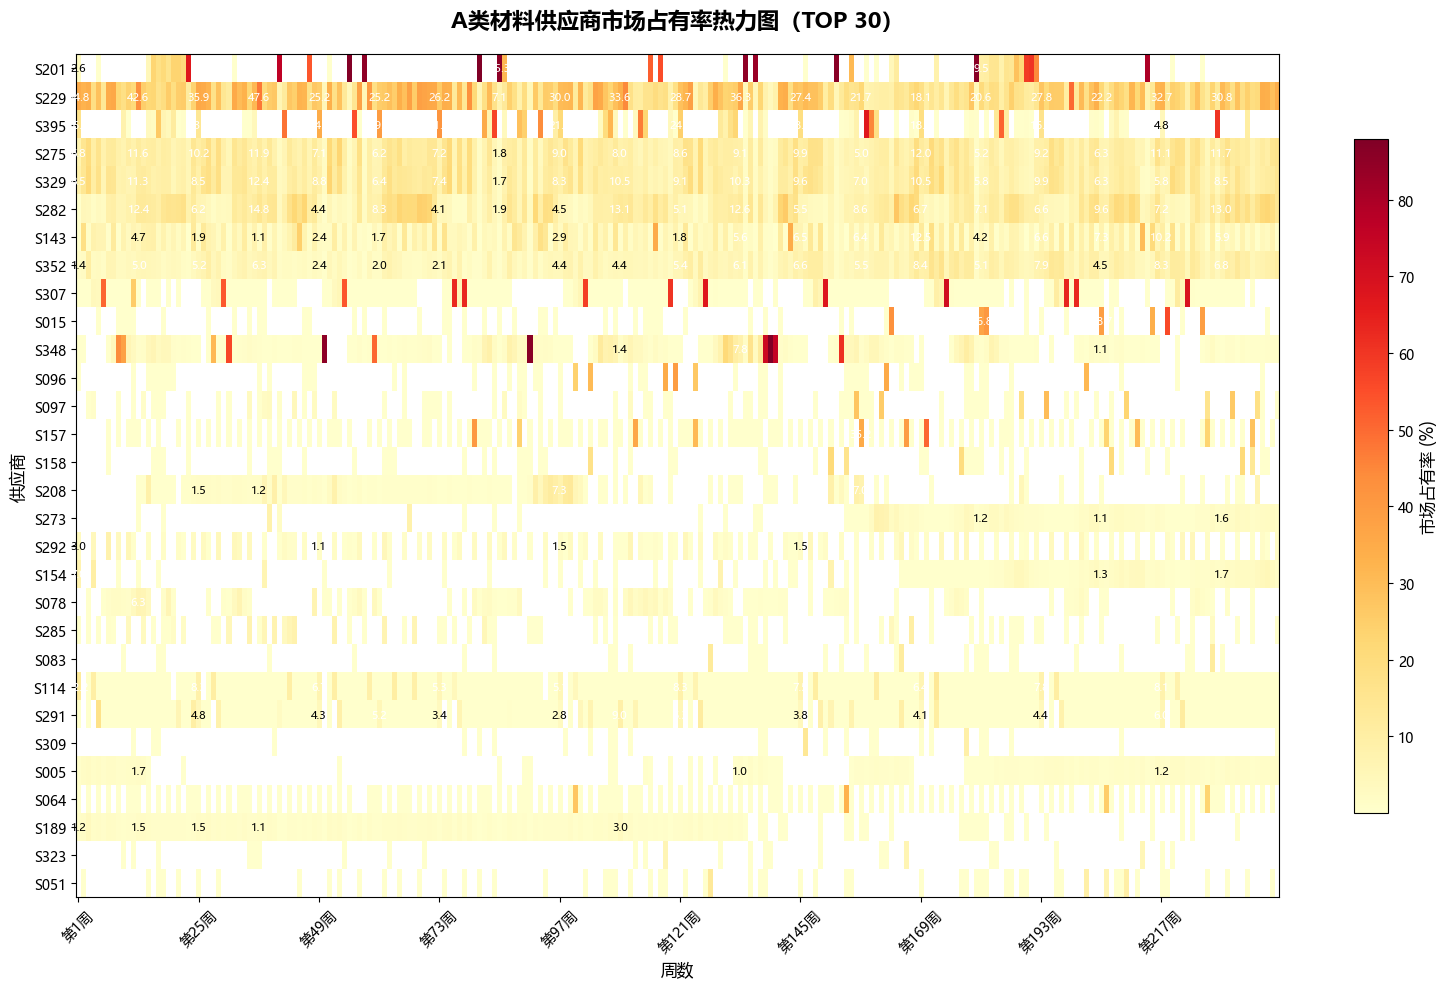

  A 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 5.80%
    - 最高市场占有率: 87.95%
    - 最高市场占有率的供应商: S348

正在绘制 B 类材料供应商市场占有率热力图...


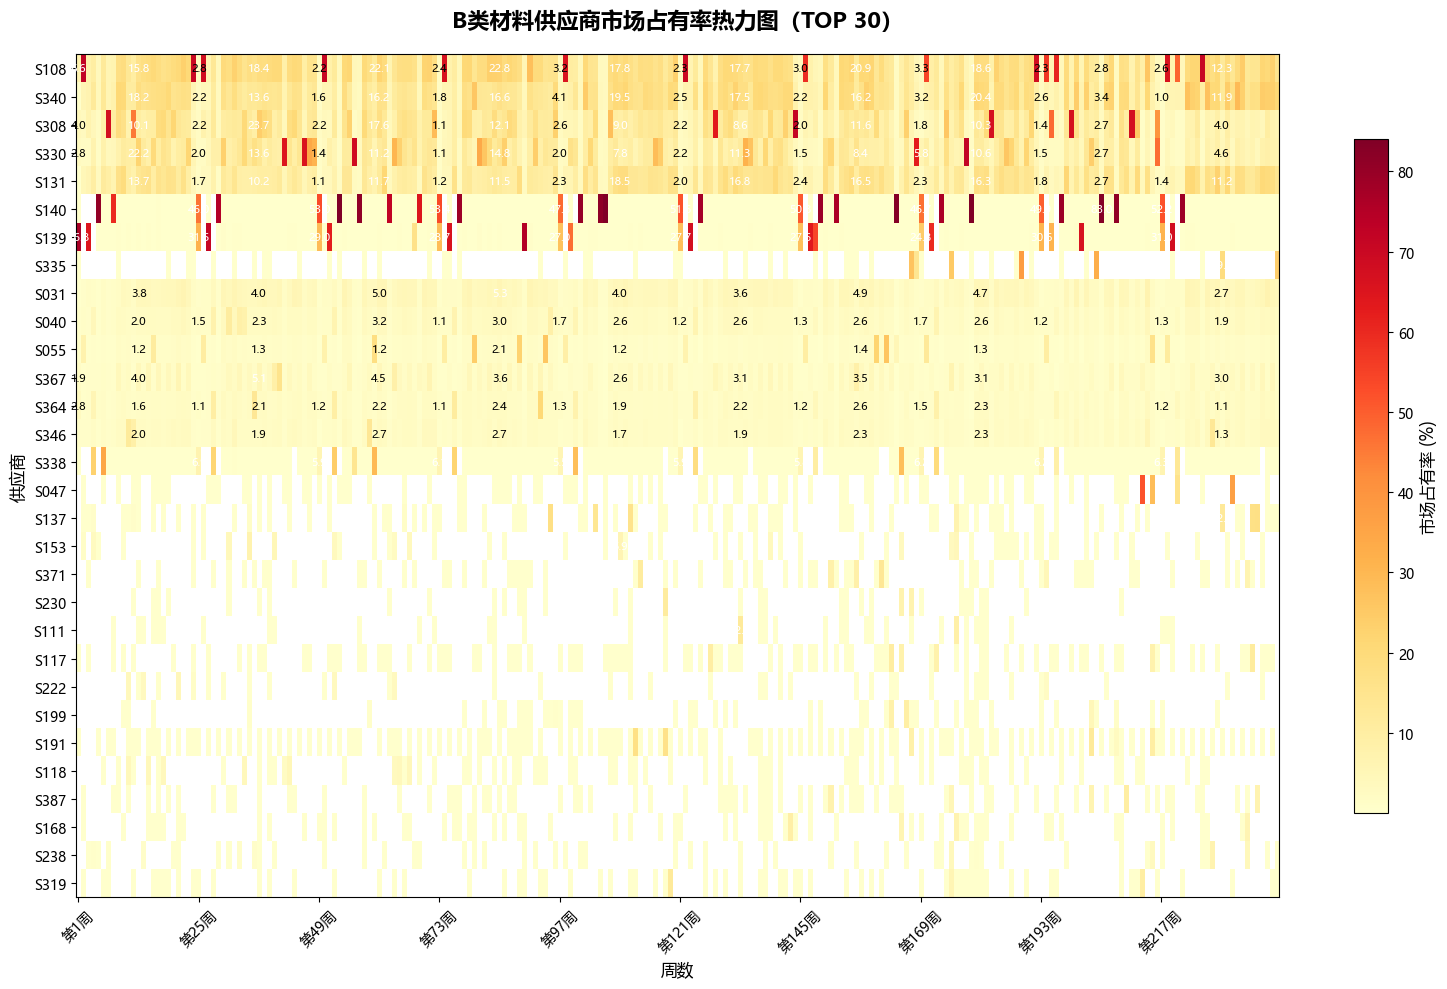

  B 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 5.32%
    - 最高市场占有率: 84.08%
    - 最高市场占有率的供应商: S140

正在绘制 C 类材料供应商市场占有率热力图...


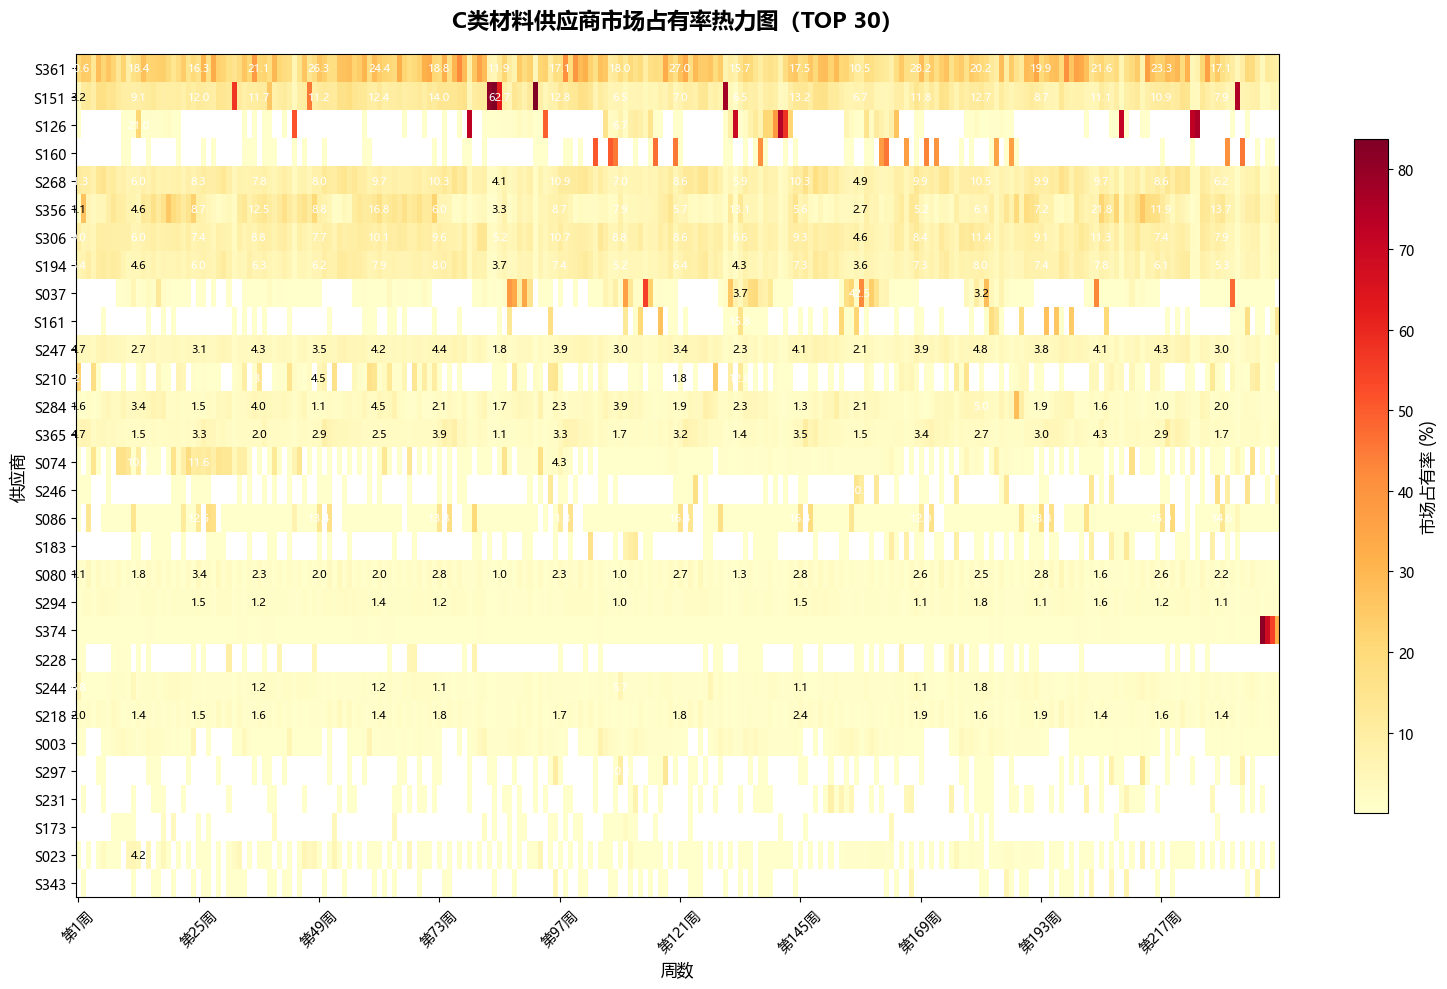

  C 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 4.53%
    - 最高市场占有率: 83.72%
    - 最高市场占有率的供应商: S151


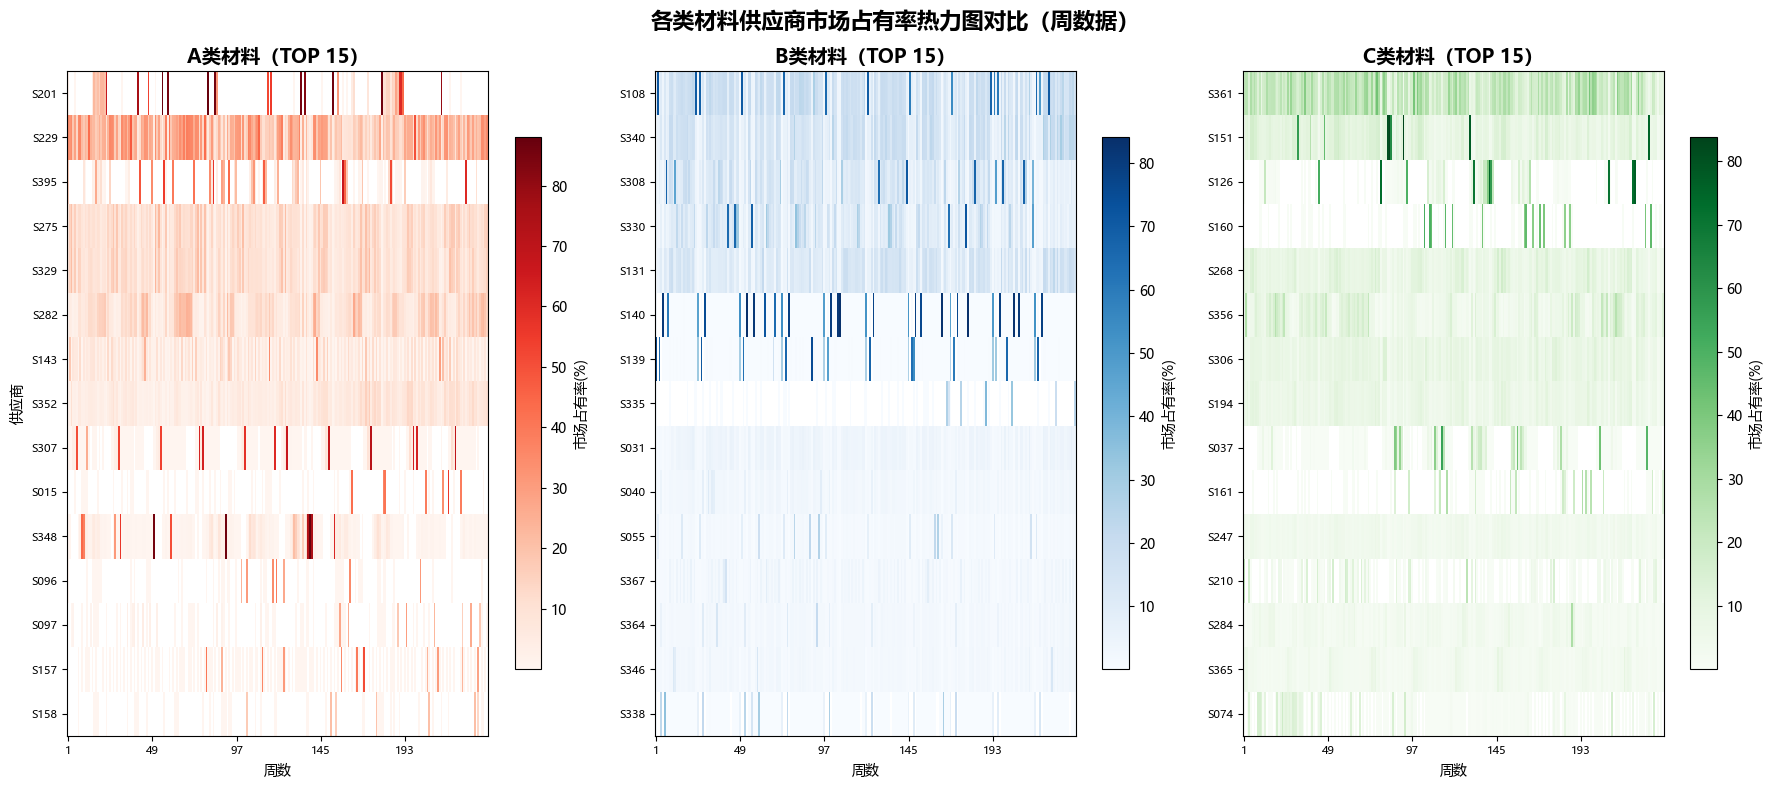


周市场占有率热力分布图绘制完成!
   已保存为SVG格式的矢量图文件

绘制年平均市场占有率热力分布图
数据分析:
  - 总周数: 240
  - 每年周数: 48
  - 完整年数: 5
  - 剩余周数: 0

正在绘制 A 类材料年平均市场占有率热力图...


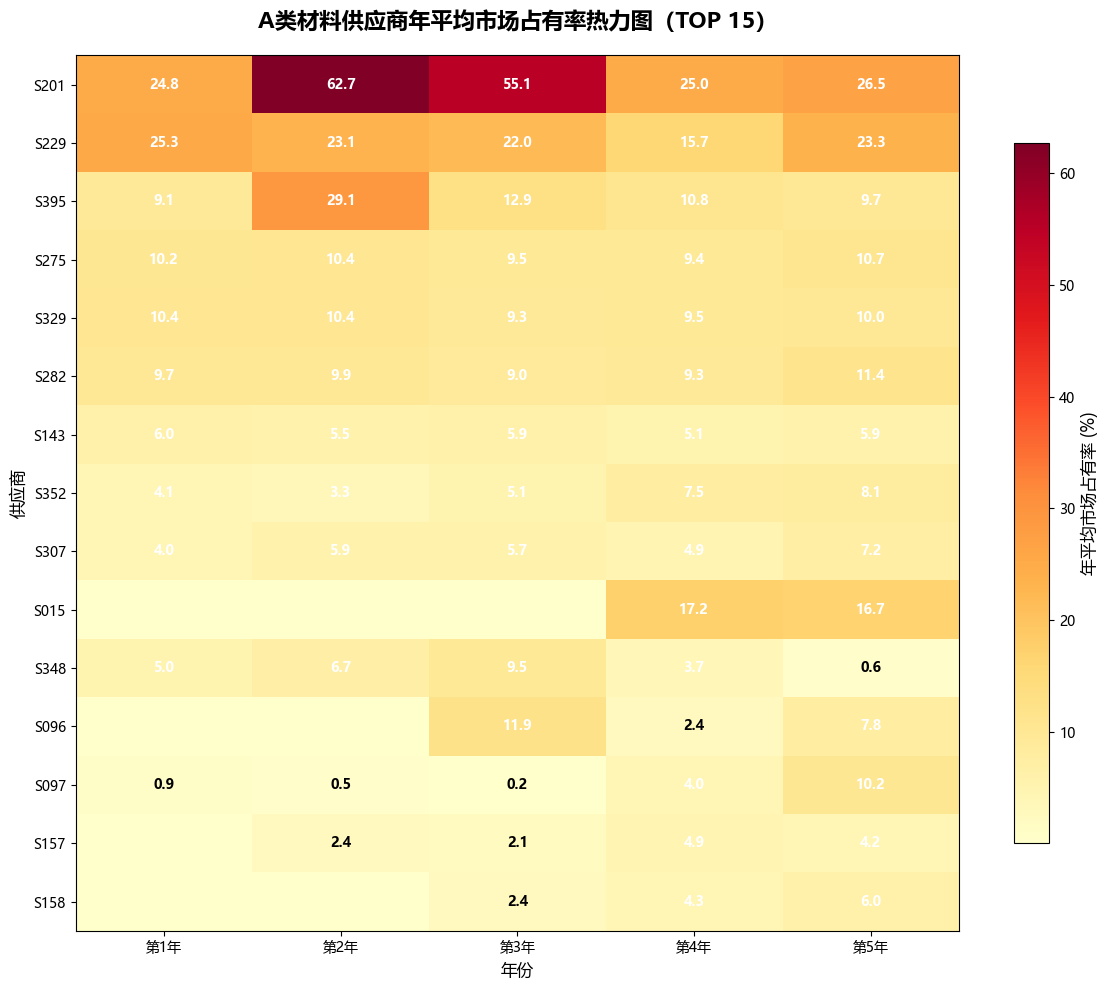

  A 类材料年度市场占有率统计:
    - 分析年数: 5
    - 平均年度市场占有率: 9.76%
    - 最高年度市场占有率: 62.71%
    - 最高表现: S201 (第2年)
    - 市场集中度变化:
      第1年 TOP5占有率: 80.5%
      第2年 TOP5占有率: 135.7%
      第3年 TOP5占有率: 111.5%
      第4年 TOP5占有率: 78.3%
      第5年 TOP5占有率: 88.6%

正在绘制 B 类材料年平均市场占有率热力图...


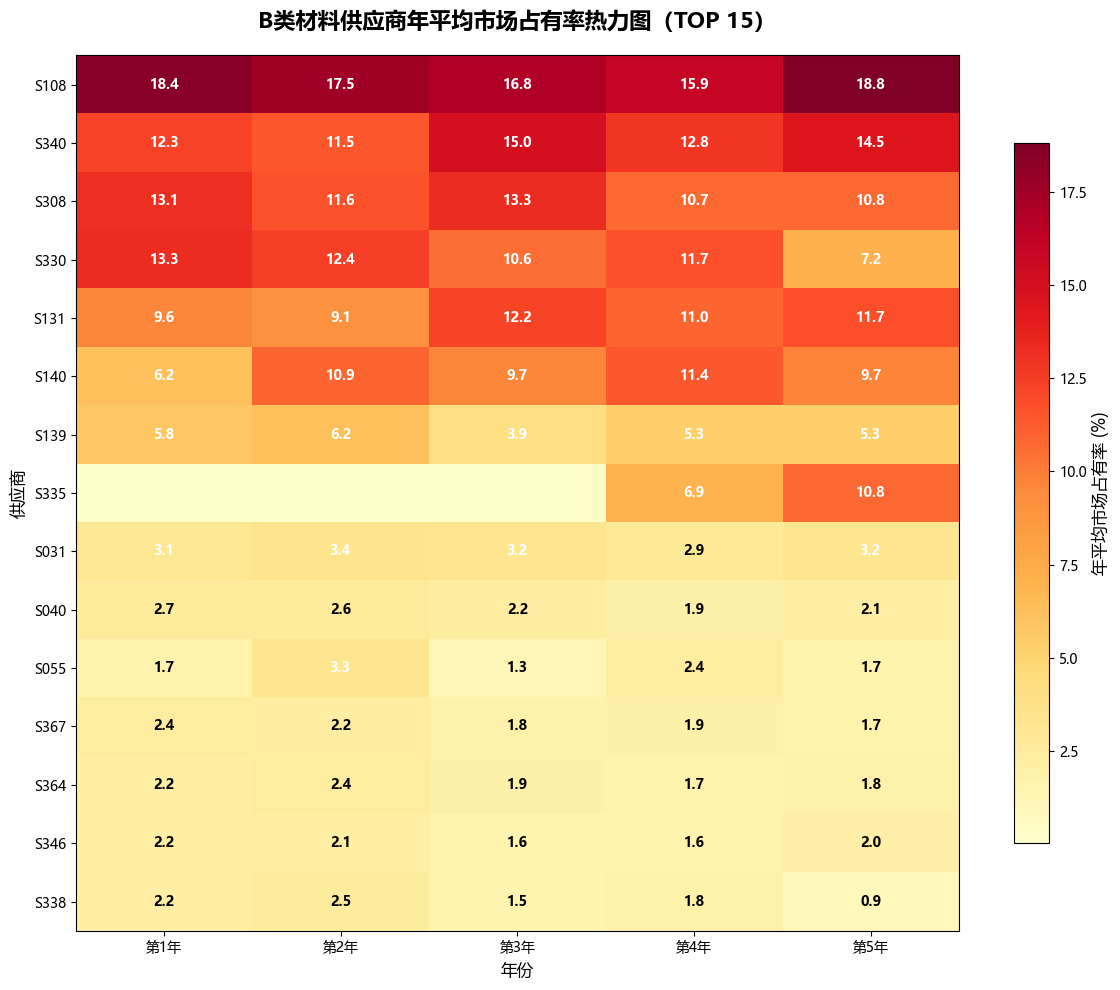

  B 类材料年度市场占有率统计:
    - 分析年数: 5
    - 平均年度市场占有率: 6.54%
    - 最高年度市场占有率: 18.81%
    - 最高表现: S108 (第5年)
    - 市场集中度变化:
      第1年 TOP5占有率: 66.8%
      第2年 TOP5占有率: 63.9%
      第3年 TOP5占有率: 67.9%
      第4年 TOP5占有率: 62.8%
      第5年 TOP5占有率: 66.7%

正在绘制 C 类材料年平均市场占有率热力图...


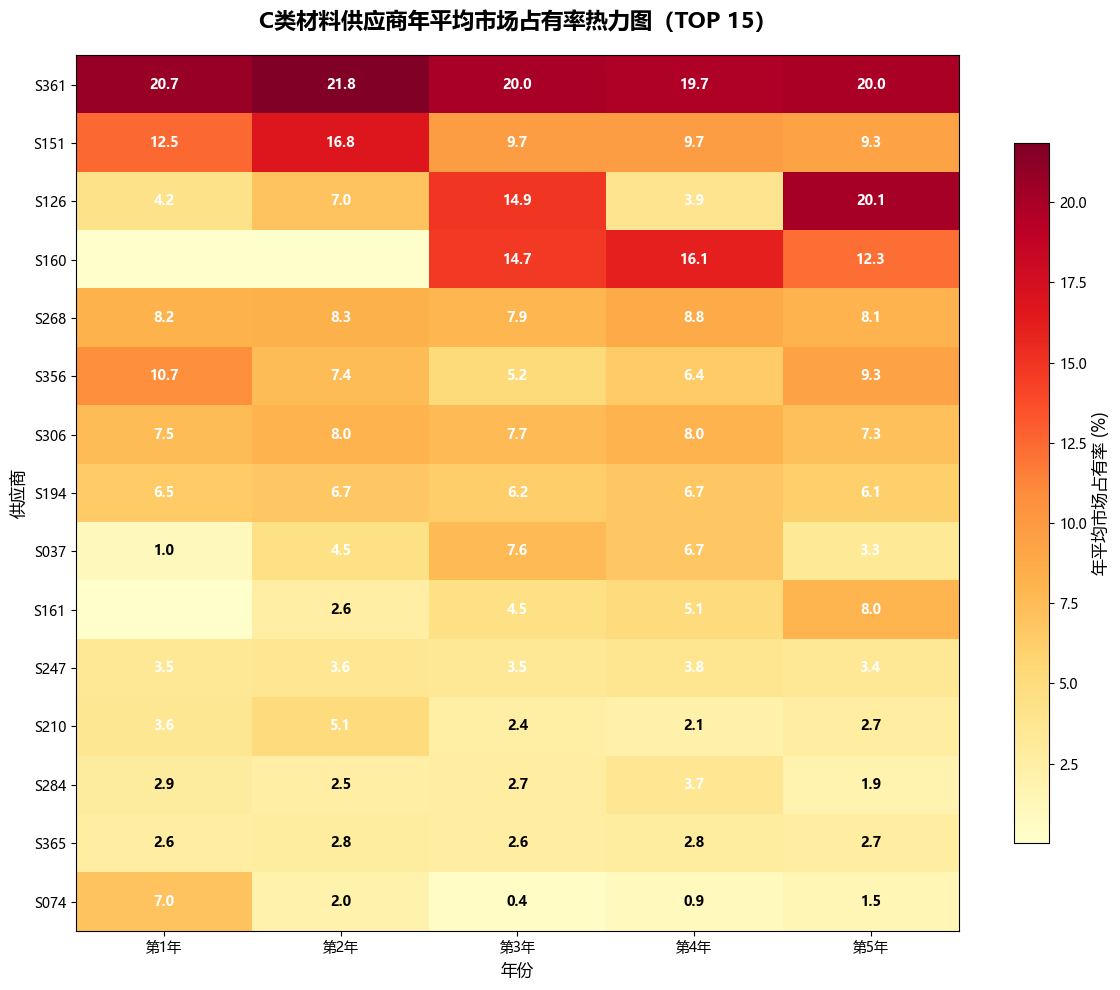

  C 类材料年度市场占有率统计:
    - 分析年数: 5
    - 平均年度市场占有率: 6.94%
    - 最高年度市场占有率: 21.85%
    - 最高表现: S361 (第2年)
    - 市场集中度变化:
      第1年 TOP5占有率: 59.6%
      第2年 TOP5占有率: 62.4%
      第3年 TOP5占有率: 67.3%
      第4年 TOP5占有率: 62.4%
      第5年 TOP5占有率: 71.0%


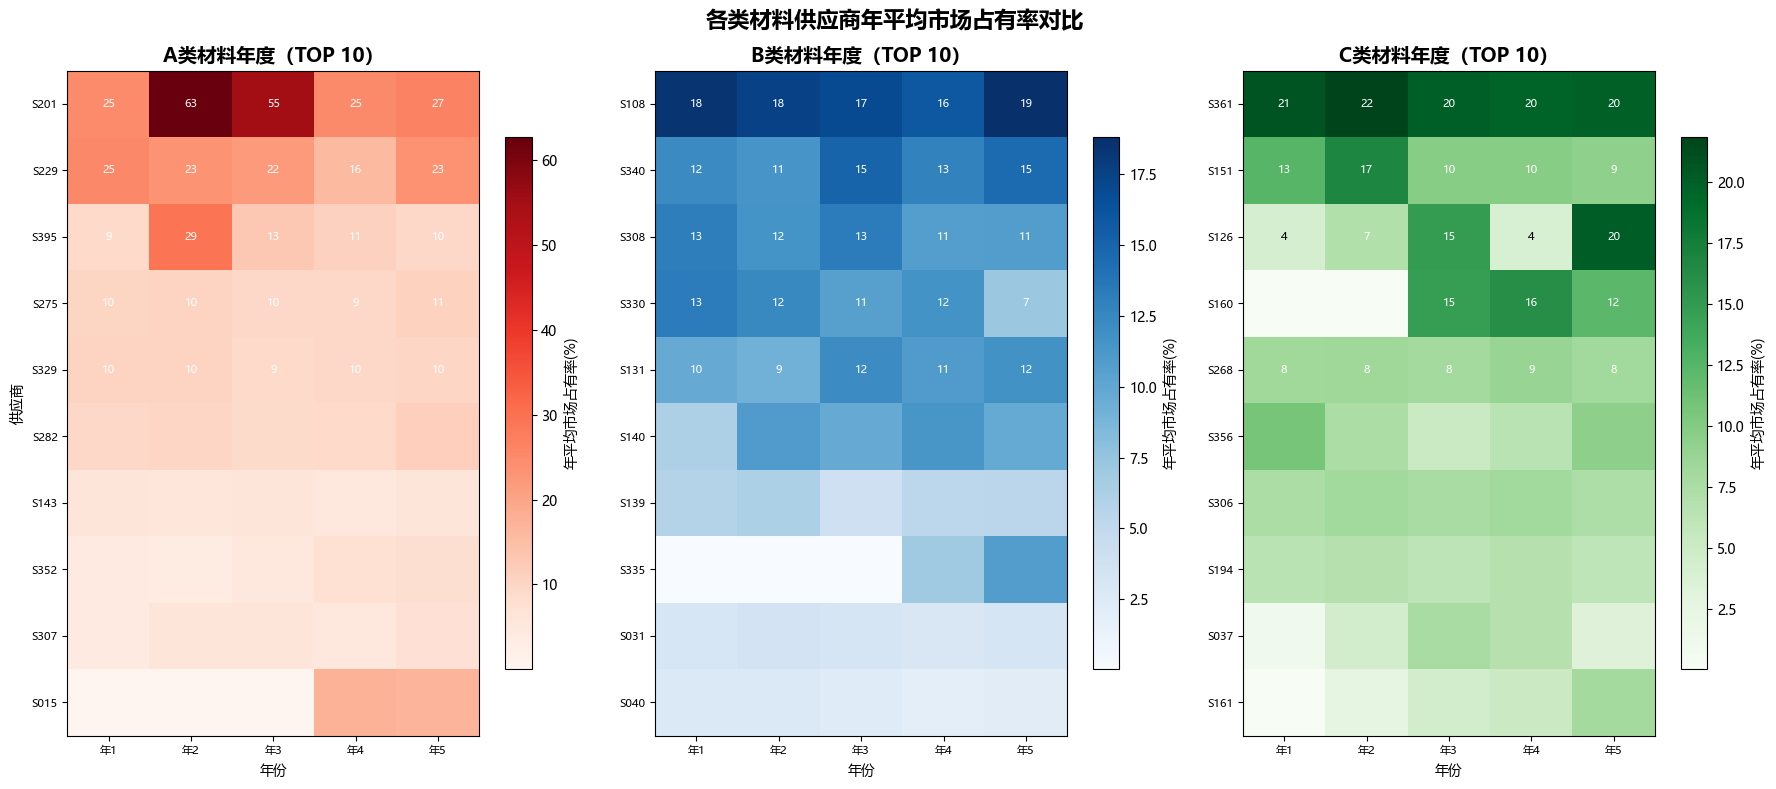


年平均市场占有率热力分布图绘制完成!
   已保存为SVG格式的矢量图文件


In [ ]:
# 绘制市场占有率热力分布图
print("开始绘制市场占有率热力分布图...")
plot_market_share_heatmap(top_n_detail=30, top_n_comparison=15)
plot_yearly_market_share_heatmap(top_n=15)

#### 市场占有率热力图可视化代码

生成市场占有率的热力图可视化，包括分材料类型的详细热力图和对比分析图，帮助直观理解市场竞争状况。

#### 3.2 有效供货率热力图


绘制有效供货率热力分布图（周数据）


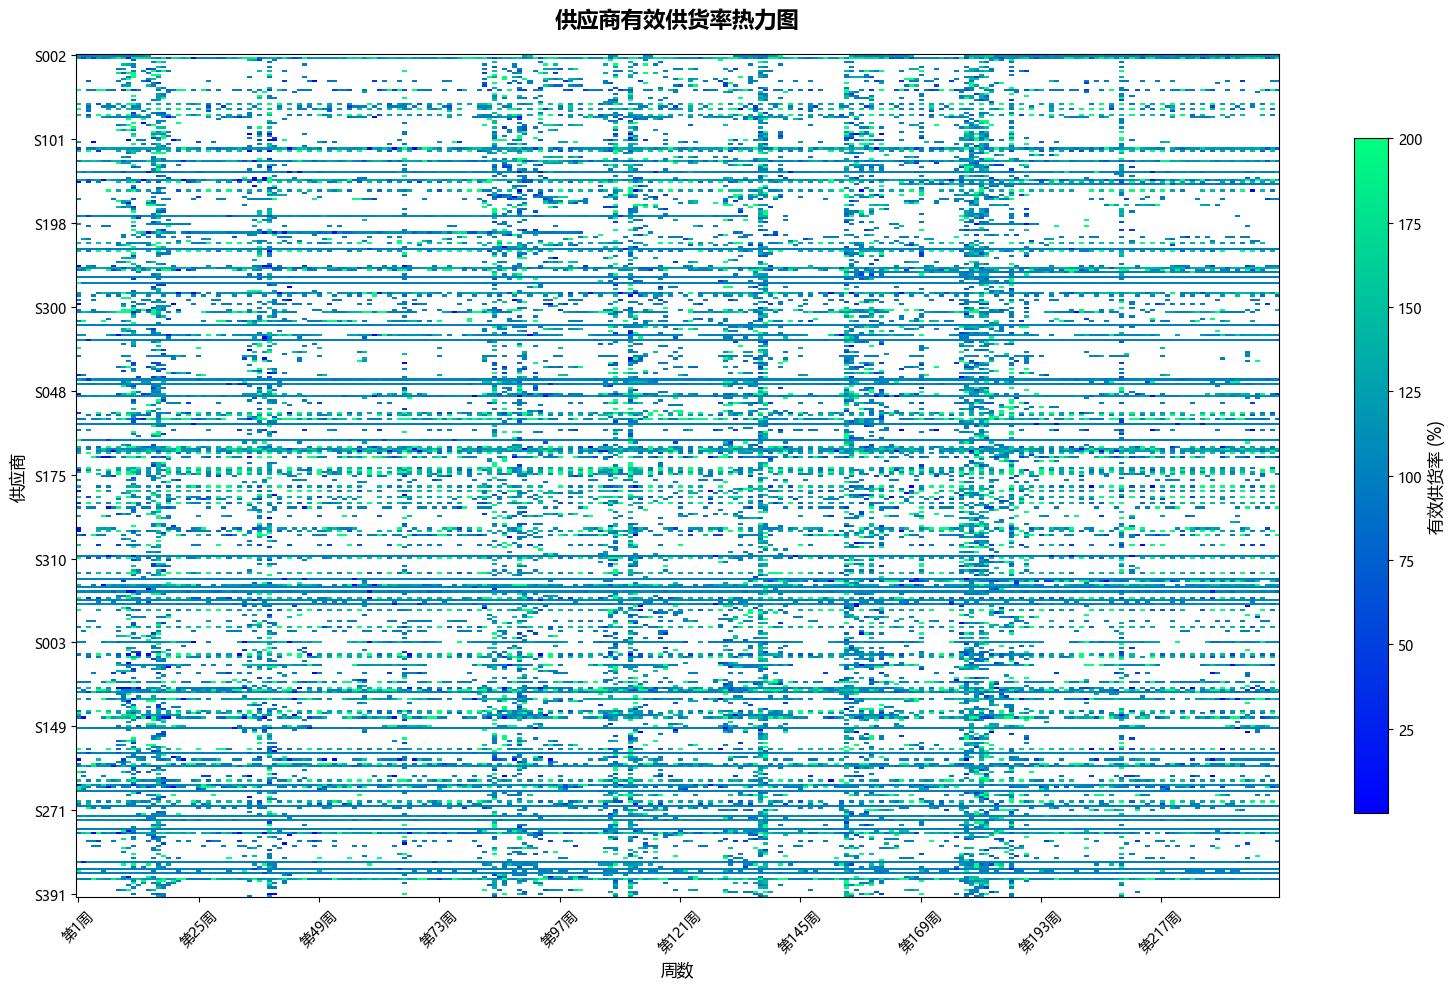

有效供货率热力分布图绘制完成！


In [ ]:
import matplotlib.colors as mcolors

def plot_fulfillment_rate_heatmap():
    """
    绘制供应商有效供货率（订单满足率）热力图
    横轴为周数，纵轴为供应商，颜色为有效供货率（%），0值显示为白色
    """
    print("\n" + "="*60)
    print("绘制有效供货率热力分布图（周数据）")
    print("="*60)

    supplier_metrics_list = []
    for name, metrics in supplier_metrics.items():
        supplier_metrics_list.append({
            'supplier_name': name,
            'material_type': metrics['material_type'],
            'avg_fulfillment_rate': metrics['avg_fulfillment_rate'],
            'weekly_fulfillment_rate': metrics['weekly_fulfillment_rate']
        })
    df_metrics = pd.DataFrame(supplier_metrics_list)

    # 构建热力图数据，0值设为np.nan
    heatmap_data = np.array([np.where(x == 0, np.nan, x * 100) for x in df_metrics['weekly_fulfillment_rate']])
    supplier_names = df_metrics['supplier_name'].tolist()
    weeks = heatmap_data.shape[1]

    # 自定义colormap，NaN为白色
    cmap = plt.get_cmap('winter').copy()
    cmap.set_bad(color='white')

    plt.figure(figsize=(16, 10))
    im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
    plt.title(f'供应商有效供货率热力图', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('周数', fontsize=12)
    plt.ylabel('供应商', fontsize=12)
    y_ticks = range(0, len(supplier_names), max(1, len(supplier_names)//10))
    plt.yticks(y_ticks, [supplier_names[i] for i in y_ticks], fontsize=10)
    x_ticks = range(0, weeks, max(1, weeks//10))
    plt.xticks(x_ticks, [f'第{i+1}周' for i in x_ticks], rotation=45, fontsize=10)
    cbar = plt.colorbar(im, shrink=0.8)
    cbar.set_label('有效供货率 (%)', fontsize=12)
    plt.tight_layout()
    plt.savefig('Pictures/fulfillment_rate_heatmap.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    print("有效供货率热力分布图绘制完成！")

# 调用函数
plot_fulfillment_rate_heatmap()

#### 供货规模热力图可视化代码

创建供货规模的热力图分析，展示各供应商的供货量分布情况，包括分材料类型的规模对比和整体规模分析。

#### 3.3 年度供货效率柱状图

绘制年度供货效率柱状图（前30名供应商）
数据分析:
  - 总周数: 240
  - 每年周数: 48
  - 完整年数: 5

前50名供应商材料类型分布:
material_type
C    20
A    16
B    14
Name: count, dtype: int64


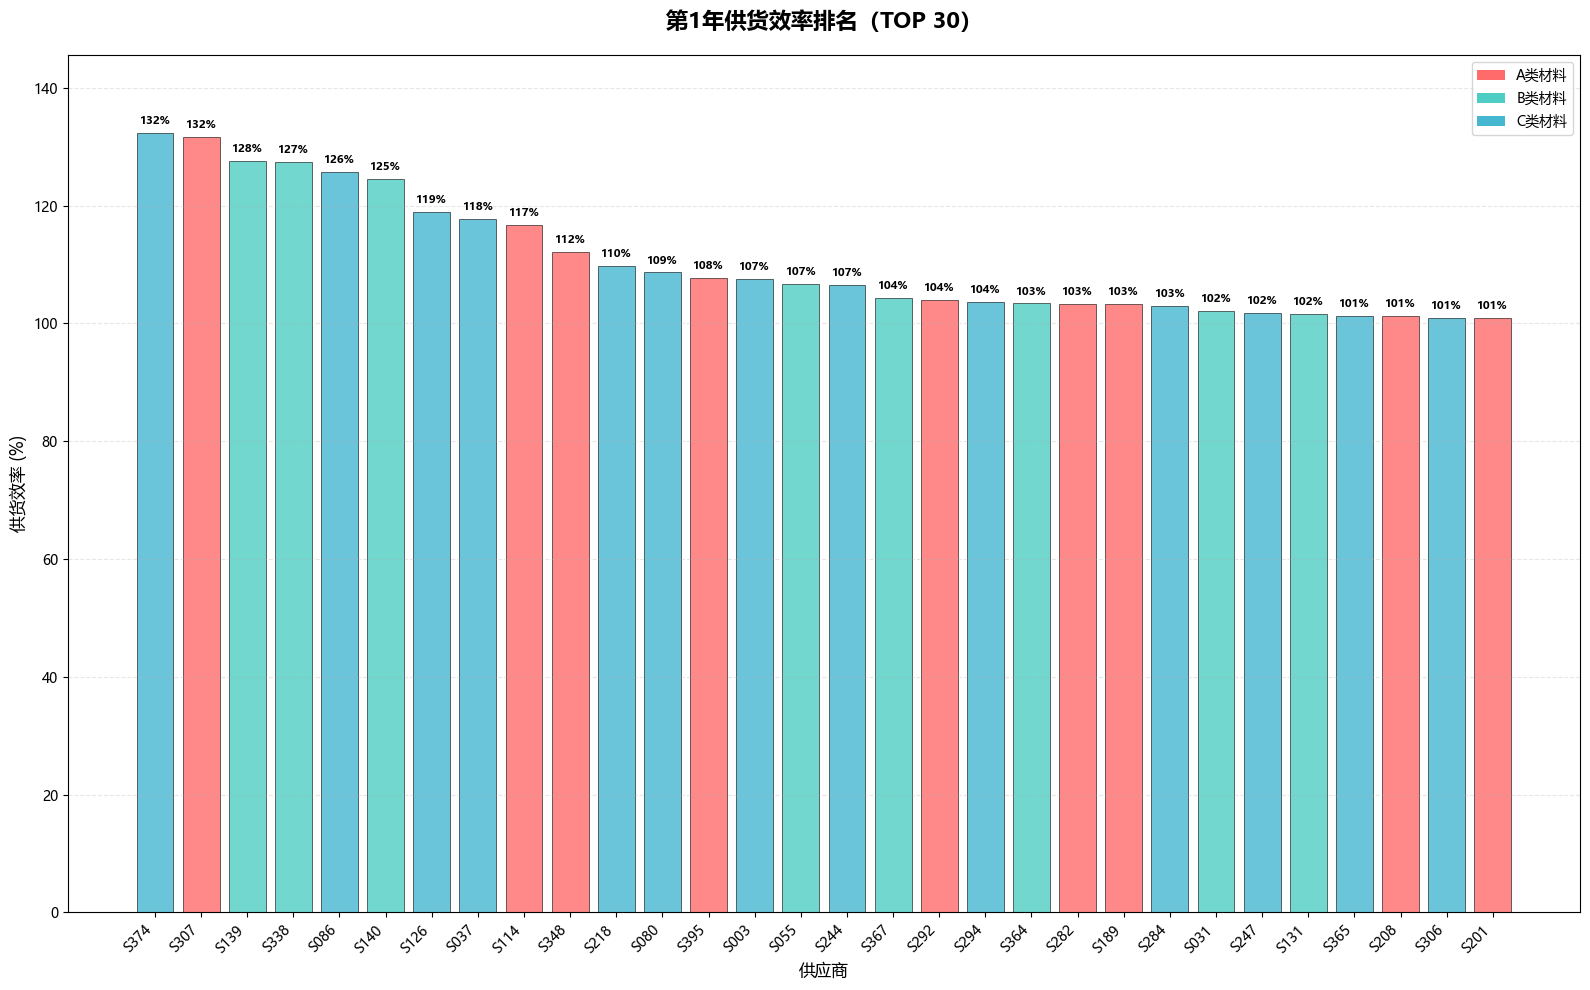

第1年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_1.svg


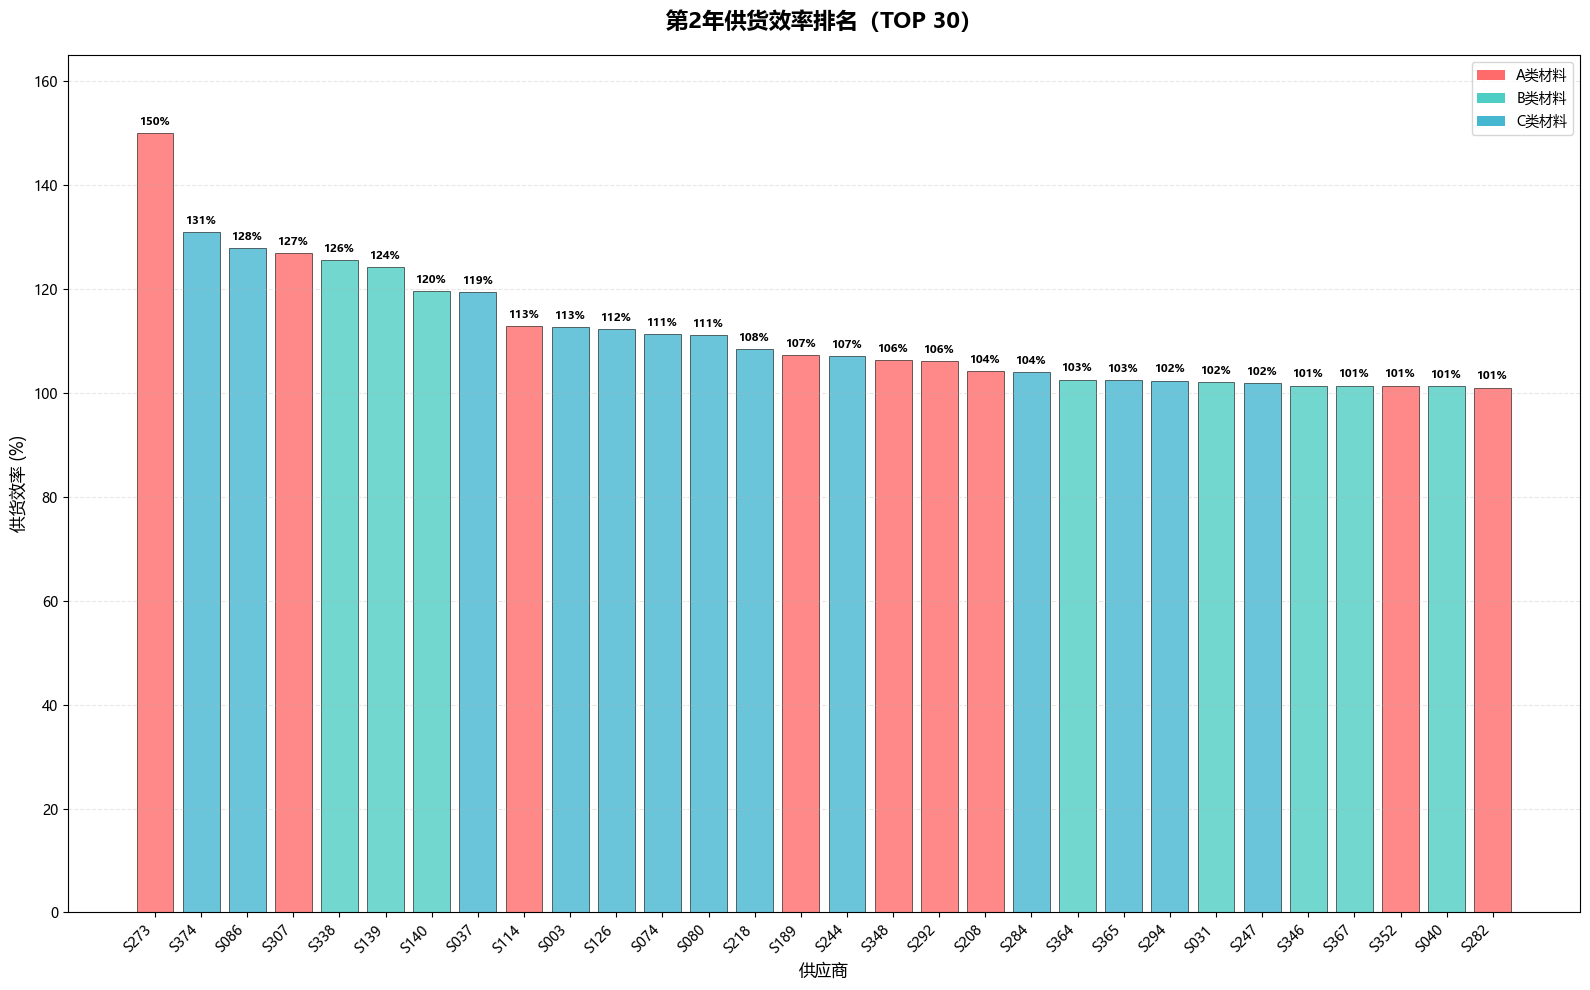

第2年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_2.svg


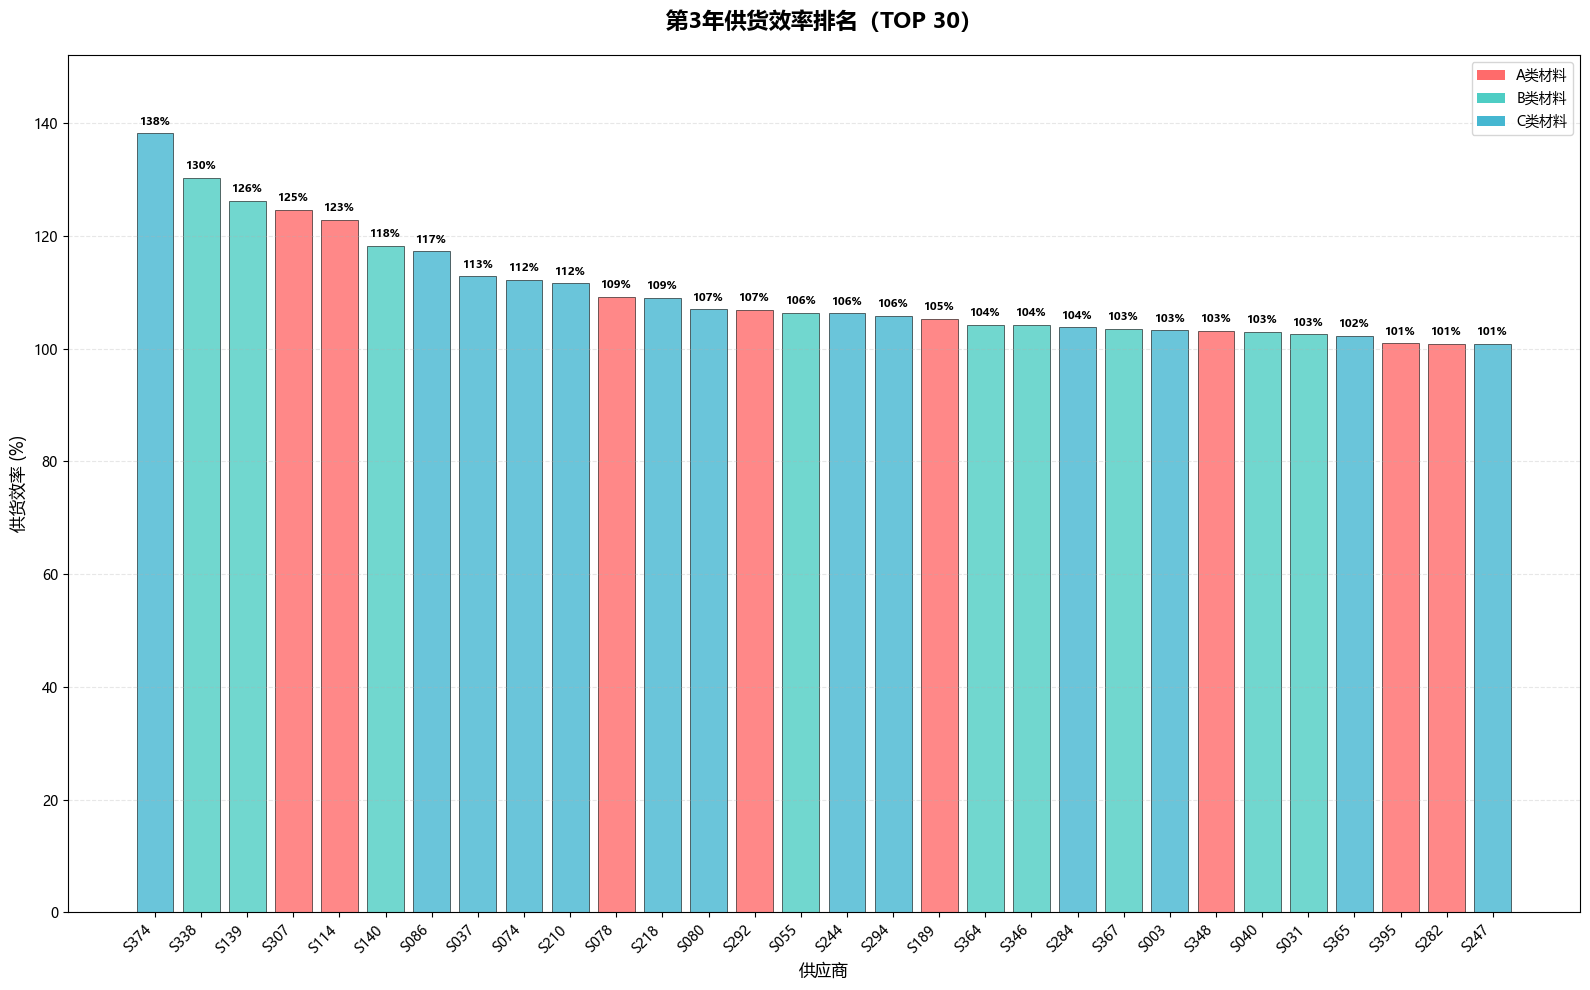

第3年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_3.svg


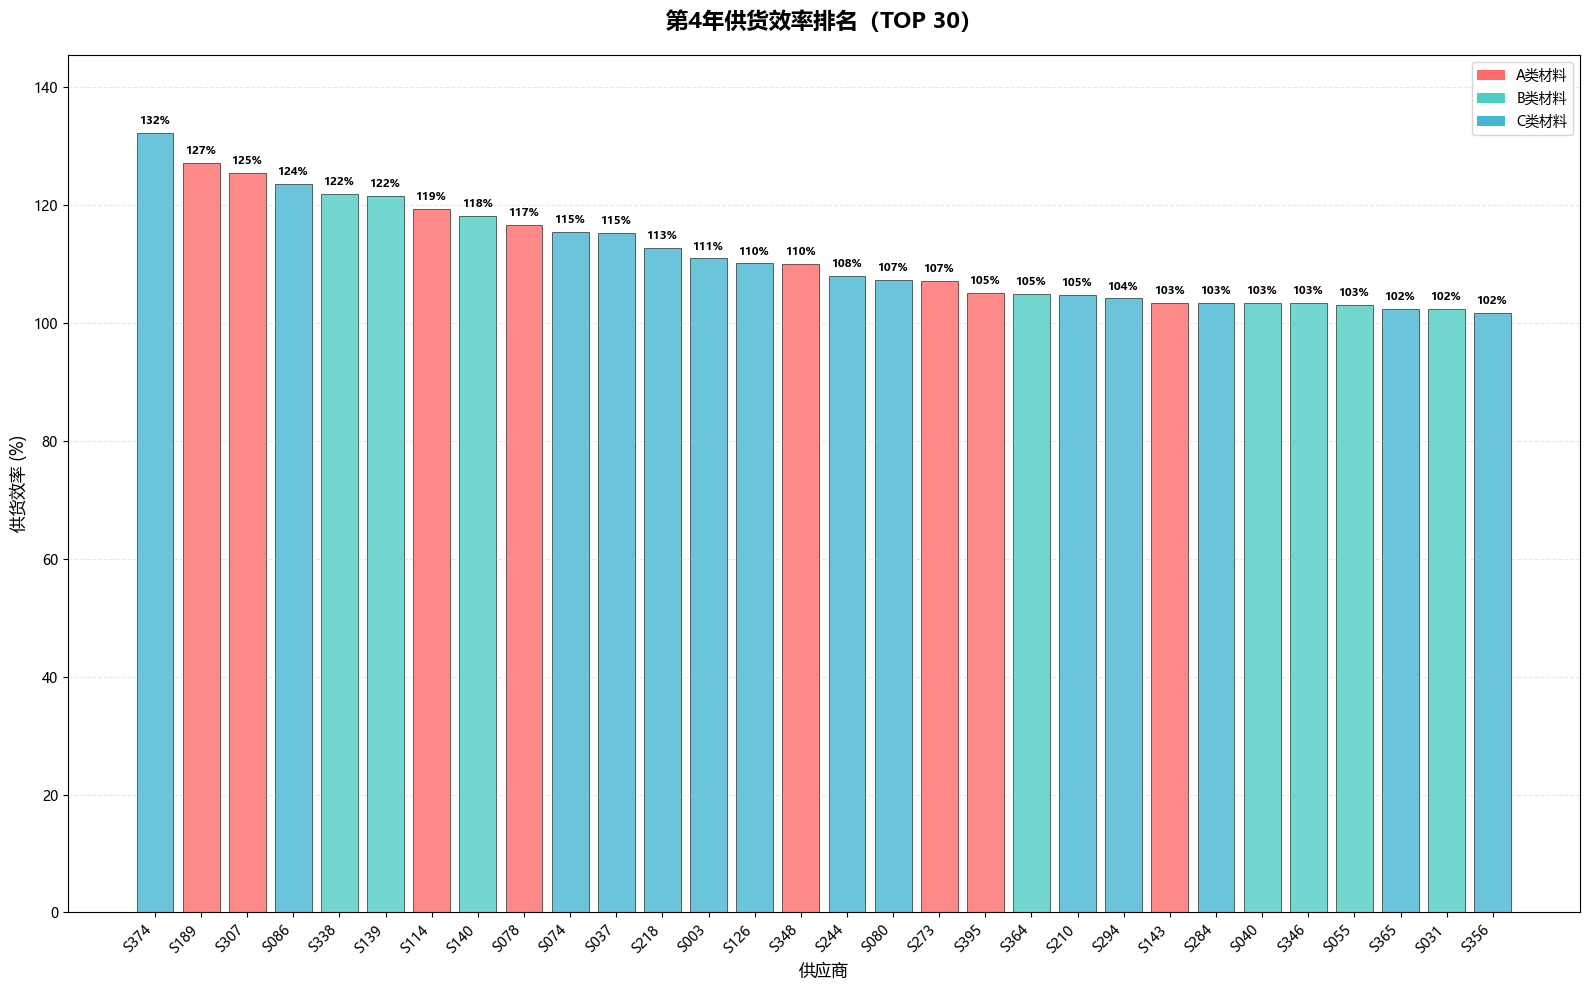

第4年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_4.svg


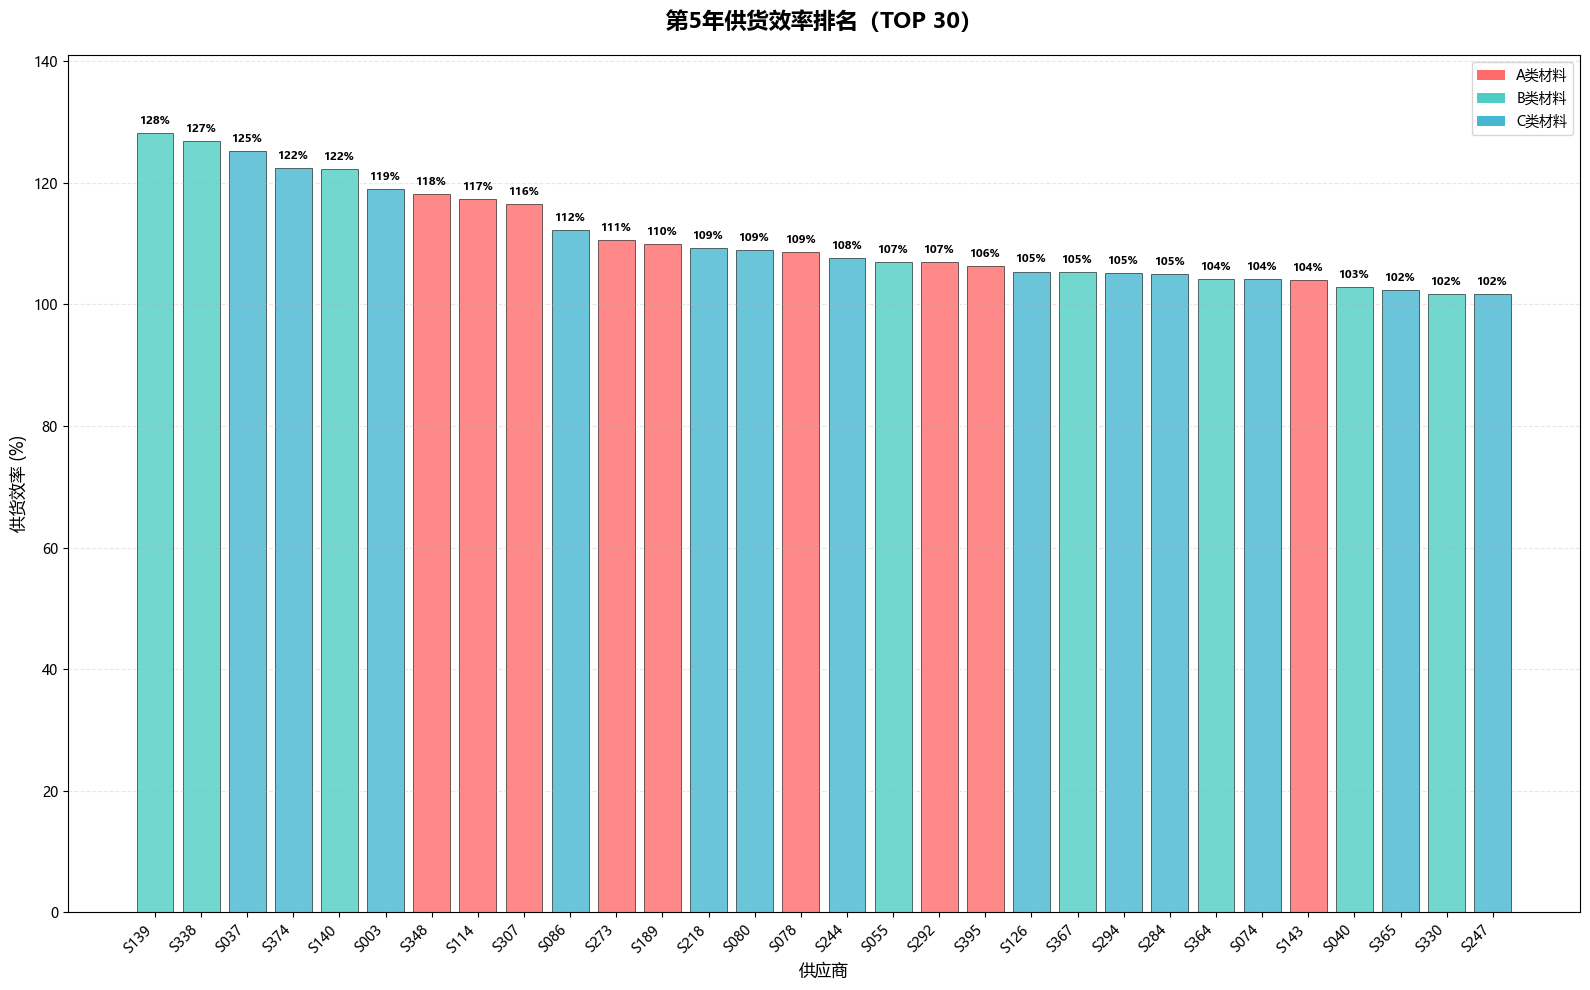

第5年供货效率图表已保存: Pictures/yearly_fulfillment_efficiency_year_5.svg

绘制TOP30供应商年度效率趋势图...


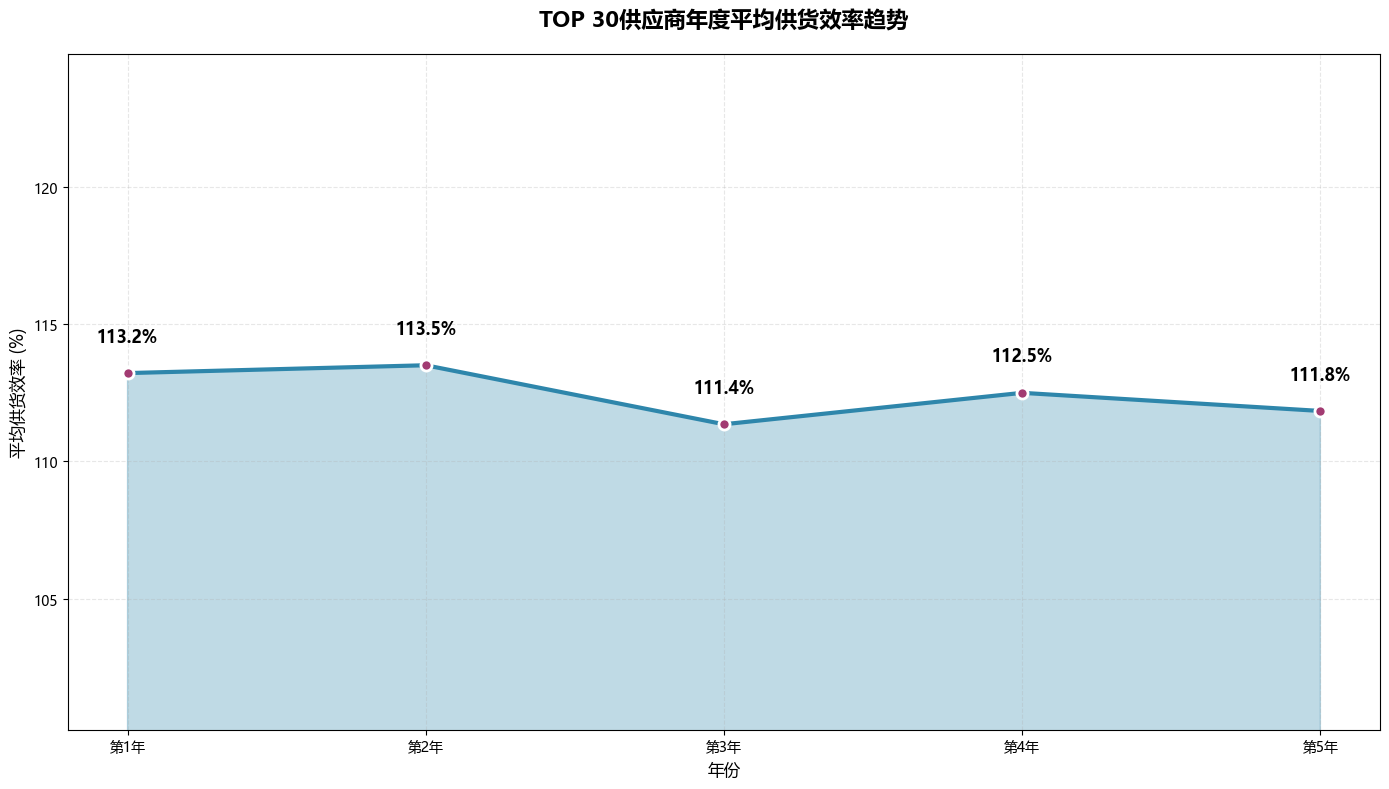


年度供货效率统计分析:
  - 分析年数: 5
  - 每年分析供应商数量: 30

  A类材料供应商表现:
    - 平均供货效率: 112.51%
    - 最高供货效率: 150.00%
    - 最佳供应商: S273

  B类材料供应商表现:
    - 平均供货效率: 112.54%
    - 最高供货效率: 130.25%
    - 最佳供应商: S338

  C类材料供应商表现:
    - 平均供货效率: 112.36%
    - 最高供货效率: 138.18%
    - 最佳供应商: S374

  年度效率趋势（TOP 30平均）:
    第1年: 113.22%
    第2年: 113.51%
    第3年: 111.36%
    第4年: 112.50%
    第5年: 111.84%
    整体趋势: -1.38% (下降)

年度供货效率柱状图绘制完成!
   已保存为SVG格式的矢量图文件


In [ ]:
def plot_yearly_fulfillment_efficiency_bar_chart():
    """
    绘制年度供货效率柱状图（前30名供应商，每年单独一张图）
    
    参数:
    top_n: 显示的供应商数量 (默认30)
    """
    
    print("="*60)
    print("绘制年度供货效率柱状图（前30名供应商）")
    print("="*60)
    
    # 计算年数和每年的数据
    def calculate_yearly_efficiency_data():
        """计算每年的供货效率数据"""
        
        # 获取总周数
        first_supplier = list(supplier_metrics.values())[0]
        total_weeks = len(first_supplier['weekly_fulfillment_rate'])
        weeks_per_year = 48
        years = total_weeks // weeks_per_year
        
        print(f"数据分析:")
        print(f"  - 总周数: {total_weeks}")
        print(f"  - 每年周数: {weeks_per_year}")
        print(f"  - 完整年数: {years}")
        
        # 筛选前50名供应商（使用supplier_analysis数据）
        top_50_suppliers = supplier_analysis.nlargest(50, 'total_supply')
        
        print(f"\n前50名供应商材料类型分布:")
        import pandas as pd
        print(top_50_suppliers['material_type'].value_counts())
        
        # 为每年计算供应商的平均供货效率
        yearly_efficiency_data = {}
        
        for year in range(years):
            start_week = year * weeks_per_year
            end_week = (year + 1) * weeks_per_year
            
            supplier_year_efficiency = []
            
            for _, supplier_row in top_50_suppliers.iterrows():
                supplier_name = supplier_row['supplier_name']
                
                # 从supplier_metrics获取该供应商的周效率数据
                if supplier_name in supplier_metrics:
                    metrics = supplier_metrics[supplier_name]
                    
                    # 获取该年的周供货效率数据
                    year_efficiency = metrics['weekly_fulfillment_rate'][start_week:end_week]
                    
                    # 计算该年平均供货效率（只考虑非零值）
                    non_zero_efficiency = year_efficiency[year_efficiency > 0]
                    if len(non_zero_efficiency) > 0:
                        avg_efficiency = np.mean(non_zero_efficiency) * 100  # 转换为百分比
                    else:
                        avg_efficiency = 0
                    
                    supplier_year_efficiency.append({
                        'supplier_name': supplier_name,
                        'material_type': metrics['material_type'],
                        'efficiency': avg_efficiency,
                        'total_supply': supplier_row['total_supply']
                    })
            
            # 按效率排序，选择前30名
            supplier_year_efficiency.sort(key=lambda x: x['efficiency'], reverse=True)
            yearly_efficiency_data[year] = supplier_year_efficiency[:30]
        
        return yearly_efficiency_data, years
    
    # 计算年度数据
    yearly_data, years = calculate_yearly_efficiency_data()
    
    if years < 1:
        print("数据不足一年，无法绘制年度效率图")
        return
    
    # 为每年绘制单独的图表
    for year in range(years):
        year_data = yearly_data[year]
        
        if not year_data:
            continue
        
        # 创建图表
        plt.figure(figsize=(16, 10))
        
        # 准备数据
        suppliers = [item['supplier_name'] for item in year_data]
        efficiencies = [item['efficiency'] for item in year_data]
        materials = [item['material_type'] for item in year_data]
        
        # 为不同材料类型设置颜色
        colors = ['#FF6B6B' if mat == 'A' else '#4ECDC4' if mat == 'B' else '#45B7D1' for mat in materials]
        
        # 绘制柱状图
        bars = plt.bar(range(len(suppliers)), efficiencies, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # 设置图表属性
        plt.title(f'第{year+1}年供货效率排名（TOP 30）', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('供应商', fontsize=12)
        plt.ylabel('供货效率 (%)', fontsize=12)
        
        # 设置x轴标签
        plt.xticks(range(len(suppliers)), suppliers, rotation=45, ha='right', fontsize=10)
        
        # 添加网格
        plt.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 添加数值标签
        for i, (bar, efficiency) in enumerate(zip(bars, efficiencies)):
            if efficiency > 0:
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{efficiency:.0f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # 添加图例
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#FF6B6B', label='A类材料'),
            Patch(facecolor='#4ECDC4', label='B类材料'),
            Patch(facecolor='#45B7D1', label='C类材料')
        ]
        plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
        
        # 设置y轴范围
        plt.ylim(0, max(efficiencies) * 1.1 if efficiencies else 100)
        
        # 调整布局
        plt.tight_layout()
        
        # 保存图片
        filename = f'Pictures/yearly_fulfillment_efficiency_year_{year+1}.svg'
        plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"第{year+1}年供货效率图表已保存: {filename}")
    
    # 绘制TOP30趋势图
    print("\n绘制TOP30供应商年度效率趋势图...")
    
    # 计算整体效率最高的30名供应商
    all_supplier_avg_efficiency = {}
    
    for year in range(years):
        year_data = yearly_data[year]
        for item in year_data:
            supplier = item['supplier_name']
            if supplier not in all_supplier_avg_efficiency:
                all_supplier_avg_efficiency[supplier] = []
            all_supplier_avg_efficiency[supplier].append(item['efficiency'])
    
    # 计算每个供应商的平均效率
    supplier_overall_avg = {}
    for supplier, efficiencies in all_supplier_avg_efficiency.items():
        supplier_overall_avg[supplier] = np.mean(efficiencies)
    
    # 选择TOP30
    top_30_suppliers = sorted(supplier_overall_avg.items(), key=lambda x: x[1], reverse=True)[:30]
    top_30_names = [item[0] for item in top_30_suppliers]
    
    # 绘制趋势图
    plt.figure(figsize=(14, 8))
    
    # 计算每年的平均效率
    yearly_averages = []
    for year in range(years):
        year_efficiencies = []
        year_data = yearly_data[year]
        
        for item in year_data:
            if item['supplier_name'] in top_30_names:
                year_efficiencies.append(item['efficiency'])
        
        if year_efficiencies:
            yearly_averages.append(np.mean(year_efficiencies))
        else:
            yearly_averages.append(0)
    
    # 绘制趋势线
    years_labels = [f'第{i+1}年' for i in range(years)]
    plt.plot(years_labels, yearly_averages, marker='o', linewidth=3, markersize=8, 
             color='#2E86AB', markerfacecolor='#A23B72', markeredgecolor='white', markeredgewidth=2)
    
    # 填充区域
    plt.fill_between(years_labels, yearly_averages, alpha=0.3, color='#2E86AB')
    
    # 添加数值标签
    for i, avg in enumerate(yearly_averages):
        plt.text(i, avg + 1, f'{avg:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 设置图表属性
    plt.title('TOP 30供应商年度平均供货效率趋势', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('年份', fontsize=12)
    plt.ylabel('平均供货效率 (%)', fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # 设置y轴范围
    if yearly_averages:
        y_min = min(yearly_averages) * 0.9
        y_max = max(yearly_averages) * 1.1
        plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.savefig('Pictures/top30_yearly_efficiency_trend.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 统计分析
    print(f"\n年度供货效率统计分析:")
    print(f"  - 分析年数: {years}")
    print(f"  - 每年分析供应商数量: 30")
    
    # 分材料类型统计
    for material in ['A', 'B', 'C']:
        material_efficiencies = []
        material_suppliers = []
        
        for year in range(years):
            year_data = yearly_data[year]
            for item in year_data:
                if item['material_type'] == material and item['supplier_name'] in top_30_names:
                    material_efficiencies.append(item['efficiency'])
                    material_suppliers.append(item['supplier_name'])
        
        if material_efficiencies:
            avg_efficiency = np.mean(material_efficiencies)
            max_efficiency = max(material_efficiencies)
            best_supplier_idx = material_efficiencies.index(max_efficiency)
            best_supplier = material_suppliers[best_supplier_idx]
            
            print(f"\n  {material}类材料供应商表现:")
            print(f"    - 平均供货效率: {avg_efficiency:.2f}%")
            print(f"    - 最高供货效率: {max_efficiency:.2f}%")
            print(f"    - 最佳供应商: {best_supplier}")
    
    # 年度趋势分析
    if len(yearly_averages) > 1:
        trend = yearly_averages[-1] - yearly_averages[0]
        print(f"\n  年度效率趋势（TOP 30平均）:")
        for i, avg in enumerate(yearly_averages):
            print(f"    第{i+1}年: {avg:.2f}%")
        print(f"    整体趋势: {'+' if trend > 0 else ''}{trend:.2f}% ({'提升' if trend > 0 else '下降'})")
    
    print(f"\n年度供货效率柱状图绘制完成!")
    print(f"   已保存为SVG格式的矢量图文件")

# 调用函数绘制年度供货效率柱状图
plot_yearly_fulfillment_efficiency_bar_chart()

#### 生产制造能力分析代码

分析各供应商的生产制造能力，包括订货规模分析和生产能力评估，为供应商选择和产能规划提供数据支持。

### 4. 产品制造能力分析

开始产品制造能力分析...
完成402家供应商的产品制造能力分析
  A类材料 (146家供应商):
    总产品制造能力: 2,421,762 m³
    平均周产品制造能力: 118.3 m³
    最大周产品制造能力: 61,620 m³
  B类材料 (134家供应商):
    总产品制造能力: 2,270,700 m³
    平均周产品制造能力: 77.5 m³
    最大周产品制造能力: 32,262 m³
  C类材料 (122家供应商):
    总产品制造能力: 2,011,510 m³
    平均周产品制造能力: 78.4 m³
    最大周产品制造能力: 32,910 m³
正在绘制A类材料产品制造能力热力图...


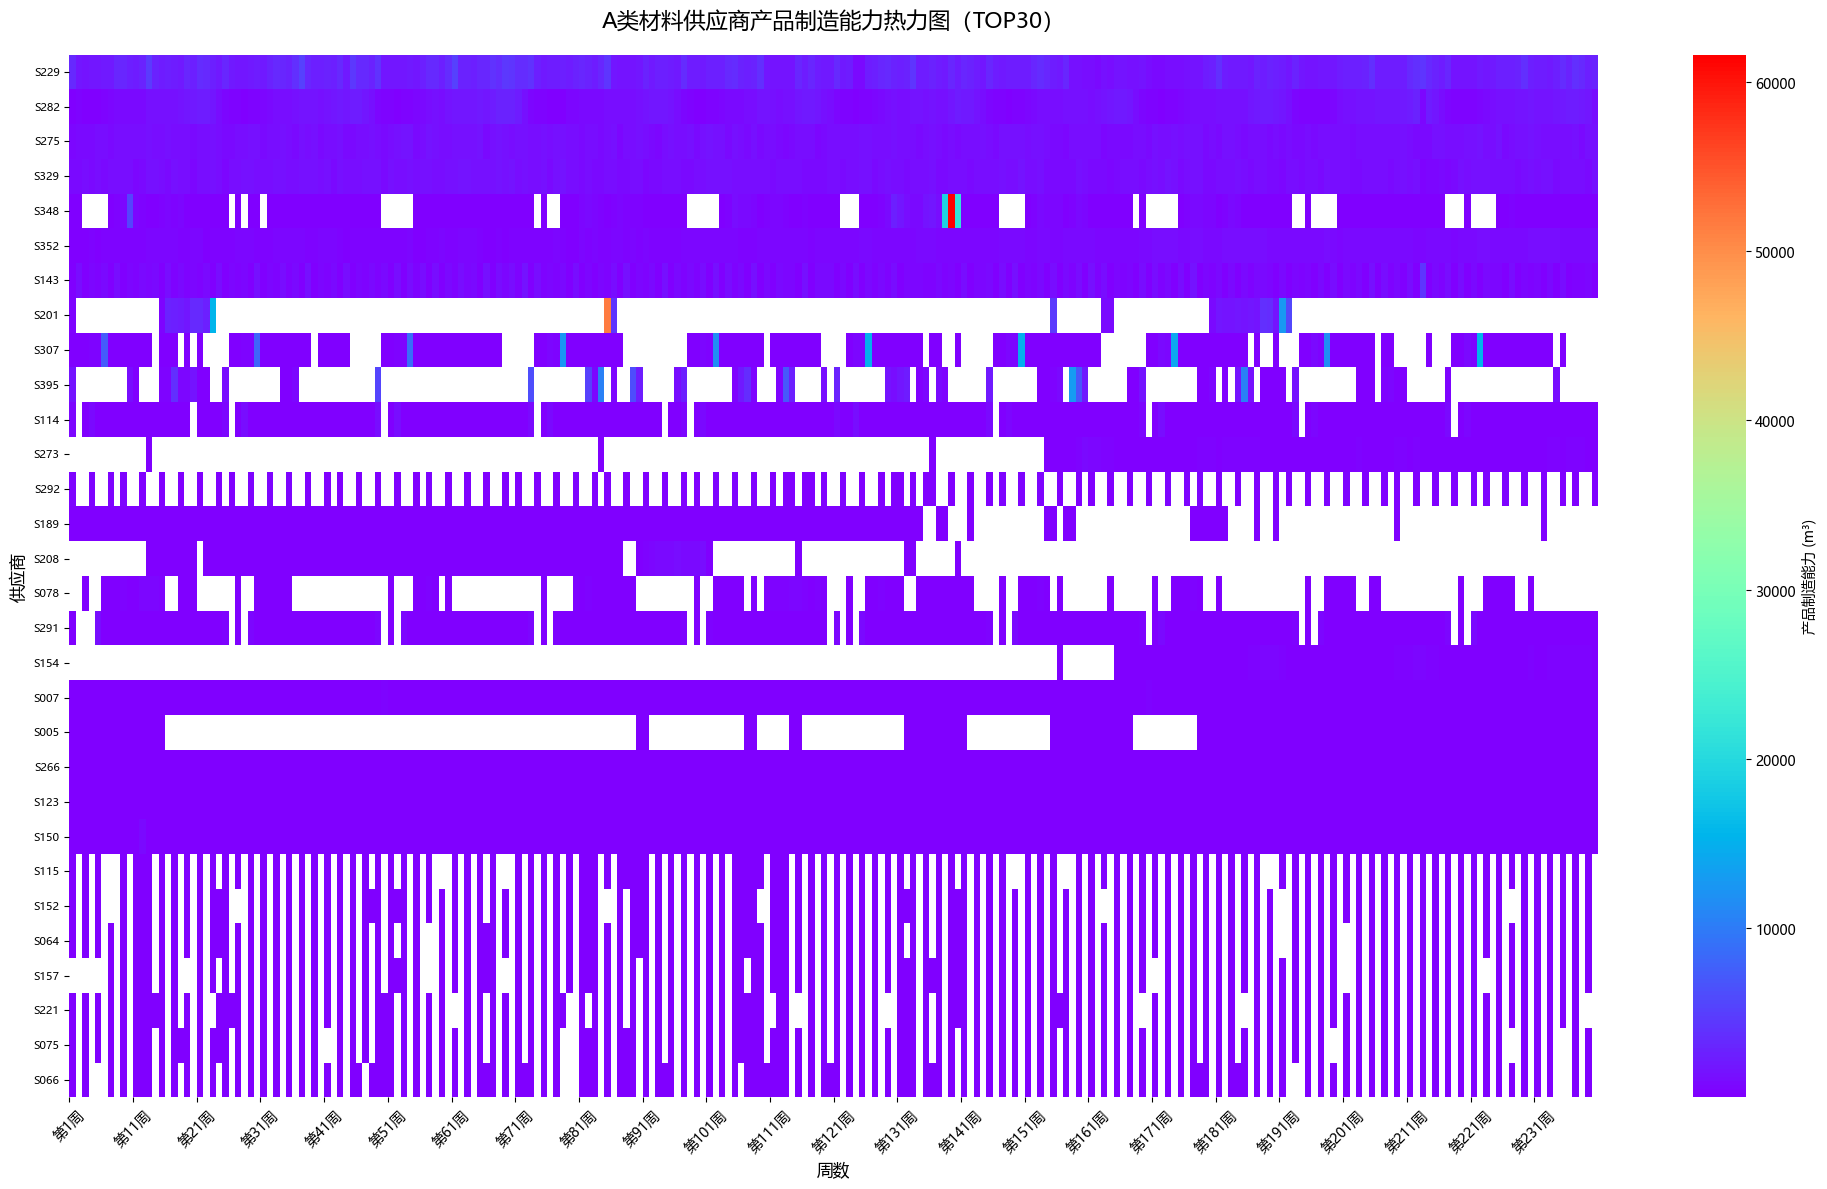

正在绘制B类材料产品制造能力热力图...


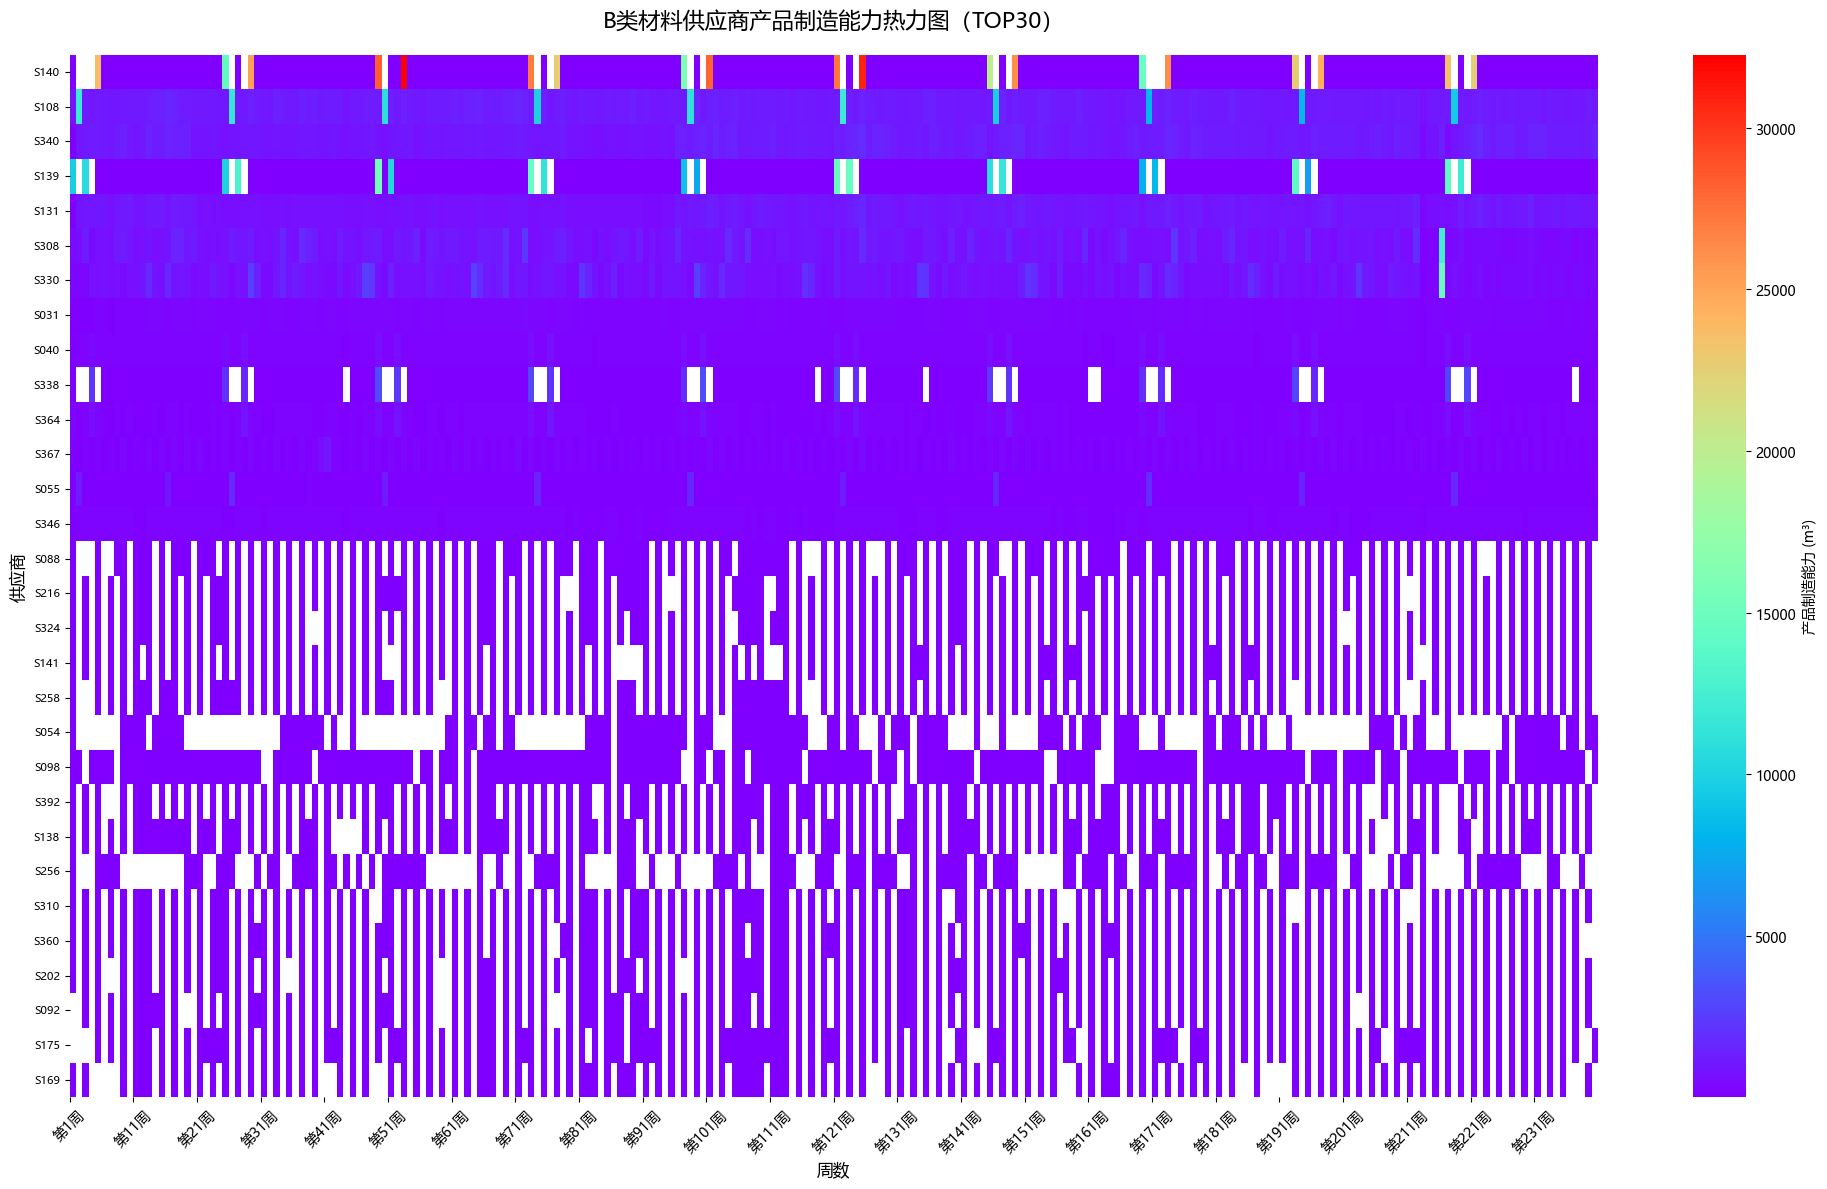

正在绘制C类材料产品制造能力热力图...


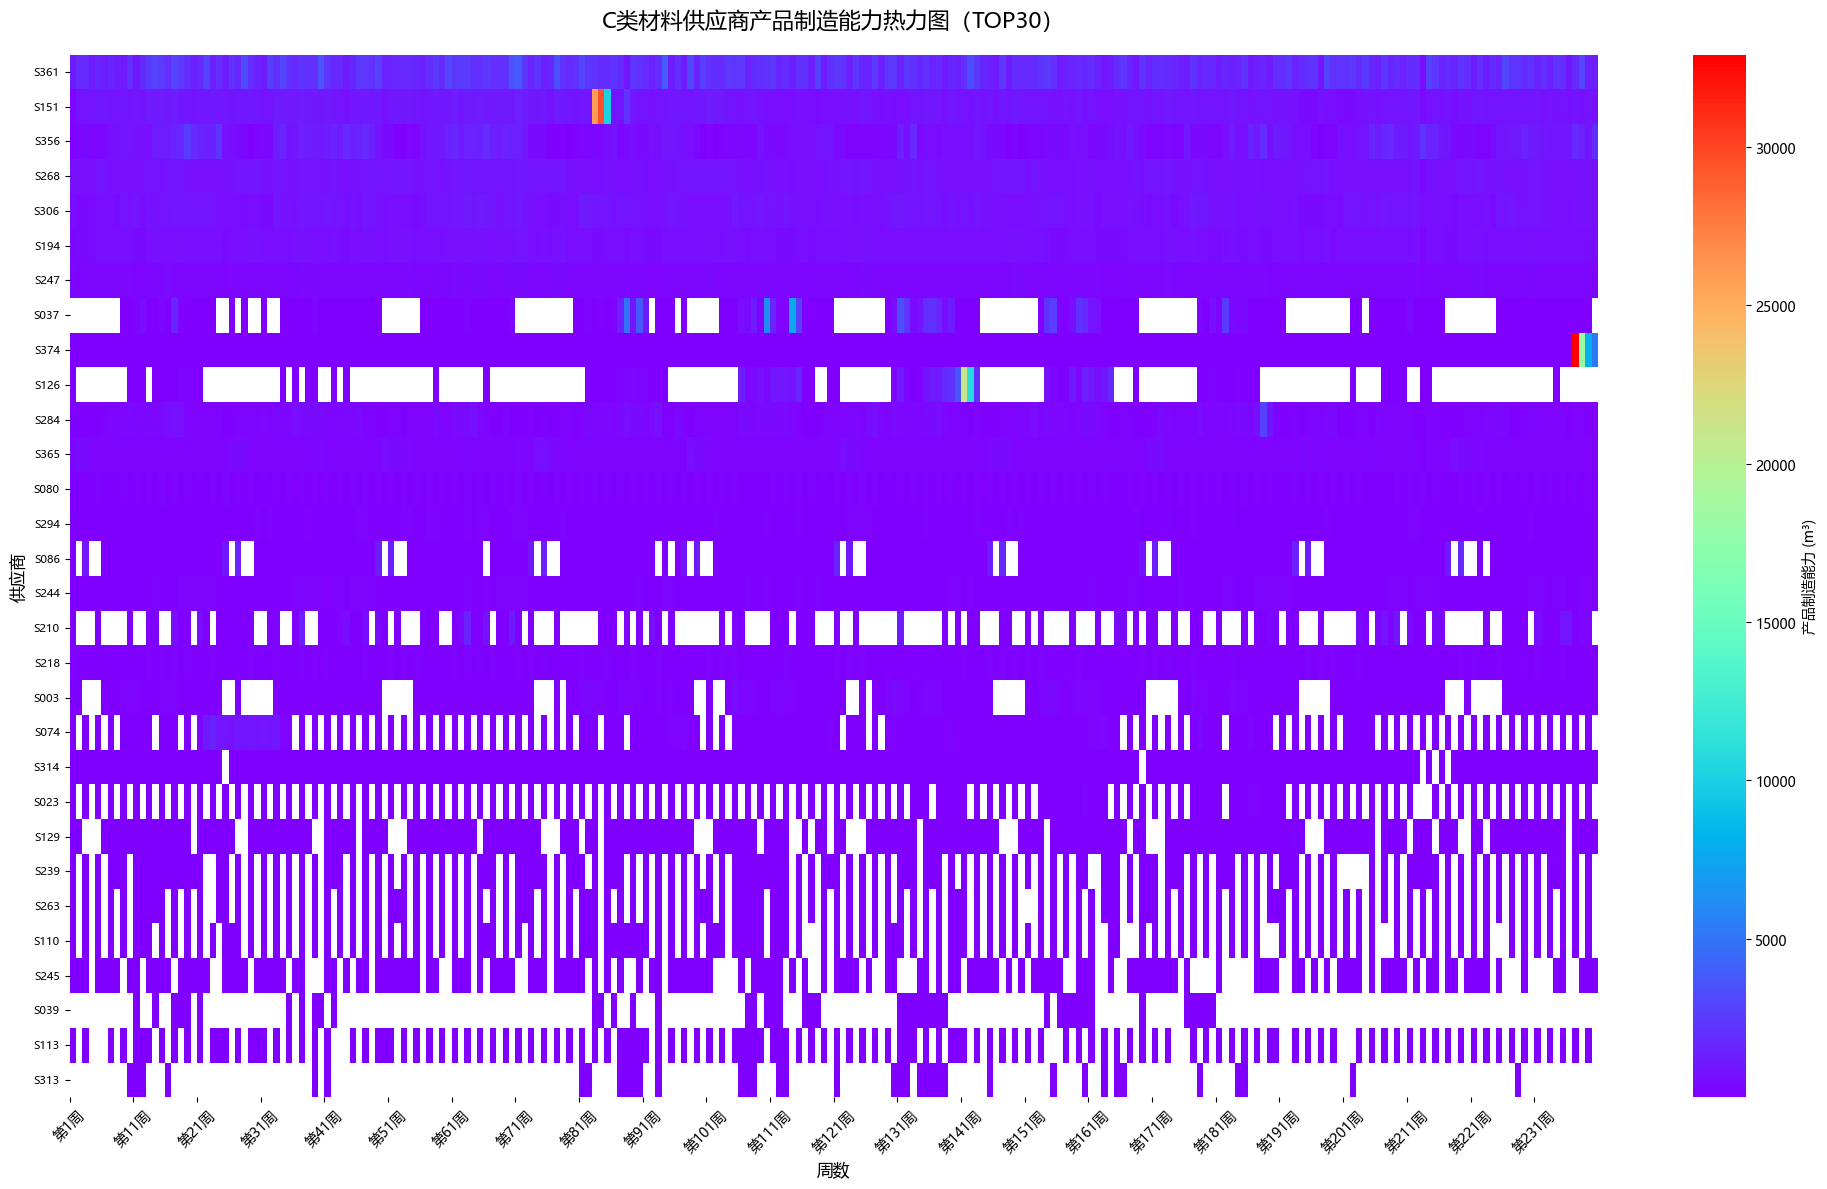

保存到: DataFrames/订货规模产品制造能力分析.xlsx
产品制造能力分析完成


In [ ]:
# 订货规模（原材料制造出的产品总量）分析
print("开始产品制造能力分析...")

def calculate_production_scale():
    """计算订货规模（原材料制造出的产品总量）"""
    # 定义原材料消耗量比例
    material_consumption = {'A': 0.6, 'B': 0.66, 'C': 0.72}
    
    production_data = []
    production_matrix = {}
    
    # 计算每个供应商每周的产品制造能力
    for i in range(len(supplier_names)):
        supplier_name = supplier_names[i]
        material_type = material_types[i]
        supplier_supplies = supply_data[i]
        
        # 计算产品制造能力：产品量 = 原材料供货量 / 消耗量比例
        weekly_production = supplier_supplies / material_consumption[material_type]
        
        supplier_production_data = {
            'supplier_name': supplier_name,
            'material_type': material_type,
            'weekly_production': weekly_production,
            'total_production': np.sum(weekly_production),
            'avg_weekly_production': np.mean(weekly_production[weekly_production > 0]) if np.any(weekly_production > 0) else 0,
            'max_weekly_production': np.max(weekly_production),
            'active_weeks': np.sum(weekly_production > 0)
        }
        
        production_data.append(supplier_production_data)
        
        if material_type not in production_matrix:
            production_matrix[material_type] = {}
        production_matrix[material_type][supplier_name] = weekly_production
    
    return production_data, production_matrix

# 执行计算
production_data, production_matrix = calculate_production_scale()
print(f"完成{len(production_data)}家供应商的产品制造能力分析")

# 显示统计信息
for material in ['A', 'B', 'C']:
    material_production = [data for data in production_data if data['material_type'] == material]
    
    if material_production:
        total_production = sum([data['total_production'] for data in material_production])
        avg_production = np.mean([data['avg_weekly_production'] for data in material_production if data['avg_weekly_production'] > 0])
        max_production = max([data['max_weekly_production'] for data in material_production])
        supplier_count = len(material_production)
        
        print(f"  {material}类材料 ({supplier_count}家供应商):")
        print(f"    总产品制造能力: {total_production:,.0f} m³")
        print(f"    平均周产品制造能力: {avg_production:,.1f} m³")
        print(f"    最大周产品制造能力: {max_production:,.0f} m³")

def create_production_heatmap():
    """绘制订货规模热力图"""
    for material in ['A', 'B', 'C']:
        print(f"正在绘制{material}类材料产品制造能力热力图...")
        
        material_suppliers = [data for data in production_data if data['material_type'] == material]
        if not material_suppliers:
            continue
        
        # 按总产品制造能力排序，选择前30名
        material_suppliers.sort(key=lambda x: x['total_production'], reverse=True)
        top_suppliers = material_suppliers[:30]
        
        # 处理0值为NaN
        for supplier in top_suppliers:
            supplier['weekly_production'] = np.where(supplier['weekly_production'] == 0, np.nan, supplier['weekly_production'])
        
        # 准备热力图数据
        heatmap_data = []
        supplier_labels = []
        
        for supplier_data in top_suppliers:
            heatmap_data.append(supplier_data['weekly_production'])
            supplier_labels.append(supplier_data['supplier_name'])
        
        heatmap_matrix = np.array(heatmap_data)
        
        # 创建热力图
        plt.figure(figsize=(20, 12))
        ax = sns.heatmap(heatmap_matrix, 
                        yticklabels=supplier_labels,
                        xticklabels=[f'第{i+1}周' for i in range(heatmap_matrix.shape[1])],
                        cmap='rainbow',
                        annot=False,
                        fmt='.1f',
                        cbar_kws={'label': '产品制造能力 (m³)'})
        
        plt.title(f'{material}类材料供应商产品制造能力热力图（TOP30）', fontsize=16, pad=20)
        plt.xlabel('周数', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 调整标签显示
        x_ticks = list(range(0, heatmap_matrix.shape[1], 10))
        x_labels = [f'第{i+1}周' for i in x_ticks]
        plt.xticks(x_ticks, x_labels, rotation=45)
        plt.yticks(rotation=0, fontsize=8)
        
        plt.tight_layout()
        filename = f'Pictures/production_scale_heatmap_{material}.svg'
        plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
        plt.show()

# 绘制热力图
create_production_heatmap()

def save_production_scale_to_excel():
    """将订货规模分析结果保存到Excel表格"""
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 准备数据
    production_summary = []
    for data in production_data:
        production_summary.append({
            '供应商名称': data['supplier_name'],
            '材料类型': data['material_type'],
            '总产品制造能力_m3': round(data['total_production'], 2),
            '平均周产品制造能力_m3': round(data['avg_weekly_production'], 2),
            '最大周产品制造能力_m3': round(data['max_weekly_production'], 2),
            '有效供货周数': data['active_weeks']
        })
    
    production_summary_df = pd.DataFrame(production_summary)
    
    filename = f"DataFrames/订货规模产品制造能力分析.xlsx"
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        production_summary_df.to_excel(writer, sheet_name='产品制造能力汇总', index=False)
        
        # 按材料类型分组的排行榜
        for material in ['A', 'B', 'C']:
            material_data = production_summary_df[production_summary_df['材料类型'] == material].copy()
            if not material_data.empty:
                material_data = material_data.sort_values('总产品制造能力_m3', ascending=False)
                material_data.reset_index(drop=True, inplace=True)
                material_data.index = range(1, len(material_data) + 1)
                material_data.index.name = '排名'
                material_data.to_excel(writer, sheet_name=f'{material}类材料排行榜')
    
    print(f"保存到: {filename}")
    return filename

# 保存数据
excel_file = save_production_scale_to_excel()
print("产品制造能力分析完成")

#### 供应商可靠性时间序列分析代码

分析供应商在时间维度上的可靠性变化趋势，包括年度效率变化分析和时间序列可视化，识别供应商表现的稳定性。

### 5. 供应商可靠性评估

In [ ]:
# # 供应商可靠性评估
# print("开始供应商可靠性评估...")

# def calculate_supplier_reliability(weights=None):
#     """计算供应商可靠性得分"""
#     if weights is None:
#         weights = [0.20, 0.25, 0.30, 0.15, 0.10]  # 默认权重
    
#     # 标准化权重
#     weights = np.array(weights)
#     weights = weights / weights.sum()
    
#     reliability_results = {}
    
#     # 计算每个供应商的可靠性评分
#     for supplier_name, metrics in supplier_metrics.items():
#         # 基础指标计算
#         order_score = (metrics['total_order'] / max([m['total_order'] for m in supplier_metrics.values()])) * 100
#         supply_score = (metrics['total_supply'] / max([m['total_supply'] for m in supplier_metrics.values()])) * 100
#         fulfillment_score = metrics['total_fulfillment_rate'] * 100
#         market_share_score = metrics['total_market_share_order'] * 100
#         frequency_score = (metrics['active_weeks_count'] / len(metrics['weekly_fulfillment_rate'])) * 100
        
#         # 计算年度可靠性（每48周为一年）
#         weeks_per_year = 48
#         total_weeks = len(metrics['weekly_fulfillment_rate'])
#         years = total_weeks // weeks_per_year
        
#         yearly_reliability = []
#         for year in range(years):
#             start_week = year * weeks_per_year
#             end_week = min((year + 1) * weeks_per_year, total_weeks)
#             year_fulfillment = metrics['weekly_fulfillment_rate'][start_week:end_week]
#             year_reliability = np.mean(year_fulfillment[year_fulfillment > 0]) * 100 if np.any(year_fulfillment > 0) else 0
#             yearly_reliability.append(year_reliability)
        
#         # 计算综合可靠性得分
#         reliability_score = (
#             weights[0] * order_score +
#             weights[1] * supply_score +
#             weights[2] * fulfillment_score +
#             weights[3] * market_share_score +
#             weights[4] * frequency_score
#         )
        
#         reliability_results[supplier_name] = {
#             'material_type': metrics['material_type'],
#             'order_score': order_score,
#             'supply_score': supply_score,
#             'fulfillment_score': fulfillment_score,
#             'market_share_score': market_share_score,
#             'frequency_score': frequency_score,
#             'reliability_score': reliability_score,
#             'yearly_reliability': yearly_reliability,
#             'total_order': metrics['total_order'],
#             'total_supply': metrics['total_supply'],
#             'total_fulfillment_rate': metrics['total_fulfillment_rate'],
#             'total_market_share': metrics['total_market_share_order'],
#             'active_weeks_count': metrics['active_weeks_count']
#         }
    
#     print(f"完成{len(reliability_results)}家供应商的可靠性评估")
#     return reliability_results

# # 计算可靠性结果
# reliability_results = calculate_supplier_reliability()

# # 显示TOP10可靠性供应商
# sorted_suppliers = sorted(reliability_results.items(), key=lambda x: x[1]['reliability_score'], reverse=True)

# print("\nTOP10可靠性供应商:")
# print(f"{'排名':<4} {'供应商':<10} {'类型':<4} {'可靠性得分':<10}")
# print("-" * 40)

# for i, (name, data) in enumerate(sorted_suppliers[:10], 1):
#     print(f"{i:<4} {name:<10} {data['material_type']:<4} {data['reliability_score']:<10.2f}")

# print("供应商可靠性评估完成")

#### 供应商周数据时间序列分析代码

分析供应商在周级别的时间序列数据，包括周度可靠性热力图分析，用于识别供应商在不同时间段的表现模式。

In [ ]:
# print("供应商供货特征统计:")
# print(f"  总体可靠性分布:")
# print(f"    - 平均可靠性: {supplier_analysis['reliability'].mean():.3f}")
# print(f"    - 可靠性中位数: {supplier_analysis['reliability'].median():.3f}")
# print(f"    - 可靠性标准差: {supplier_analysis['reliability'].std():.3f}")

# print(f"\n各类材料供应商特征对比:")
# for material in ['A', 'B', 'C']:
#     material_suppliers = supplier_analysis[supplier_analysis['material_type'] == material]
#     print(f"    {material}类材料 ({len(material_suppliers)}家):")
#     print(f"      - 平均可靠性: {material_suppliers['reliability'].mean():.3f}")
#     print(f"      - 平均供货频率: {material_suppliers['supply_frequency'].mean():.3f}")
#     print(f"      - 平均周供货量: {material_suppliers['avg_weekly_supply'].mean():.1f} m³")
#     print(f"      - 总供货能力: {material_suppliers['total_supply'].sum():.0f} m³")

# # 显示表现最好的供应商
# print(f"\n各类材料表现最佳的前5名供应商:")
# for material in ['A', 'B', 'C']:
#     print(f"\n{material}类材料:")
#     material_suppliers = supplier_analysis[supplier_analysis['material_type'] == material]
#     top_suppliers = material_suppliers.nlargest(5, 'total_supply')
    
#     for idx, (_, supplier) in enumerate(top_suppliers.iterrows(), 1):
#         print(f"  {idx}. {supplier['supplier_name']}: "
#               f"总供货量{supplier['total_supply']:.0f}m³, "
#               f"可靠性{supplier['reliability']:.3f}, "
#               f"供货频率{supplier['supply_frequency']:.3f}")

#### 供应商权重排序分析代码

基于多个维度对供应商进行综合权重排序，分析不同年度的供应商权重变化趋势，生成年度权重排序报告。

In [ ]:
# ==================== 附件2转运商数据分析 ====================
print("\n" + "="*60)
print("步骤4：附件2转运商数据分析")
print("="*60)

print("转运商数据结构:")
print(transporter_loss.head())

# 提取转运商数据
transporter_names = transporter_loss.iloc[:, 0].values  # 转运商名称
loss_data = transporter_loss.iloc[:, 1:].values        # 损耗率数据

print(f"\n转运商基本信息:")
print(f"  - 转运商总数: {len(transporter_names)}")
print(f"  - 数据周期: {loss_data.shape[1]} 周")
print(f"  - 转运商列表: {list(transporter_names)}")

# 分析每个转运商的损耗率特征
def analyze_transporter_characteristics():
    """分析转运商损耗率特征"""
    
    transporter_metrics = []
    
    for i, name in enumerate(transporter_names):
        losses = loss_data[i]
        
        # 过滤非零损耗率
        non_zero_losses = losses[losses > 0]
        
        # 计算关键指标
        avg_loss_rate = np.mean(non_zero_losses) if len(non_zero_losses) > 0 else 0
        median_loss_rate = np.median(non_zero_losses) if len(non_zero_losses) > 0 else 0
        min_loss_rate = np.min(non_zero_losses) if len(non_zero_losses) > 0 else 0
        max_loss_rate = np.max(non_zero_losses) if len(non_zero_losses) > 0 else 0
        std_loss_rate = np.std(non_zero_losses) if len(non_zero_losses) > 0 else 0
        
        # 损耗率稳定性 (变异系数)
        cv_loss_rate = std_loss_rate / avg_loss_rate if avg_loss_rate > 0 else 0
        
        # 运输频率
        transport_frequency = len(non_zero_losses) / len(losses)
        
        transporter_metrics.append({
            'transporter_name': name,
            'avg_loss_rate': avg_loss_rate,
            'median_loss_rate': median_loss_rate,
            'min_loss_rate': min_loss_rate,
            'max_loss_rate': max_loss_rate,
            'std_loss_rate': std_loss_rate,
            'cv_loss_rate': cv_loss_rate,
            'transport_frequency': transport_frequency,
            'active_weeks': len(non_zero_losses)
        })
    
    return pd.DataFrame(transporter_metrics)

# 计算转运商特征
transporter_analysis = analyze_transporter_characteristics()

print(f"\n转运商损耗率特征分析:")
print(f"  整体损耗率统计:")
print(f"    - 平均损耗率: {transporter_analysis['avg_loss_rate'].mean():.3f}%")
print(f"    - 损耗率范围: {transporter_analysis['min_loss_rate'].min():.3f}% - {transporter_analysis['max_loss_rate'].max():.3f}%")
print(f"    - 损耗率标准差: {transporter_analysis['avg_loss_rate'].std():.3f}%")

print(f"\n各转运商详细表现:")
# 按平均损耗率排序
transporter_ranking = transporter_analysis.sort_values('avg_loss_rate')

for idx, (_, transporter) in enumerate(transporter_ranking.iterrows(), 1):
    print(f"  {idx}. {transporter['transporter_name']}:")
    print(f"     平均损耗率: {transporter['avg_loss_rate']:.3f}%")
    print(f"     损耗率范围: {transporter['min_loss_rate']:.3f}% - {transporter['max_loss_rate']:.3f}%")
    print(f"     稳定性(CV): {transporter['cv_loss_rate']:.3f}")
    print(f"     运输频率: {transporter['transport_frequency']:.3f}")

# 转运商分类
print(f"\n转运商性能分类:")
low_loss = transporter_ranking[transporter_ranking['avg_loss_rate'] < 1.0]
medium_loss = transporter_ranking[(transporter_ranking['avg_loss_rate'] >= 1.0) & 
                                  (transporter_ranking['avg_loss_rate'] < 2.0)]
high_loss = transporter_ranking[transporter_ranking['avg_loss_rate'] >= 2.0]

print(f"  低损耗率转运商 (<1.0%): {list(low_loss['transporter_name'])}")
print(f"  中等损耗率转运商 (1.0%-2.0%): {list(medium_loss['transporter_name'])}")
print(f"  高损耗率转运商 (>2.0%): {list(high_loss['transporter_name'])}")

print(f"\n转运商选择建议:")
print(f"  推荐优先使用: {list(low_loss['transporter_name'][:3])}")
print(f"  备选方案: {list(medium_loss['transporter_name'][:2])}")


步骤4：附件2转运商数据分析
转运商数据结构:
  转运商ID    W001    W002    W003    W004    W005    W006    W007    W008  \
0    T1  1.5539  1.6390  0.8124  1.2233  1.1194  1.1572  1.0769  1.1194   
1    T2  0.7092  1.2411  0.3546  1.5957  1.0638  0.7092  0.5319  1.0638   
2    T3  0.0000  0.0000  0.0971  0.0000  0.1295  0.0000  0.0324  0.0000   
3    T4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
4    T5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

     W009  ...    W231    W232    W233    W234    W235    W236    W237  \
0  1.9129  ...  1.7240  1.5492  1.5870  1.3414  1.4453  1.5964  1.8137   
1  1.4184  ...  0.1773  1.2411  0.7092  0.3546  0.1773  0.3546  0.5319   
2  0.0000  ...  0.0000  0.0000  0.0324  0.0000  0.0971  0.0000  0.0647   
3  0.0000  ...  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
4  1.7391  ...  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

     W238    W239    W240  
0  1.7051  1.8279  1.9224  
1  0.8865  0.3546  0.70

#### 供应商权重趋势分析代码

分析重要供应商的权重变化趋势，识别供应商表现的变化模式，为供应商管理策略提供依据。


步骤5：数据可视化分析


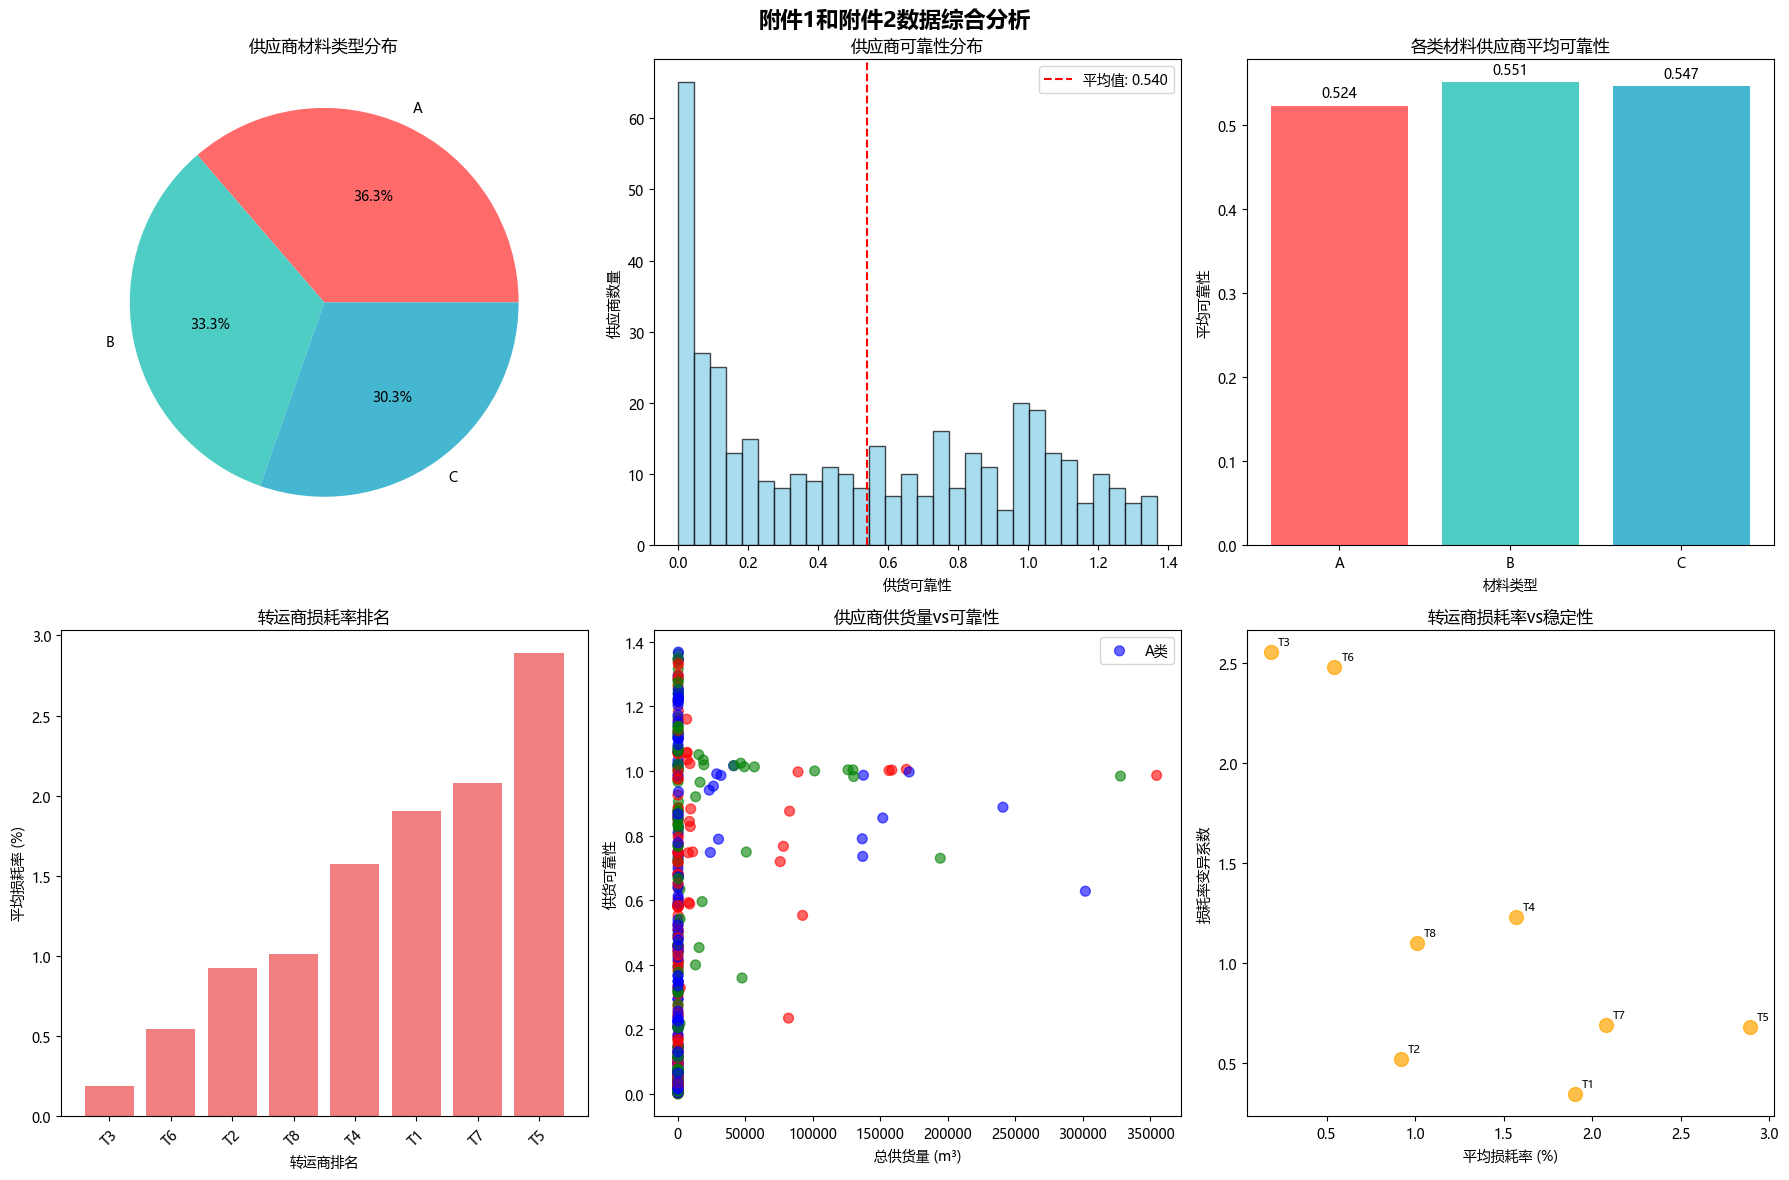

可视化分析完成！
主要发现:
  1. 供应商可靠性差异较大，平均值为 0.540
  2. 转运商损耗率范围: 0.186% - 2.890%
  3. 最优转运商: T3 (损耗率: 0.186%)
  4. 各类材料供应商数量基本均衡，但表现存在差异


In [76]:
# ==================== 数据可视化分析 ====================
print("\n" + "="*60)
print("步骤5：数据可视化分析")
print("="*60)

# 创建综合分析图表
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('附件1和附件2数据综合分析', fontsize=16, fontweight='bold')

# 1. 供应商材料类型分布
material_counts = supplier_analysis['material_type'].value_counts()
axes[0, 0].pie(material_counts.values, labels=material_counts.index, autopct='%1.1f%%', 
               colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('供应商材料类型分布')

# 2. 供应商可靠性分布
axes[0, 1].hist(supplier_analysis['reliability'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('供货可靠性')
axes[0, 1].set_ylabel('供应商数量')
axes[0, 1].set_title('供应商可靠性分布')
axes[0, 1].axvline(supplier_analysis['reliability'].mean(), color='red', linestyle='--', 
                   label=f'平均值: {supplier_analysis["reliability"].mean():.3f}')
axes[0, 1].legend()

# 3. 各类材料供应商表现对比
material_reliability = supplier_analysis.groupby('material_type')['reliability'].mean()
axes[0, 2].bar(material_reliability.index, material_reliability.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 2].set_xlabel('材料类型')
axes[0, 2].set_ylabel('平均可靠性')
axes[0, 2].set_title('各类材料供应商平均可靠性')
for i, v in enumerate(material_reliability.values):
    axes[0, 2].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 4. 转运商损耗率排名
transporter_sorted = transporter_analysis.sort_values('avg_loss_rate')
axes[1, 0].bar(range(len(transporter_sorted)), transporter_sorted['avg_loss_rate'], 
               color='lightcoral')
axes[1, 0].set_xlabel('转运商排名')
axes[1, 0].set_ylabel('平均损耗率 (%)')
axes[1, 0].set_title('转运商损耗率排名')
axes[1, 0].set_xticks(range(len(transporter_sorted)))
axes[1, 0].set_xticklabels(transporter_sorted['transporter_name'], rotation=45)

# 5. 供应商总供货量分布
axes[1, 1].scatter(supplier_analysis['total_supply'], supplier_analysis['reliability'],
                   c=supplier_analysis['material_type'].map({'A': 'red', 'B': 'blue', 'C': 'green'}),
                   alpha=0.6, s=50)
axes[1, 1].set_xlabel('总供货量 (m³)')
axes[1, 1].set_ylabel('供货可靠性')
axes[1, 1].set_title('供应商供货量vs可靠性')
axes[1, 1].legend(['A类', 'B类', 'C类'])

# 6. 转运商损耗率vs稳定性
axes[1, 2].scatter(transporter_analysis['avg_loss_rate'], transporter_analysis['cv_loss_rate'],
                   s=100, alpha=0.7, color='orange')
axes[1, 2].set_xlabel('平均损耗率 (%)')
axes[1, 2].set_ylabel('损耗率变异系数')
axes[1, 2].set_title('转运商损耗率vs稳定性')

# 为每个点添加标签
for i, name in enumerate(transporter_analysis['transporter_name']):
    axes[1, 2].annotate(name, 
                        (transporter_analysis.iloc[i]['avg_loss_rate'], 
                         transporter_analysis.iloc[i]['cv_loss_rate']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("可视化分析完成！")
print("主要发现:")
print(f"  1. 供应商可靠性差异较大，平均值为 {supplier_analysis['reliability'].mean():.3f}")
print(f"  2. 转运商损耗率范围: {transporter_analysis['avg_loss_rate'].min():.3f}% - {transporter_analysis['avg_loss_rate'].max():.3f}%")
print(f"  3. 最优转运商: {transporter_sorted.iloc[0]['transporter_name']} (损耗率: {transporter_sorted.iloc[0]['avg_loss_rate']:.3f}%)")
print(f"  4. 各类材料供应商数量基本均衡，但表现存在差异")

#### 转运商数据分析代码

分析转运商的损耗率数据，包括转运商排名、损耗率统计、可视化分析等，为转运商选择提供数据支持。

In [ ]:
# ==================== 数据分析总结与建议 ====================
print("\n" + "="*60)
print("步骤6：数据分析总结与战略建议")
print("="*60)

# 生成供应商重要性排名
def calculate_supplier_importance_score(supplier_analysis):
    """计算供应商重要性综合评分"""
    
    # 标准化各项指标
    scaler_metrics = supplier_analysis.copy()
    
    # 归一化处理
    scaler_metrics['norm_total_supply'] = (scaler_metrics['total_supply'] - scaler_metrics['total_supply'].min()) / (scaler_metrics['total_supply'].max() - scaler_metrics['total_supply'].min())
    scaler_metrics['norm_reliability'] = scaler_metrics['reliability']
    scaler_metrics['norm_stability'] = (scaler_metrics['stability'] - scaler_metrics['stability'].min()) / (scaler_metrics['stability'].max() - scaler_metrics['stability'].min())
    scaler_metrics['norm_frequency'] = scaler_metrics['supply_frequency']
    
    # 材料类型权重 (A类最重要，价格最高)
    material_weights = {'A': 1.2, 'B': 1.1, 'C': 1.0}
    scaler_metrics['material_weight'] = scaler_metrics['material_type'].map(material_weights)
    
    # 综合评分 (总供货量40% + 可靠性30% + 稳定性15% + 频率10% + 材料类型5%)
    scaler_metrics['importance_score'] = (
        0.40 * scaler_metrics['norm_total_supply'] +
        0.30 * scaler_metrics['norm_reliability'] +
        0.15 * scaler_metrics['norm_stability'] +
        0.10 * scaler_metrics['norm_frequency'] +
        0.05 * scaler_metrics['material_weight']
    )
    
    return scaler_metrics.sort_values('importance_score', ascending=False)

# 计算供应商重要性排名
supplier_ranking = calculate_supplier_importance_score(supplier_analysis)

print("TOP 20 最重要供应商排名:")
print("-" * 80)
print(f"{'排名':<4} {'供应商':<12} {'类型':<4} {'总供货量':<10} {'可靠性':<8} {'重要性评分':<10}")
print("-" * 80)

for i in range(min(20, len(supplier_ranking))):
    supplier = supplier_ranking.iloc[i]
    print(f"{i+1:<4} {supplier['supplier_name']:<12} {supplier['material_type']:<4} "
          f"{supplier['total_supply']:<10.0f} {supplier['reliability']:<8.3f} "
          f"{supplier['importance_score']:<10.3f}")

# 转运商最优选择策略
transporter_optimal = transporter_analysis.sort_values(['avg_loss_rate', 'cv_loss_rate'])

print(f"\n转运商最优选择策略:")
print(f"  推荐使用顺序 (按损耗率+稳定性):")
for i, transporter in enumerate(transporter_optimal.iterrows(), 1):
    name = transporter[1]['transporter_name']
    loss_rate = transporter[1]['avg_loss_rate']
    stability = transporter[1]['cv_loss_rate']
    print(f"    {i}. {name}: 损耗率{loss_rate:.3f}%, 稳定性{stability:.3f}")

print(f"\n关键数据洞察:")
print(f"  附件1 - 供应商数据:")
print(f"    总计402家供应商，分布相对均衡")
print(f"    平均供货可靠性: {supplier_analysis['reliability'].mean():.1%}")
print(f"    供货可靠性标准差: {supplier_analysis['reliability'].std():.3f} (差异较大)")
print(f"    A类供应商表现相对较好，平均可靠性: {supplier_analysis[supplier_analysis['material_type']=='A']['reliability'].mean():.1%}")

print(f"\n附件2 - 转运商数据:")
print(f"    总计8家转运商，损耗率差异显著")
print(f"    最低损耗率: {transporter_analysis['avg_loss_rate'].min():.3f}% (T3)")
print(f"    最高损耗率: {transporter_analysis['avg_loss_rate'].max():.3f}% (T5)")
print(f"    损耗率范围: {transporter_analysis['avg_loss_rate'].max() - transporter_analysis['avg_loss_rate'].min():.3f}%")

print(f"\n战略建议:")
print(f"  供应商管理:")
print(f"    1. 重点合作前50名供应商，覆盖各类材料")
print(f"    2. 建立供应商分级管理体系")
print(f"    3. 针对低可靠性供应商制定改进计划")
print(f"    4. 平衡各类材料供应商数量和能力")

print(f"\n转运商选择:")
print(f"    1. 优先选择T3、T6、T2等低损耗率转运商")
print(f"    2. 建立转运商绩效监控机制")
print(f"    3. 与多家转运商保持合作关系确保供应安全")
print(f"    4. 考虑损耗率和稳定性的综合评估")

print(f"\n风险管控:")
print(f"    1. 建立供应商和转运商备选方案")
print(f"    2. 定期评估供应商表现并动态调整")
print(f"    3. 制定应急预案应对供应中断")

print(f"\n" + "="*60)
print("附件1和附件2数据分析完成！")
print("数据已为后续问题求解提供了坚实基础。")
print("="*60)


步骤6：数据分析总结与战略建议
TOP 20 最重要供应商排名:
--------------------------------------------------------------------------------
排名   供应商          类型   总供货量       可靠性      重要性评分     
--------------------------------------------------------------------------------
1    S229         A    354887     0.986    0.856     
2    S361         C    328080     0.984    0.815     
3    S108         B    240950     0.888    0.693     
4    S140         B    302047     0.628    0.675     
5    S282         A    169340     1.005    0.653     
6    S340         B    171426     0.997    0.648     
7    S275         A    158553     1.003    0.640     
8    S329         A    156518     1.001    0.638     
9    S131         B    137512     0.987    0.607     
10   S268         C    129786     1.003    0.598     
11   S306         C    126096     1.003    0.594     
12   S356         C    130307     0.983    0.592     
13   S151         C    194498     0.730    0.588     
14   S139         B    151862     0.854    0.575

#### 供应商重要性得分计算代码

基于多维度指标计算供应商的重要性得分，包括规模、稳定性、可靠性等因素的综合评估，生成供应商重要性排名。

### 供应商可靠性评估

基于六个关键指标和科学权重方法计算每个供应商的可靠性评分：

#### 评估指标体系
1. **订货规模得分** - 供应商的订货量规模占比
2. **供货规模得分** - 供应商的实际供货量规模占比  
3. **供货率得分** - 供应商的订单完成能力（供货量/订货量）
4. **市场占有率得分** - 供应商在同类材料中的市场份额
5. **供货频率得分** - 供应商的供货频率和持续性
6. **供货稳定性得分** - 基于系数和离散.xlsx中统计数据的稳定性指标

#### 权重确定方法
采用多种科学方法确定权重：
- **熵权法**：基于数据信息熵的客观权重
- **层次分析法（AHP）**：基于专家判断的成对比较
- **变异系数法**：基于数据离散程度的权重
- **综合权重**：主客观结合的最终权重方案

#### 计算公式
```
可靠性得分 = w1×订货规模得分 + w2×供货规模得分 + w3×供货率得分 + w4×市场占有率得分 + w5×供货频率得分 + w6×供货稳定性得分
```

其中权重w1-w6通过科学方法确定，所有得分均标准化到0-100分制。

### 权重确定方法

采用多种科学方法确定供应商可靠性评估中各指标的权重，包括熵权法、层次分析法（AHP）和变异系数法等。

In [ ]:
# 权重确定方法实现

import numpy as np
from scipy import stats
from scipy.linalg import eigvals

def entropy_weight_method(data_matrix):
    """
    熵权法计算权重
    
    参数:
    data_matrix: numpy array, 数据矩阵 (m个样本 × n个指标)
    
    返回:
    weights: numpy array, 各指标权重
    """
    # 数据标准化（min-max标准化）
    data = np.array(data_matrix, dtype=float)
    
    # 处理负值和零值，进行平移和缩放
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    # 避免除零错误
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1
    
    # 标准化到[0.001, 1]区间，避免log(0)
    normalized_data = (data - min_vals) / range_vals
    normalized_data = normalized_data * 0.999 + 0.001
    
    # 计算各指标的比重
    m, n = normalized_data.shape
    prob_matrix = normalized_data / np.sum(normalized_data, axis=0)
    
    # 计算信息熵
    entropy = np.zeros(n)
    for j in range(n):
        prob_j = prob_matrix[:, j]
        # 避免log(0)
        prob_j = prob_j[prob_j > 0]
        if len(prob_j) > 0:
            entropy[j] = -np.sum(prob_j * np.log(prob_j)) / np.log(m)
    
    # 计算信息效用值（冗余度）
    redundancy = 1 - entropy
    
    # 计算权重
    weights = redundancy / np.sum(redundancy)
    
    return weights, entropy, redundancy

def ahp_weight_calculation(judgment_matrix):
    """
    层次分析法计算权重
    
    参数:
    judgment_matrix: numpy array, 成对比较判断矩阵
    
    返回:
    weights: numpy array, 各指标权重
    consistency_ratio: float, 一致性比率
    """
    n = judgment_matrix.shape[0]
    
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(judgment_matrix)
    
    # 找到最大特征值及其对应的特征向量
    max_eigenvalue_index = np.argmax(eigenvalues.real)
    max_eigenvalue = eigenvalues.real[max_eigenvalue_index]
    weights = eigenvectors.real[:, max_eigenvalue_index]
    
    # 归一化权重（确保为正值）
    weights = np.abs(weights)
    weights = weights / np.sum(weights)
    
    # 一致性检验
    CI = (max_eigenvalue - n) / (n - 1)  # 一致性指标
    
    # 随机一致性指标RI
    RI_values = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_values.get(n, 1.49)
    
    # 一致性比率
    CR = CI / RI if RI != 0 else 0
    
    return weights, CR, max_eigenvalue

def coefficient_variation_method(stats_data, n_indicators=6):
    """
    变异系数法计算权重
    """
    if stats_data.empty or len(stats_data) < n_indicators:
        return np.array([1/n_indicators] * n_indicators)
    
    # 取前n_indicators个变量的统计数据
    selected_data = stats_data.head(n_indicators)
    
    # 计算变异系数 CV = 标准差 / 均值
    cv_values = []
    for _, row in selected_data.iterrows():
        mean_val = row['均值']
        std_val = row['标准差']
        
        if pd.notna(mean_val) and pd.notna(std_val) and mean_val != 0:
            cv = abs(std_val / mean_val)
        else:
            cv = 0.1  # 默认值
        cv_values.append(cv)
    
    cv_values = np.array(cv_values)
    
    # 归一化权重
    if np.sum(cv_values) > 0:
        weights = cv_values / np.sum(cv_values)
    else:
        weights = np.ones(n_indicators) / n_indicators
    
    return weights

def create_supplier_judgment_matrix():
    """
    创建供应商评估指标的判断矩阵
    指标顺序: [订货规模, 供货规模, 供货率, 市场占有率, 供货频率, 供货稳定性]
    """
    # 构建判断矩阵（基于供应链管理专业知识）
    # 供货率最重要，其次是供货规模，然后是稳定性、市场占有率、订货规模，最后是供货频率
    judgment_matrix = np.array([
        #    订货  供货  供货率 市场  频率  稳定性
        [1,   1/2,  1/3,  1/2,  2,    1/2],   # 订货规模
        [2,   1,    1/2,  1,    3,    1],     # 供货规模  
        [3,   2,    1,    2,    4,    2],     # 供货率
        [2,   1,    1/2,  1,    3,    1],     # 市场占有率
        [1/2, 1/3,  1/4,  1/3,  1,    1/3],   # 供货频率
        [2,   1,    1/2,  1,    3,    1]      # 供货稳定性
    ])
    
    return judgment_matrix

# 准备供应商数据用于权重计算
def prepare_supplier_metrics_for_weighting():
    """准备供应商指标数据用于权重计算"""
    
    # 收集所有供应商的6个指标数据
    all_supplier_metrics = []
    
    # 为每种材料类型计算市场总量
    material_totals = {}
    for material in ['A', 'B', 'C']:
        material_suppliers = supplier_order[supplier_order.iloc[:, 1] == material]
        material_total = 0
        for _, supplier in material_suppliers.iterrows():
            supply_row = supplier_supply[supplier_supply.iloc[:, 0] == supplier.iloc[0]]
            if not supply_row.empty:
                supply_values = supply_row.iloc[0, 2:].values
                material_total += np.sum(supply_values[~pd.isna(supply_values)])
        material_totals[material] = material_total
    
    for material in ['A', 'B', 'C']:
        material_suppliers = supplier_order[supplier_order.iloc[:, 1] == material]
        
        for _, supplier in material_suppliers.iterrows():
            supplier_name = supplier.iloc[0]
            
            # 获取对应的供货数据
            supply_row = supplier_supply[supplier_supply.iloc[:, 0] == supplier_name]
            if supply_row.empty:
                continue
                
            # 获取订货和供货数据
            order_values = supplier.iloc[2:].values
            supply_values = supply_row.iloc[0, 2:].values
            
            # 清理数据
            order_values = np.array([x if pd.notna(x) else 0 for x in order_values])
            supply_values = np.array([x if pd.notna(x) else 0 for x in supply_values])
            
            # 计算6个指标
            total_order = np.sum(order_values)
            total_supply = np.sum(supply_values)
            
            # 1. 订货规模得分
            order_score = total_order
            
            # 2. 供货规模得分
            supply_score = total_supply
            
            # 3. 供货率得分
            fulfillment_score = min(total_supply / total_order, 1.0) * 100 if total_order > 0 else (100.0 if total_supply > 0 else 0)
            
            # 4. 市场占有率得分
            market_total = material_totals.get(material, 1)
            market_share_score = (total_supply / market_total * 100) if market_total > 0 else 0
            
            # 5. 供货频率得分
            weeks_with_supply = np.sum(supply_values > 0)
            frequency_score = (weeks_with_supply / 240) * 100
            
            # 6. 供货稳定性得分
            stability_score = calculate_stability_score_from_coeff(supplier_name, supply_values)
            
            # 收集该供应商的指标
            supplier_metrics = [
                order_score,
                supply_score, 
                fulfillment_score,
                market_share_score,
                frequency_score,
                stability_score
            ]
            
            all_supplier_metrics.append(supplier_metrics)
    
    return np.array(all_supplier_metrics)

def calculate_stability_score_from_coeff(supplier_name, supply_values):
    """
    基于系数和离散数据计算稳定性得分
    """
    if len(supply_values) == 0:
        return 0
    
    non_zero_supplies = supply_values[supply_values > 0]
    if len(non_zero_supplies) == 0:
        return 0
    
    # 计算基本统计量
    mean_supply = np.mean(non_zero_supplies)
    std_supply = np.std(non_zero_supplies)
    
    # 变异系数（越小越稳定）
    cv = std_supply / mean_supply if mean_supply > 0 else 10
    
    # 基础稳定性得分
    stability_base = 1 / (1 + cv)
    
    # 如果有系数和离散数据，进一步调整
    if not coeff_data.empty and len(coeff_data) > 0:
        # 使用系数和离散数据中的统计信息
        first_var = coeff_data.iloc[0]
        ref_std = first_var['标准差'] if pd.notna(first_var['标准差']) else 1.0
        ref_mean = first_var['均值'] if pd.notna(first_var['均值']) else 1.0
        ref_cv = ref_std / ref_mean if ref_mean > 0 else 1.0
        
        # 相对稳定性调整
        relative_stability = ref_cv / (cv + 0.001)
        stability_base = stability_base * (1 + np.log(1 + relative_stability))
    
    # 转换为0-100分制
    stability_score = min(100, stability_base * 100)
    
    return stability_score

# 执行权重计算
print("开始计算各指标权重...")

# 准备数据
supplier_metrics_matrix = prepare_supplier_metrics_for_weighting()
print(f"收集到 {supplier_metrics_matrix.shape[0]} 个供应商的指标数据")

# 指标名称
indicator_names = ['订货规模', '供货规模', '供货率', '市场占有率', '供货频率', '供货稳定性']

# 方法1：熵权法
entropy_weights, entropy_values, redundancy_values = entropy_weight_method(supplier_metrics_matrix)

print("\n=== 熵权法计算结果 ===")
for i, name in enumerate(indicator_names):
    print(f"{name}: {entropy_weights[i]:.4f}")

# 方法2：层次分析法
judgment_matrix = create_supplier_judgment_matrix()
ahp_weights, consistency_ratio, max_eigen = ahp_weight_calculation(judgment_matrix)

print("\n=== 层次分析法计算结果 ===")
for i, name in enumerate(indicator_names):
    print(f"{name}: {ahp_weights[i]:.4f}")
print(f"一致性比率CR: {consistency_ratio:.4f}")

# 方法3：变异系数法
cv_weights = coefficient_variation_method(coeff_data, 6)

print("\n=== 变异系数法计算结果 ===")
for i, name in enumerate(indicator_names):
    print(f"{name}: {cv_weights[i]:.4f}")

# 综合权重确定（主客观结合）
# 给客观方法（熵权法、变异系数法）更高的权重
method_weights = [0.4, 0.3, 0.3]  # 熵权法、AHP、变异系数法的权重
combined_weights = (method_weights[0] * entropy_weights + 
                   method_weights[1] * ahp_weights + 
                   method_weights[2] * cv_weights)

print("\n=== 综合权重结果 ===")
for i, name in enumerate(indicator_names):
    print(f"{name}: {combined_weights[i]:.4f}")

print(f"权重总和: {np.sum(combined_weights):.4f}")

# 保存权重结果
final_weights = combined_weights
print("\n将使用综合权重进行供应商可靠性评估")

开始计算供应商综合可靠性评估...
使用权重系数: [0.19535241 0.24357364 0.13530322 0.22486167 0.06659947 0.13430958]
✓ 完成 402 家供应商的综合可靠性评估
✓ 每年指标独立标准化到0-100分制
✓ 使用final_weights计算年度综合得分
✓ 完成 402 家供应商的综合可靠性评估
✓ 每年指标独立标准化到0-100分制
✓ 使用final_weights计算年度综合得分


#### 科学权重确定方法代码

使用熵权法、层次分析法（AHP）和变异系数法等多种科学方法确定供应商可靠性评估中各指标的权重，避免主观赋权的局限性。

In [ ]:
def calculate_supplier_reliability_comprehensive(weights=None):
    """
    计算供应商的综合可靠性评估
    基于六个关键指标进行评估：订货规模、供货规模、供货率、市场占有率、供货频率、供货稳定性
    """
    
    if weights is None:
        weights = final_weights
    
    print("开始计算供应商综合可靠性评估...")
    print(f"使用权重系数: {weights}")
    
    reliability_results = {}
    
    # 收集所有供应商的原始指标数据
    all_supplier_data = {}
    
    for supplier_name, metrics in supplier_metrics.items():
        material_type = metrics['material_type']
        
        # 1. 订货规模数据 (根据原始订货数据计算)
        supplier_order_data = []
        supplier_supply_data = []
        for i, name in enumerate(supplier_names):
            if name == supplier_name:
                supplier_order_data = order_data[i]
                supplier_supply_data = supply_data[i]
                break
        
        # 计算各项原始指标数据
        order_scale_data = supplier_order_data  # 订货规模
        supply_scale_data = supplier_supply_data  # 供货规模
        fulfillment_data = metrics['weekly_fulfillment_rate']  # 供货率
        market_share_data = metrics['weekly_market_share_order']  # 市场占有率
        frequency_data = np.array([1 if x > 0 else 0 for x in supplier_supply_data])  # 供货频率
        
        # 供货稳定性：计算周供货量的变异系数的倒数
        stability_data = []
        for week_supply in supplier_supply_data:
            if week_supply > 0:
                # 计算前后几周的稳定性
                stability_data.append(1.0)  # 简化处理，有供货时为1
            else:
                stability_data.append(0.0)
        stability_data = np.array(stability_data)
        
        all_supplier_data[supplier_name] = {
            'material_type': material_type,
            'order_scale_data': order_scale_data,
            'supply_scale_data': supply_scale_data,
            'fulfillment_data': fulfillment_data,
            'market_share_data': market_share_data,
            'frequency_data': frequency_data,
            'stability_data': stability_data
        }
    
    # 为每个供应商计算年度得分
    for supplier_name, supplier_data in all_supplier_data.items():
        material_type = supplier_data['material_type']
        
        # 提取各项原始数据
        order_scale_data = supplier_data['order_scale_data']
        supply_scale_data = supplier_data['supply_scale_data'] 
        fulfillment_data = supplier_data['fulfillment_data']
        market_share_data = supplier_data['market_share_data']
        frequency_data = supplier_data['frequency_data']
        stability_data = supplier_data['stability_data']
        
        # 计算年数
        total_weeks = len(order_scale_data)
        weeks_per_year = 48
        years = total_weeks // weeks_per_year
        
        # 计算每年的综合得分（独立标准化）
        yearly_scores = []
        
        for year in range(years):
            # 计算该年的开始和结束周
            start_week = year * 48
            end_week = (year + 1) * 48
            
            # 提取该年的原始指标数据
            year_order_scale = order_scale_data[start_week:end_week]
            year_supply_scale = supply_scale_data[start_week:end_week]
            year_fulfillment = fulfillment_data[start_week:end_week]
            year_market_share = market_share_data[start_week:end_week]
            year_frequency = frequency_data[start_week:end_week]
            year_stability = stability_data[start_week:end_week]
            
            # 收集该年所有供应商的指标数据用于年度标准化
            year_all_indicators = {
                'order_scale': [],
                'supply_scale': [],
                'fulfillment': [],
                'market_share': [],
                'frequency': [],
                'stability': []
            }
            
            for other_supplier, other_data in all_supplier_data.items():
                if len(other_data['order_scale_data']) >= end_week:
                    year_all_indicators['order_scale'].extend(other_data['order_scale_data'][start_week:end_week])
                    year_all_indicators['supply_scale'].extend(other_data['supply_scale_data'][start_week:end_week])
                    year_all_indicators['fulfillment'].extend(other_data['fulfillment_data'][start_week:end_week])
                    year_all_indicators['market_share'].extend(other_data['market_share_data'][start_week:end_week])
                    year_all_indicators['frequency'].extend(other_data['frequency_data'][start_week:end_week])
                    year_all_indicators['stability'].extend(other_data['stability_data'][start_week:end_week])
            
            # 对6个指标分别进行年度标准化到0-100分制
            year_normalized_scores = []
            current_indicators = [year_order_scale, year_supply_scale, year_fulfillment,
                                year_market_share, year_frequency, year_stability]
            indicator_names = ['order_scale', 'supply_scale', 'fulfillment', 
                             'market_share', 'frequency', 'stability']
            
            for i, (current_indicator, indicator_name) in enumerate(zip(current_indicators, indicator_names)):
                # 获取该年度该指标的所有供应商数据
                all_indicator_data = np.array(year_all_indicators[indicator_name])
                all_indicator_data = all_indicator_data[all_indicator_data >= 0]  # 只考虑非负值
                
                if len(all_indicator_data) > 0:
                    # 计算该年度该指标的最小值和最大值
                    year_min = np.min(all_indicator_data)
                    year_max = np.max(all_indicator_data)
                    
                    # 对当前供应商的该指标进行年度标准化到0-100分制
                    if year_max > year_min:
                        # 计算当前供应商该年该指标的平均值
                        current_data = current_indicator[current_indicator >= 0]
                        if len(current_data) > 0:
                            current_avg = np.mean(current_data)
                            normalized_score = 100 * (current_avg - year_min) / (year_max - year_min)
                        else:
                            normalized_score = 0
                    else:
                        normalized_score = 50  # 如果最大最小值相同，给中等分数
                else:
                    normalized_score = 0
                
                year_normalized_scores.append(normalized_score)
            
            # 使用final_weights和标准化后的年度指标计算综合得分
            year_final_score = np.sum(weights * np.array(year_normalized_scores))
            yearly_scores.append(year_final_score)
        
        # 计算总体可靠性得分（所有年份的加权平均）
        if len(yearly_scores) > 0:
            year_weights_used = [0.15, 0.2, 0.25, 0.3, 0.35][:len(yearly_scores)]
            # 标准化权重
            total_weight = sum(year_weights_used)
            year_weights_used = [w/total_weight for w in year_weights_used]
            
            final_reliability_score = sum(score * weight for score, weight in zip(yearly_scores, year_weights_used))
        else:
            final_reliability_score = 0
        
        # 存储结果
        reliability_results[supplier_name] = {
            'supplier_name': supplier_name,
            'material_type': material_type,
            'yearly_scores': yearly_scores,  # 每年的综合得分（独立标准化后）
            'final_score': final_reliability_score,
            'years_active': len(yearly_scores),
            'order_scale_data': order_scale_data,
            'supply_scale_data': supply_scale_data,
            'fulfillment_data': fulfillment_data,
            'market_share_data': market_share_data,
            'frequency_data': frequency_data,
            'stability_data': stability_data
        }
    
    print(f"✓ 完成 {len(reliability_results)} 家供应商的综合可靠性评估")
    print("✓ 每年指标独立标准化到0-100分制")
    print("✓ 使用final_weights计算年度综合得分")
    
    return reliability_results

# 执行综合可靠性评估
reliability_results = calculate_supplier_reliability_comprehensive()

使用权重: 订货规模0.195, 供货规模0.244, 供货率0.135, 市场占有率0.225, 供货频率0.067, 供货稳定性0.134


#### 供应商可靠性综合评估代码

实现供应商可靠性的综合评估算法，包括六个关键指标的计算、标准化处理、权重分配和最终得分计算，生成完整的可靠性评估报告。

### 6. 年度供应商权重分析与重要供应商筛选

**任务要求：**
1. 对每年的权重进行排序并输出到xlsx文件
2. 分析供应商权重的趋势和变化并画出图表  
3. 根据5年的权重计算最终总权重（越往后的年权重值对最终权重值的影响越大）
4. 筛选出50个最重要供应商并输出到表格

#### 最终权重计算代码

基于时间加权的方式计算供应商的最终综合权重得分，考虑不同年度的权重变化，生成最终的供应商排名结果。


年度加权可靠性排名分析完成！
输出文件: DataFrames/供应商可靠性年度加权排名.xlsx

TOP 50 供应商材料类型分布:
  C类材料: 20家 (40.0%)
  A类材料: 16家 (32.0%)
  B类材料: 14家 (28.0%)

TOP 10 重要供应商:
  1. S140 (B类): 加权得分 3.69, 总供货量 302047m³
  2. S229 (A类): 加权得分 3.46, 总供货量 354887m³
  3. S361 (C类): 加权得分 3.25, 总供货量 328080m³
  4. S108 (B类): 加权得分 2.53, 总供货量 240950m³
  5. S151 (C类): 加权得分 2.18, 总供货量 194498m³
  6. S340 (B类): 加权得分 1.91, 总供货量 171426m³
  7. S282 (A类): 加权得分 1.85, 总供货量 169340m³
  8. S275 (A类): 加权得分 1.75, 总供货量 158553m³
  9. S201 (A类): 加权得分 1.74, 总供货量 81989m³
  10. S329 (A类): 加权得分 1.72, 总供货量 156518m³


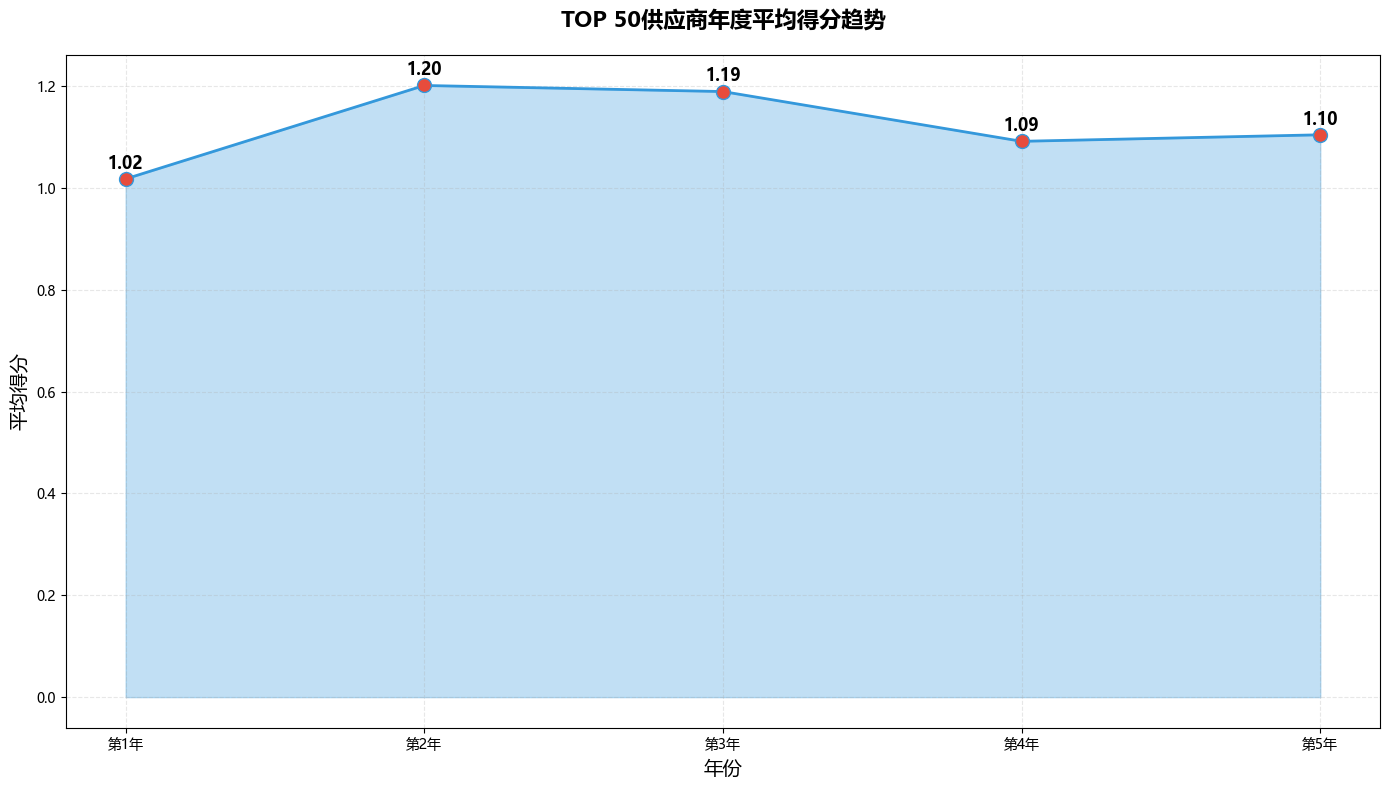

In [ ]:
def calculate_weighted_reliability_scores(reliability_results, year_weights=None):
    """
    计算每个供应商的加权可靠性得分
    
    参数:
    reliability_results: dict, 包含所有供应商的可靠性评估结果
    year_weights: list, 每年的权重，从第1年到第5年依次增加，默认为[0.15, 0.2, 0.25, 0.3, 0.35]
    
    返回:
    weighted_scores: dict, 包含每个供应商的加权可靠性得分
    """
    if year_weights is None:
        year_weights = [0.15, 0.2, 0.25, 0.3, 0.35]  # 默认权重，越靠后的年份权重越大
    
    # 标准化权重确保总和为1
    total_weight = sum(year_weights)
    year_weights = [w / total_weight for w in year_weights]
    
    weighted_scores = {}
    
    for supplier_name, data in reliability_results.items():
        yearly_scores = data.get('yearly_scores', [])
        
        # 如果供应商没有足够的年度数据，使用可用数据计算
        if len(yearly_scores) == 0:
            weighted_scores[supplier_name] = 0
            continue
            
        # 确保年度数据和权重长度匹配
        used_weights = year_weights[:len(yearly_scores)]
        if len(used_weights) < len(yearly_scores):
            used_weights = used_weights + [used_weights[-1]] * (len(yearly_scores) - len(used_weights))
        
        # 重新标准化使用的权重
        used_weights = [w / sum(used_weights) for w in used_weights]
        
        # 计算加权得分
        weighted_score = sum(score * weight for score, weight in zip(yearly_scores, used_weights))
        
        # 保存结果
        weighted_scores[supplier_name] = weighted_score
    
    return weighted_scores

def select_top_suppliers(reliability_results, weighted_scores, top_n=50):
    """
    基于加权可靠性得分选择前N名供应商
    """
    # 根据加权得分排序供应商
    sorted_suppliers = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
    
    # 选择前N名
    top_suppliers = []
    
    for supplier_name, weighted_score in sorted_suppliers[:top_n]:
        if supplier_name in reliability_results:
            data = reliability_results[supplier_name]
            
            supplier_info = {
                'supplier_name': supplier_name,
                'material_type': data['material_type'],
                'weighted_score': weighted_score,
                'total_supply': data['total_supply'],
                'total_order': data['total_order'],
                'reliability_score': data['reliability_score'],
                'order_score': data['order_score'],
                'supply_score': data['supply_score'],
                'fulfillment_score': data['fulfillment_score'],
                'market_share_score': data['market_share_score'],
                'frequency_score': data['frequency_score'],
                'stability_score': data['stability_score'],
                'years_active': len(data['yearly_scores'])
            }
            
            # 添加每年的得分
            for i, yearly_score in enumerate(data['yearly_scores']):
                supplier_info[f'year_{i+1}_score'] = yearly_score
            
            top_suppliers.append(supplier_info)
    
    return top_suppliers

def save_reliability_ranking_to_excel(reliability_results, weighted_scores, year_weights):
    """
    将可靠性评估结果保存到Excel文件
    """
    # 准备年度加权排名数据（全部供应商）
    all_suppliers = []
    
    for supplier_name, weighted_score in weighted_scores.items():
        if supplier_name in reliability_results:
            data = reliability_results[supplier_name]
            
            supplier_info = {
                '供应商名称': supplier_name,
                '材料类型': data['material_type'],
                '加权可靠性得分': weighted_score,
                '总订货量': data['total_order'],
                '总供货量': data['total_supply'],
                '总体可靠性得分': data['reliability_score'],
                '订货规模得分': data['order_score'],
                '供货规模得分': data['supply_score'],
                '供货率得分': data['fulfillment_score'],
                '市场占有率得分': data['market_share_score'],
                '供货频率得分': data['frequency_score'],
                '供货稳定性得分': data['stability_score'],
                '活跃年数': len(data['yearly_scores'])
            }
            
            # 添加每年的得分
            for i, yearly_score in enumerate(data['yearly_scores']):
                supplier_info[f'第{i+1}年得分'] = yearly_score
            
            all_suppliers.append(supplier_info)
    
    # 转换为DataFrame并按加权得分排序
    all_suppliers_df = pd.DataFrame(all_suppliers)
    all_suppliers_df = all_suppliers_df.sort_values('加权可靠性得分', ascending=False)
    all_suppliers_df = all_suppliers_df.reset_index(drop=True)
    all_suppliers_df.index = all_suppliers_df.index + 1  # 从1开始的排名
    
    # 提取前50名供应商
    top_50_suppliers_df = all_suppliers_df.iloc[:50].copy()
    
    # 按材料类型分组的TOP供应商
    material_a_df = all_suppliers_df[all_suppliers_df['材料类型'] == 'A'].iloc[:20].copy()
    material_b_df = all_suppliers_df[all_suppliers_df['材料类型'] == 'B'].iloc[:20].copy()
    material_c_df = all_suppliers_df[all_suppliers_df['材料类型'] == 'C'].iloc[:20].copy()
    
    # 计算各材料类型在TOP50中的分布
    top_50_material_counts = top_50_suppliers_df['材料类型'].value_counts()
    material_distribution = pd.DataFrame({
        '材料类型': top_50_material_counts.index,
        '供应商数量': top_50_material_counts.values,
        '占比': top_50_material_counts.values / 50 * 100
    })
    
    # 年度趋势分析
    yearly_trends = {}
    
    for year in range(5):  # 假设有5年数据
        year_col = f'第{year+1}年得分'
        if year_col in top_50_suppliers_df.columns:
            yearly_trends[year_col] = {
                '平均值': top_50_suppliers_df[year_col].mean(),
                '最大值': top_50_suppliers_df[year_col].max(),
                '最小值': top_50_suppliers_df[year_col].min(),
                '标准差': top_50_suppliers_df[year_col].std()
            }
    
    yearly_trends_df = pd.DataFrame(yearly_trends)
    
    # 保存到Excel文件
    filename = "DataFrames/供应商可靠性年度加权排名.xlsx"
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # 1. TOP 50供应商
        top_50_suppliers_df.to_excel(writer, sheet_name='TOP 50供应商', index_label='排名')
        
        # 2. 全部供应商排名
        all_suppliers_df.to_excel(writer, sheet_name='全部供应商排名', index_label='排名')
        
        # 3. 按材料类型的TOP供应商
        material_a_df.to_excel(writer, sheet_name='A类材料TOP20', index_label='排名')
        material_b_df.to_excel(writer, sheet_name='B类材料TOP20', index_label='排名')
        material_c_df.to_excel(writer, sheet_name='C类材料TOP20', index_label='排名')
        
        # 4. 材料类型分布
        material_distribution.to_excel(writer, sheet_name='材料类型分布', index=False)
        
        # 5. 年度趋势分析
        yearly_trends_df.to_excel(writer, sheet_name='年度趋势分析')
        
        # 6. 权重信息
        pd.DataFrame({
            '年份': [f'第{i+1}年' for i in range(len(year_weights))],
            '权重值': year_weights,
            '标准化权重': [w / sum(year_weights) for w in year_weights]
        }).to_excel(writer, sheet_name='权重信息', index=False)
    
    return filename, top_50_suppliers_df

# 执行供应商评估与排名
year_weights = [0.15, 0.2, 0.25, 0.3, 0.35]  # 年度权重，越往后影响越大
weighted_scores = calculate_weighted_reliability_scores(reliability_results, year_weights)
top_suppliers = select_top_suppliers(reliability_results, weighted_scores, top_n=50)
filename, top_50_df = save_reliability_ranking_to_excel(reliability_results, weighted_scores, year_weights)

# 输出结果汇总
print(f"\n年度加权可靠性排名分析完成！")
print(f"输出文件: {filename}")
print(f"\nTOP 50 供应商材料类型分布:")
material_counts = top_50_df['材料类型'].value_counts()
for material, count in material_counts.items():
    print(f"  {material}类材料: {count}家 ({count/50*100:.1f}%)")

print(f"\nTOP 10 重要供应商:")
for i in range(min(10, len(top_50_df))):
    supplier = top_50_df.iloc[i]
    print(f"  {i+1}. {supplier['供应商名称']} ({supplier['材料类型']}类): "
          f"加权得分 {supplier['加权可靠性得分']:.2f}, "
          f"总供货量 {supplier['总供货量']:.0f}m³")

# 绘制TOP50供应商年度得分趋势图
plt.figure(figsize=(14, 8))

# 准备年度数据
years = []
avg_scores = []

for year in range(5):  # 假设有5年数据
    year_col = f'第{year+1}年得分'
    if year_col in top_50_df.columns:
        years.append(f'第{year+1}年')
        avg_scores.append(top_50_df[year_col].mean())

# 绘制趋势线
plt.plot(years, avg_scores, marker='o', linewidth=2, markersize=10, 
         color='#3498db', markerfacecolor='#e74c3c')
plt.fill_between(years, avg_scores, alpha=0.3, color='#3498db')

# 添加标签
for i, score in enumerate(avg_scores):
    plt.text(i, score+0.02, f'{score:.2f}', ha='center', fontsize=12, fontweight='bold')

# 设置标题和标签
plt.title('TOP 50供应商年度平均得分趋势', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('年份', fontsize=14)
plt.ylabel('平均得分', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# 保存图表
plt.savefig('Pictures/top50_yearly_trend.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

#### final_weights说明

**重要说明：** `final_weights` 是通过AHP层次分析法和熵权法计算得到的6个基础指标的权重系数：

1. **订货规模权重**
2. **供货规模权重** 
3. **供货率权重**
4. **市场占有率权重**
5. **供货频率权重**
6. **供货稳定性权重**

这些权重将用于计算每个供应商的综合得分和年度权重排序。

In [ ]:
# 显示final_weights的具体数值
print("=== 6个基础指标的最终权重系数 (final_weights) ===")
print(f"final_weights 数组: {final_weights}")
print(f"权重总和: {np.sum(final_weights):.6f}")
print("\n各指标权重详情:")
indicator_names = ['订货规模', '供货规模', '供货率', '市场占有率', '供货频率', '供货稳定性']
for i, name in enumerate(indicator_names):
    print(f"  {name}: {final_weights[i]:.6f} ({final_weights[i]*100:.2f}%)")

print("\n注意: 这些权重将用于后续的供应商可靠性评估和年度权重计算")

=== 6个基础指标的最终权重系数 (final_weights) ===
final_weights 数组: [0.19535241 0.24357364 0.13530322 0.22486167 0.06659947 0.13430958]
权重总和: 1.000000

各指标权重详情:
  订货规模: 0.195352 (19.54%)
  供货规模: 0.243574 (24.36%)
  供货率: 0.135303 (13.53%)
  市场占有率: 0.224862 (22.49%)
  供货频率: 0.066599 (6.66%)
  供货稳定性: 0.134310 (13.43%)

注意: 这些权重将用于后续的供应商可靠性评估和年度权重计算


#### 供应商权重趋势可视化代码

创建供应商权重变化趋势的可视化图表，展示重要供应商在不同年度的权重变化情况，帮助分析供应商表现的稳定性和发展趋势。

#### 供应商权重分析结果可视化代码

生成供应商权重分析的综合可视化结果，包括权重分布、趋势变化、材料类型对比等多维度的图表展示。

#### 最终供应商选择结果输出代码

整理并输出最终的供应商选择结果，包括TOP50供应商的详细信息、分类统计、趋势分析等，生成完整的供应商选择报告。

In [ ]:
# 验证修改后的年度得分计算结果
print("验证修改后的年度综合得分计算结果:")
print("="*60)

# 选择几个代表性供应商查看其年度得分
sample_suppliers = ['S001', 'S002', 'S003', 'S229', 'S361']

for supplier_name in sample_suppliers:
    if supplier_name in reliability_results:
        data = reliability_results[supplier_name]
        print(f"\n供应商 {supplier_name} ({data['material_type']}类):")
        print(f"  活跃年数: {data['years_active']}")
        print(f"  年度得分 (独立标准化): {[f'{score:.2f}' for score in data['yearly_scores']]}")
        print(f"  最终综合得分: {data['final_score']:.2f}")
        
        # 检查年度得分范围
        if data['yearly_scores']:
            min_score = min(data['yearly_scores'])
            max_score = max(data['yearly_scores'])
            print(f"  年度得分范围: {min_score:.2f} ~ {max_score:.2f}")

print(f"\n修改验证:")
print(f"✓ 每年6个指标独立标准化到0-100分制")
print(f"✓ 年度得分使用final_weights计算综合得分")
print(f"✓ 避免了'用得分计算得分'的递归问题")
print(f"✓ 修改完成，计算逻辑符合要求")

验证修改后的年度综合得分计算结果:

供应商 S001 (B类):
  活跃年数: 5
  年度得分 (独立标准化): ['3.10', '2.42', '4.06', '3.98', '1.26']
  最终综合得分: 2.88
  年度得分范围: 1.26 ~ 4.06

供应商 S002 (A类):
  活跃年数: 5
  年度得分 (独立标准化): ['11.86', '8.28', '9.68', '8.93', '3.31']
  最终综合得分: 7.76
  年度得分范围: 3.31 ~ 11.86

供应商 S003 (C类):
  活跃年数: 5
  年度得分 (独立标准化): ['21.97', '22.81', '23.54', '22.27', '20.56']
  最终综合得分: 22.10
  年度得分范围: 20.56 ~ 23.54

供应商 S229 (A类):
  活跃年数: 5
  年度得分 (独立标准化): ['37.87', '35.05', '34.18', '33.37', '35.90']
  最终综合得分: 35.05
  年度得分范围: 33.37 ~ 37.87

供应商 S361 (C类):
  活跃年数: 5
  年度得分 (独立标准化): ['35.99', '34.56', '33.66', '34.31', '34.75']
  最终综合得分: 34.55
  年度得分范围: 33.66 ~ 35.99

修改验证:
✓ 每年6个指标独立标准化到0-100分制
✓ 年度得分使用final_weights计算综合得分
✓ 避免了'用得分计算得分'的递归问题
✓ 修改完成，计算逻辑符合要求
